In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 0")
    device_num = 0
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

num_folds = 14

num_classes = 3

net_dims = 2
net_in_channels = 4

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 160
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-SubSet"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','218ns','219ns','221ns','247ns']
s_prefix = ['019s','030s','034s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    num_ns = 1
    num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 0
Num images / labels = 62 62


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

50 4 3
50 3 4
49 4 4
49 4 4
49 4 4
49 4 4
49 4 4
49 4 4
48 4 5
48 5 4
48 4 5
48 5 4
49 4 4
49 4 4


../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.nii.gz
../../Data/VFoldData/BAMC-PTXNoSliding-Annotations-Linear/025ns_image_267456908021_clean.extruded-overlay-NS.nii.gz


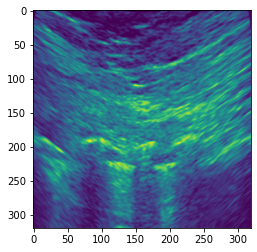

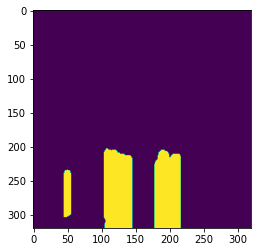

In [4]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


torch.Size([4, 4, 160, 320])
torch.Size([4, 160, 320])
image shape: torch.Size([4, 160, 320]), label shape: torch.Size([1, 160, 320])


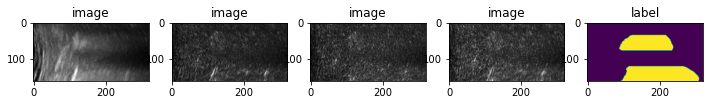

tensor(0.) tensor(2.)


In [7]:
imgnum = 2
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("image")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("image")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("image")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch>100:
                    metric = (metric_values[-1]+metric_values[-2])/2
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'.last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [10]:
for i in range(device_num,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.7333
2/0, train_loss: 0.7288
3/0, train_loss: 0.7259
4/0, train_loss: 0.7144
0 epoch 1 average loss: 0.7256
----------
0: epoch 2/500
1/0, train_loss: 0.7226
2/0, train_loss: 0.7168
3/0, train_loss: 0.7103
4/0, train_loss: 0.7030
0 epoch 2 average loss: 0.7132
current epoch: 2 current mean dice: 0.1625
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/500
1/0, train_loss: 0.7113
2/0, train_loss: 0.7045
3/0, train_loss: 0.7064
4/0, train_loss: 0.7101
0 epoch 3 average loss: 0.7081
----------
0: epoch 4/500
1/0, train_loss: 0.7017
2/0, train_loss: 0.7049
3/0, train_loss: 0.6948
4/0, train_loss: 0.6843
0 epoch 4 average loss: 0.6964
current epoch: 4 current mean dice: 0.1892
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 5/500
1/0, train_loss: 0.6853
2/0, train_loss: 0.6991
3/0, train_loss: 0.6897
4/0, train_loss: 0.7131
0 epoch 5 average loss: 0.6968
----------
0: epoch 6/500
1/0, train_loss: 0.6932
2/0, train_loss: 0.6829
3

1/0, train_loss: 0.6066
2/0, train_loss: 0.5904
3/0, train_loss: 0.6036
4/0, train_loss: 0.6317
0 epoch 43 average loss: 0.6081
----------
0: epoch 44/500
1/0, train_loss: 0.5955
2/0, train_loss: 0.6000
3/0, train_loss: 0.6137
4/0, train_loss: 0.5988
0 epoch 44 average loss: 0.6020
current epoch: 44 current mean dice: 0.6291
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 45/500
1/0, train_loss: 0.5812
2/0, train_loss: 0.6120
3/0, train_loss: 0.6019
4/0, train_loss: 0.5929
0 epoch 45 average loss: 0.5970
----------
0: epoch 46/500
1/0, train_loss: 0.6036
2/0, train_loss: 0.5773
3/0, train_loss: 0.6088
4/0, train_loss: 0.5852
0 epoch 46 average loss: 0.5937
current epoch: 46 current mean dice: 0.6111
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 47/500
1/0, train_loss: 0.6014
2/0, train_loss: 0.6012
3/0, train_loss: 0.5859
4/0, train_loss: 0.5923
0 epoch 47 average loss: 0.5952
----------
0: epoch 48/500
1/0, train_loss: 0.5916
2/0, train_loss: 0.5703
3/0, train_loss

1/0, train_loss: 0.5539
2/0, train_loss: 0.5836
3/0, train_loss: 0.5571
4/0, train_loss: 0.5363
0 epoch 85 average loss: 0.5577
----------
0: epoch 86/500
1/0, train_loss: 0.5326
2/0, train_loss: 0.5782
3/0, train_loss: 0.5937
4/0, train_loss: 0.4970
0 epoch 86 average loss: 0.5504
current epoch: 86 current mean dice: 0.6825
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 87/500
1/0, train_loss: 0.5708
2/0, train_loss: 0.5631
3/0, train_loss: 0.5440
4/0, train_loss: 0.6235
0 epoch 87 average loss: 0.5754
----------
0: epoch 88/500
1/0, train_loss: 0.5589
2/0, train_loss: 0.5583
3/0, train_loss: 0.5677
4/0, train_loss: 0.5390
0 epoch 88 average loss: 0.5560
current epoch: 88 current mean dice: 0.6253
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 89/500
1/0, train_loss: 0.5577
2/0, train_loss: 0.5720
3/0, train_loss: 0.5535
4/0, train_loss: 0.5938
0 epoch 89 average loss: 0.5692
----------
0: epoch 90/500
1/0, train_loss: 0.5153
2/0, train_loss: 0.5580
3/0, train_loss

current epoch: 126 current mean dice: 0.6480
best mean dice: 0.6842 at epoch: 108
----------
0: epoch 127/500
1/0, train_loss: 0.5416
2/0, train_loss: 0.5674
3/0, train_loss: 0.5131
4/0, train_loss: 0.5730
0 epoch 127 average loss: 0.5488
----------
0: epoch 128/500
1/0, train_loss: 0.5410
2/0, train_loss: 0.5322
3/0, train_loss: 0.5322
4/0, train_loss: 0.6493
0 epoch 128 average loss: 0.5636
current epoch: 128 current mean dice: 0.5818
best mean dice: 0.6842 at epoch: 108
----------
0: epoch 129/500
1/0, train_loss: 0.5659
2/0, train_loss: 0.5409
3/0, train_loss: 0.5420
4/0, train_loss: 0.5503
0 epoch 129 average loss: 0.5498
----------
0: epoch 130/500
1/0, train_loss: 0.5368
2/0, train_loss: 0.5259
3/0, train_loss: 0.5578
4/0, train_loss: 0.5027
0 epoch 130 average loss: 0.5308
current epoch: 130 current mean dice: 0.5254
best mean dice: 0.6842 at epoch: 108
----------
0: epoch 131/500
1/0, train_loss: 0.5265
2/0, train_loss: 0.5683
3/0, train_loss: 0.5267
4/0, train_loss: 0.5820
0 

1/0, train_loss: 0.5244
2/0, train_loss: 0.5207
3/0, train_loss: 0.5207
4/0, train_loss: 0.5820
0 epoch 168 average loss: 0.5369
current epoch: 168 current mean dice: 0.6973
best mean dice: 0.7295 at epoch: 160
----------
0: epoch 169/500
1/0, train_loss: 0.5121
2/0, train_loss: 0.5167
3/0, train_loss: 0.5300
4/0, train_loss: 0.6504
0 epoch 169 average loss: 0.5523
----------
0: epoch 170/500
1/0, train_loss: 0.5206
2/0, train_loss: 0.5555
3/0, train_loss: 0.4998
4/0, train_loss: 0.5610
0 epoch 170 average loss: 0.5342
saved new best metric model
current epoch: 170 current mean dice: 0.7487
best mean dice: 0.7487 at epoch: 170
----------
0: epoch 171/500
1/0, train_loss: 0.5154
2/0, train_loss: 0.5331
3/0, train_loss: 0.5267
4/0, train_loss: 0.5581
0 epoch 171 average loss: 0.5333
----------
0: epoch 172/500
1/0, train_loss: 0.5254
2/0, train_loss: 0.5052
3/0, train_loss: 0.5420
4/0, train_loss: 0.4955
0 epoch 172 average loss: 0.5170
saved new best metric model
current epoch: 172 curr

current epoch: 208 current mean dice: 0.8056
best mean dice: 0.8276 at epoch: 202
----------
0: epoch 209/500
1/0, train_loss: 0.4905
2/0, train_loss: 0.5114
3/0, train_loss: 0.5227
4/0, train_loss: 0.5888
0 epoch 209 average loss: 0.5283
----------
0: epoch 210/500
1/0, train_loss: 0.5208
2/0, train_loss: 0.5177
3/0, train_loss: 0.4883
4/0, train_loss: 0.4890
0 epoch 210 average loss: 0.5039
current epoch: 210 current mean dice: 0.8034
best mean dice: 0.8276 at epoch: 202
----------
0: epoch 211/500
1/0, train_loss: 0.5643
2/0, train_loss: 0.4867
3/0, train_loss: 0.4830
4/0, train_loss: 0.5644
0 epoch 211 average loss: 0.5246
----------
0: epoch 212/500
1/0, train_loss: 0.5040
2/0, train_loss: 0.5034
3/0, train_loss: 0.5337
4/0, train_loss: 0.4557
0 epoch 212 average loss: 0.4992
current epoch: 212 current mean dice: 0.7913
best mean dice: 0.8276 at epoch: 202
----------
0: epoch 213/500
1/0, train_loss: 0.5237
2/0, train_loss: 0.5092
3/0, train_loss: 0.4964
4/0, train_loss: 0.5218
0 

2/0, train_loss: 0.5041
3/0, train_loss: 0.5030
4/0, train_loss: 0.4839
0 epoch 250 average loss: 0.4887
current epoch: 250 current mean dice: 0.7916
best mean dice: 0.8276 at epoch: 202
----------
0: epoch 251/500
1/0, train_loss: 0.4935
2/0, train_loss: 0.4818
3/0, train_loss: 0.4883
4/0, train_loss: 0.5140
0 epoch 251 average loss: 0.4944
----------
0: epoch 252/500
1/0, train_loss: 0.4853
2/0, train_loss: 0.4850
3/0, train_loss: 0.5074
4/0, train_loss: 0.4528
0 epoch 252 average loss: 0.4826
current epoch: 252 current mean dice: 0.7448
best mean dice: 0.8276 at epoch: 202
----------
0: epoch 253/500
1/0, train_loss: 0.4887
2/0, train_loss: 0.4885
3/0, train_loss: 0.4962
4/0, train_loss: 0.6075
0 epoch 253 average loss: 0.5202
----------
0: epoch 254/500
1/0, train_loss: 0.4943
2/0, train_loss: 0.4915
3/0, train_loss: 0.4863
4/0, train_loss: 0.5734
0 epoch 254 average loss: 0.5114
current epoch: 254 current mean dice: 0.7151
best mean dice: 0.8276 at epoch: 202
----------
0: epoch 2

2/0, train_loss: 0.4647
3/0, train_loss: 0.4867
4/0, train_loss: 0.4328
0 epoch 291 average loss: 0.4694
----------
0: epoch 292/500
1/0, train_loss: 0.4869
2/0, train_loss: 0.4765
3/0, train_loss: 0.4757
4/0, train_loss: 0.4797
0 epoch 292 average loss: 0.4797
current epoch: 292 current mean dice: 0.7968
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 293/500
1/0, train_loss: 0.4542
2/0, train_loss: 0.4813
3/0, train_loss: 0.4975
4/0, train_loss: 0.4776
0 epoch 293 average loss: 0.4777
----------
0: epoch 294/500
1/0, train_loss: 0.4918
2/0, train_loss: 0.4693
3/0, train_loss: 0.4821
4/0, train_loss: 0.4529
0 epoch 294 average loss: 0.4740
current epoch: 294 current mean dice: 0.7946
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 295/500
1/0, train_loss: 0.4674
2/0, train_loss: 0.5020
3/0, train_loss: 0.4866
4/0, train_loss: 0.5803
0 epoch 295 average loss: 0.5091
----------
0: epoch 296/500
1/0, train_loss: 0.4780
2/0, train_loss: 0.4568
3/0, train_loss: 0.4677
4/0

1/0, train_loss: 0.4492
2/0, train_loss: 0.4707
3/0, train_loss: 0.4587
4/0, train_loss: 0.5490
0 epoch 333 average loss: 0.4819
----------
0: epoch 334/500
1/0, train_loss: 0.4666
2/0, train_loss: 0.4612
3/0, train_loss: 0.4801
4/0, train_loss: 0.4968
0 epoch 334 average loss: 0.4762
current epoch: 334 current mean dice: 0.7643
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 335/500
1/0, train_loss: 0.4484
2/0, train_loss: 0.4956
3/0, train_loss: 0.4775
4/0, train_loss: 0.4679
0 epoch 335 average loss: 0.4723
----------
0: epoch 336/500
1/0, train_loss: 0.4717
2/0, train_loss: 0.4674
3/0, train_loss: 0.4520
4/0, train_loss: 0.4606
0 epoch 336 average loss: 0.4629
current epoch: 336 current mean dice: 0.7954
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 337/500
1/0, train_loss: 0.4568
2/0, train_loss: 0.4638
3/0, train_loss: 0.4913
4/0, train_loss: 0.4632
0 epoch 337 average loss: 0.4688
----------
0: epoch 338/500
1/0, train_loss: 0.4679
2/0, train_loss: 0.4784
3/0

current epoch: 374 current mean dice: 0.8275
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 375/500
1/0, train_loss: 0.4615
2/0, train_loss: 0.4539
3/0, train_loss: 0.4450
4/0, train_loss: 0.4884
0 epoch 375 average loss: 0.4622
----------
0: epoch 376/500
1/0, train_loss: 0.4554
2/0, train_loss: 0.4709
3/0, train_loss: 0.4568
4/0, train_loss: 0.4290
0 epoch 376 average loss: 0.4530
current epoch: 376 current mean dice: 0.8007
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 377/500
1/0, train_loss: 0.4632
2/0, train_loss: 0.4533
3/0, train_loss: 0.4476
4/0, train_loss: 0.4322
0 epoch 377 average loss: 0.4491
----------
0: epoch 378/500
1/0, train_loss: 0.4496
2/0, train_loss: 0.4821
3/0, train_loss: 0.4500
4/0, train_loss: 0.5717
0 epoch 378 average loss: 0.4884
current epoch: 378 current mean dice: 0.7951
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 379/500
1/0, train_loss: 0.4383
2/0, train_loss: 0.4649
3/0, train_loss: 0.4666
4/0, train_loss: 0.5647
0 

2/0, train_loss: 0.4493
3/0, train_loss: 0.4452
4/0, train_loss: 0.5095
0 epoch 416 average loss: 0.4688
current epoch: 416 current mean dice: 0.7748
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 417/500
1/0, train_loss: 0.4457
2/0, train_loss: 0.4750
3/0, train_loss: 0.4537
4/0, train_loss: 0.4455
0 epoch 417 average loss: 0.4550
----------
0: epoch 418/500
1/0, train_loss: 0.4430
2/0, train_loss: 0.4704
3/0, train_loss: 0.4420
4/0, train_loss: 0.5554
0 epoch 418 average loss: 0.4777
current epoch: 418 current mean dice: 0.7639
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 419/500
1/0, train_loss: 0.4582
2/0, train_loss: 0.4863
3/0, train_loss: 0.4565
4/0, train_loss: 0.4595
0 epoch 419 average loss: 0.4651
----------
0: epoch 420/500
1/0, train_loss: 0.4474
2/0, train_loss: 0.4597
3/0, train_loss: 0.4402
4/0, train_loss: 0.4428
0 epoch 420 average loss: 0.4475
current epoch: 420 current mean dice: 0.8179
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 4

0 epoch 457 average loss: 0.4630
----------
0: epoch 458/500
1/0, train_loss: 0.4500
2/0, train_loss: 0.4545
3/0, train_loss: 0.4500
4/0, train_loss: 0.4330
0 epoch 458 average loss: 0.4469
current epoch: 458 current mean dice: 0.8220
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 459/500
1/0, train_loss: 0.4684
2/0, train_loss: 0.4330
3/0, train_loss: 0.4414
4/0, train_loss: 0.5327
0 epoch 459 average loss: 0.4689
----------
0: epoch 460/500
1/0, train_loss: 0.4325
2/0, train_loss: 0.4651
3/0, train_loss: 0.4413
4/0, train_loss: 0.5020
0 epoch 460 average loss: 0.4602
current epoch: 460 current mean dice: 0.8131
best mean dice: 0.8537 at epoch: 262
----------
0: epoch 461/500
1/0, train_loss: 0.4603
2/0, train_loss: 0.4549
3/0, train_loss: 0.4288
4/0, train_loss: 0.4153
0 epoch 461 average loss: 0.4398
----------
0: epoch 462/500
1/0, train_loss: 0.4611
2/0, train_loss: 0.4433
3/0, train_loss: 0.4646
4/0, train_loss: 0.4540
0 epoch 462 average loss: 0.4557
current epoch: 462

1/0, train_loss: 0.4491
2/0, train_loss: 0.4348
3/0, train_loss: 0.4408
4/0, train_loss: 0.4099
0 epoch 499 average loss: 0.4337
----------
0: epoch 500/500
1/0, train_loss: 0.4190
2/0, train_loss: 0.4587
3/0, train_loss: 0.4671
4/0, train_loss: 0.4384
0 epoch 500 average loss: 0.4458
current epoch: 500 current mean dice: 0.8139
best mean dice: 0.8537 at epoch: 262
----------
1: epoch 1/500
1/0, train_loss: 0.7437
2/0, train_loss: 0.7471
3/0, train_loss: 0.7344
4/0, train_loss: 0.7164
1 epoch 1 average loss: 0.7354
----------
1: epoch 2/500
1/0, train_loss: 0.7206
2/0, train_loss: 0.7288
3/0, train_loss: 0.7171
4/0, train_loss: 0.7163
1 epoch 2 average loss: 0.7207
current epoch: 2 current mean dice: 0.0719
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 3/500
1/0, train_loss: 0.7199
2/0, train_loss: 0.7035
3/0, train_loss: 0.7037
4/0, train_loss: 0.7179
1 epoch 3 average loss: 0.7112
----------
1: epoch 4/500
1/0, train_loss: 0.6981
2/0, train_loss: 0.7063
3/0, train_loss: 0.

1/0, train_loss: 0.5977
2/0, train_loss: 0.5891
3/0, train_loss: 0.6028
4/0, train_loss: 0.6531
1 epoch 41 average loss: 0.6107
----------
1: epoch 42/500
1/0, train_loss: 0.5760
2/0, train_loss: 0.6054
3/0, train_loss: 0.6133
4/0, train_loss: 0.5992
1 epoch 42 average loss: 0.5985
current epoch: 42 current mean dice: 0.3978
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 43/500
1/0, train_loss: 0.5886
2/0, train_loss: 0.5946
3/0, train_loss: 0.5868
4/0, train_loss: 0.5826
1 epoch 43 average loss: 0.5882
----------
1: epoch 44/500
1/0, train_loss: 0.5982
2/0, train_loss: 0.5847
3/0, train_loss: 0.5817
4/0, train_loss: 0.6192
1 epoch 44 average loss: 0.5960
current epoch: 44 current mean dice: 0.4709
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 45/500
1/0, train_loss: 0.5821
2/0, train_loss: 0.5889
3/0, train_loss: 0.5932
4/0, train_loss: 0.6105
1 epoch 45 average loss: 0.5937
----------
1: epoch 46/500
1/0, train_loss: 0.5741
2/0, train_loss: 0.5828
3/0, train_loss

1/0, train_loss: 0.5647
2/0, train_loss: 0.5390
3/0, train_loss: 0.5395
4/0, train_loss: 0.5840
1 epoch 83 average loss: 0.5568
----------
1: epoch 84/500
1/0, train_loss: 0.5330
2/0, train_loss: 0.5319
3/0, train_loss: 0.5549
4/0, train_loss: 0.6049
1 epoch 84 average loss: 0.5562
current epoch: 84 current mean dice: 0.5692
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 85/500
1/0, train_loss: 0.5432
2/0, train_loss: 0.5400
3/0, train_loss: 0.5490
4/0, train_loss: 0.5216
1 epoch 85 average loss: 0.5384
----------
1: epoch 86/500
1/0, train_loss: 0.5500
2/0, train_loss: 0.5540
3/0, train_loss: 0.5406
4/0, train_loss: 0.5544
1 epoch 86 average loss: 0.5498
current epoch: 86 current mean dice: 0.6048
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 87/500
1/0, train_loss: 0.5413
2/0, train_loss: 0.5551
3/0, train_loss: 0.5474
4/0, train_loss: 0.6281
1 epoch 87 average loss: 0.5680
----------
1: epoch 88/500
1/0, train_loss: 0.5374
2/0, train_loss: 0.5473
3/0, train_loss

2/0, train_loss: 0.5321
3/0, train_loss: 0.5193
4/0, train_loss: 0.5850
1 epoch 124 average loss: 0.5388
current epoch: 124 current mean dice: 0.5176
best mean dice: 0.5869 at epoch: 110
----------
1: epoch 125/500
1/0, train_loss: 0.5114
2/0, train_loss: 0.5267
3/0, train_loss: 0.5259
4/0, train_loss: 0.6376
1 epoch 125 average loss: 0.5504
----------
1: epoch 126/500
1/0, train_loss: 0.5089
2/0, train_loss: 0.5235
3/0, train_loss: 0.5486
4/0, train_loss: 0.4881
1 epoch 126 average loss: 0.5173
current epoch: 126 current mean dice: 0.5255
best mean dice: 0.5869 at epoch: 110
----------
1: epoch 127/500
1/0, train_loss: 0.5119
2/0, train_loss: 0.5202
3/0, train_loss: 0.5353
4/0, train_loss: 0.5402
1 epoch 127 average loss: 0.5269
----------
1: epoch 128/500
1/0, train_loss: 0.5266
2/0, train_loss: 0.5175
3/0, train_loss: 0.5054
4/0, train_loss: 0.5922
1 epoch 128 average loss: 0.5354
current epoch: 128 current mean dice: 0.5015
best mean dice: 0.5869 at epoch: 110
----------
1: epoch 1

1/0, train_loss: 0.4975
2/0, train_loss: 0.5164
3/0, train_loss: 0.5015
4/0, train_loss: 0.4497
1 epoch 165 average loss: 0.4913
----------
1: epoch 166/500
1/0, train_loss: 0.4986
2/0, train_loss: 0.5091
3/0, train_loss: 0.5095
4/0, train_loss: 0.5690
1 epoch 166 average loss: 0.5216
current epoch: 166 current mean dice: 0.5128
best mean dice: 0.6451 at epoch: 160
----------
1: epoch 167/500
1/0, train_loss: 0.5042
2/0, train_loss: 0.4967
3/0, train_loss: 0.5053
4/0, train_loss: 0.4817
1 epoch 167 average loss: 0.4970
----------
1: epoch 168/500
1/0, train_loss: 0.5158
2/0, train_loss: 0.4955
3/0, train_loss: 0.5074
4/0, train_loss: 0.5105
1 epoch 168 average loss: 0.5073
current epoch: 168 current mean dice: 0.5970
best mean dice: 0.6451 at epoch: 160
----------
1: epoch 169/500
1/0, train_loss: 0.4986
2/0, train_loss: 0.4914
3/0, train_loss: 0.5063
4/0, train_loss: 0.4880
1 epoch 169 average loss: 0.4961
----------
1: epoch 170/500
1/0, train_loss: 0.5232
2/0, train_loss: 0.4844
3/0

3/0, train_loss: 0.4779
4/0, train_loss: 0.5266
1 epoch 206 average loss: 0.4986
current epoch: 206 current mean dice: 0.5903
best mean dice: 0.6706 at epoch: 202
----------
1: epoch 207/500
1/0, train_loss: 0.5278
2/0, train_loss: 0.4833
3/0, train_loss: 0.4725
4/0, train_loss: 0.5166
1 epoch 207 average loss: 0.5001
----------
1: epoch 208/500
1/0, train_loss: 0.5267
2/0, train_loss: 0.4827
3/0, train_loss: 0.4936
4/0, train_loss: 0.4871
1 epoch 208 average loss: 0.4975
current epoch: 208 current mean dice: 0.6229
best mean dice: 0.6706 at epoch: 202
----------
1: epoch 209/500
1/0, train_loss: 0.4925
2/0, train_loss: 0.4731
3/0, train_loss: 0.5032
4/0, train_loss: 0.4997
1 epoch 209 average loss: 0.4921
----------
1: epoch 210/500
1/0, train_loss: 0.4971
2/0, train_loss: 0.4898
3/0, train_loss: 0.4669
4/0, train_loss: 0.4904
1 epoch 210 average loss: 0.4861
current epoch: 210 current mean dice: 0.5644
best mean dice: 0.6706 at epoch: 202
----------
1: epoch 211/500
1/0, train_loss: 

1 epoch 247 average loss: 0.4702
----------
1: epoch 248/500
1/0, train_loss: 0.4758
2/0, train_loss: 0.4862
3/0, train_loss: 0.4766
4/0, train_loss: 0.4822
1 epoch 248 average loss: 0.4802
current epoch: 248 current mean dice: 0.5756
best mean dice: 0.6706 at epoch: 202
----------
1: epoch 249/500
1/0, train_loss: 0.4656
2/0, train_loss: 0.4686
3/0, train_loss: 0.4926
4/0, train_loss: 0.4748
1 epoch 249 average loss: 0.4754
----------
1: epoch 250/500
1/0, train_loss: 0.4497
2/0, train_loss: 0.4908
3/0, train_loss: 0.5102
4/0, train_loss: 0.4621
1 epoch 250 average loss: 0.4782
current epoch: 250 current mean dice: 0.5531
best mean dice: 0.6706 at epoch: 202
----------
1: epoch 251/500
1/0, train_loss: 0.4659
2/0, train_loss: 0.4843
3/0, train_loss: 0.4641
4/0, train_loss: 0.4889
1 epoch 251 average loss: 0.4758
----------
1: epoch 252/500
1/0, train_loss: 0.4564
2/0, train_loss: 0.4698
3/0, train_loss: 0.4912
4/0, train_loss: 0.4862
1 epoch 252 average loss: 0.4759
current epoch: 252

1/0, train_loss: 0.4656
2/0, train_loss: 0.4694
3/0, train_loss: 0.4752
4/0, train_loss: 0.4772
1 epoch 289 average loss: 0.4718
----------
1: epoch 290/500
1/0, train_loss: 0.4616
2/0, train_loss: 0.4546
3/0, train_loss: 0.5010
4/0, train_loss: 0.5195
1 epoch 290 average loss: 0.4841
current epoch: 290 current mean dice: 0.6515
best mean dice: 0.6706 at epoch: 202
----------
1: epoch 291/500
1/0, train_loss: 0.4727
2/0, train_loss: 0.4709
3/0, train_loss: 0.4524
4/0, train_loss: 0.4444
1 epoch 291 average loss: 0.4601
----------
1: epoch 292/500
1/0, train_loss: 0.4574
2/0, train_loss: 0.4538
3/0, train_loss: 0.4706
4/0, train_loss: 0.5511
1 epoch 292 average loss: 0.4832
current epoch: 292 current mean dice: 0.6013
best mean dice: 0.6706 at epoch: 202
----------
1: epoch 293/500
1/0, train_loss: 0.4733
2/0, train_loss: 0.4734
3/0, train_loss: 0.4856
4/0, train_loss: 0.4865
1 epoch 293 average loss: 0.4797
----------
1: epoch 294/500
1/0, train_loss: 0.4798
2/0, train_loss: 0.4495
3/0

1 epoch 330 average loss: 0.4777
current epoch: 330 current mean dice: 0.6370
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 331/500
1/0, train_loss: 0.4313
2/0, train_loss: 0.4378
3/0, train_loss: 0.5082
4/0, train_loss: 0.4495
1 epoch 331 average loss: 0.4567
----------
1: epoch 332/500
1/0, train_loss: 0.4577
2/0, train_loss: 0.4500
3/0, train_loss: 0.4582
4/0, train_loss: 0.5282
1 epoch 332 average loss: 0.4735
current epoch: 332 current mean dice: 0.5618
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 333/500
1/0, train_loss: 0.4524
2/0, train_loss: 0.4689
3/0, train_loss: 0.4501
4/0, train_loss: 0.5059
1 epoch 333 average loss: 0.4693
----------
1: epoch 334/500
1/0, train_loss: 0.4465
2/0, train_loss: 0.4441
3/0, train_loss: 0.4754
4/0, train_loss: 0.4351
1 epoch 334 average loss: 0.4503
current epoch: 334 current mean dice: 0.6062
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 335/500
1/0, train_loss: 0.4661
2/0, train_loss: 0.4431
3/0, train_loss: 

1/0, train_loss: 0.4483
2/0, train_loss: 0.4531
3/0, train_loss: 0.4423
4/0, train_loss: 0.4267
1 epoch 372 average loss: 0.4426
current epoch: 372 current mean dice: 0.5860
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 373/500
1/0, train_loss: 0.4346
2/0, train_loss: 0.4601
3/0, train_loss: 0.4690
4/0, train_loss: 0.4297
1 epoch 373 average loss: 0.4484
----------
1: epoch 374/500
1/0, train_loss: 0.4498
2/0, train_loss: 0.4655
3/0, train_loss: 0.4397
4/0, train_loss: 0.4523
1 epoch 374 average loss: 0.4518
current epoch: 374 current mean dice: 0.5701
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 375/500
1/0, train_loss: 0.4507
2/0, train_loss: 0.4495
3/0, train_loss: 0.4410
4/0, train_loss: 0.4594
1 epoch 375 average loss: 0.4502
----------
1: epoch 376/500
1/0, train_loss: 0.4340
2/0, train_loss: 0.4513
3/0, train_loss: 0.4512
4/0, train_loss: 0.5284
1 epoch 376 average loss: 0.4662
current epoch: 376 current mean dice: 0.5432
best mean dice: 0.6768 at epoch: 2

3/0, train_loss: 0.4407
4/0, train_loss: 0.4797
1 epoch 413 average loss: 0.4555
----------
1: epoch 414/500
1/0, train_loss: 0.4478
2/0, train_loss: 0.4491
3/0, train_loss: 0.4453
4/0, train_loss: 0.5066
1 epoch 414 average loss: 0.4622
current epoch: 414 current mean dice: 0.5873
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 415/500
1/0, train_loss: 0.4283
2/0, train_loss: 0.4710
3/0, train_loss: 0.4426
4/0, train_loss: 0.4849
1 epoch 415 average loss: 0.4567
----------
1: epoch 416/500
1/0, train_loss: 0.4517
2/0, train_loss: 0.4607
3/0, train_loss: 0.4438
4/0, train_loss: 0.4383
1 epoch 416 average loss: 0.4486
current epoch: 416 current mean dice: 0.6410
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 417/500
1/0, train_loss: 0.4304
2/0, train_loss: 0.4638
3/0, train_loss: 0.4475
4/0, train_loss: 0.5038
1 epoch 417 average loss: 0.4614
----------
1: epoch 418/500
1/0, train_loss: 0.4355
2/0, train_loss: 0.4559
3/0, train_loss: 0.4576
4/0, train_loss: 0.4288
1 e

1/0, train_loss: 0.4340
2/0, train_loss: 0.4466
3/0, train_loss: 0.4496
4/0, train_loss: 0.5459
1 epoch 455 average loss: 0.4690
----------
1: epoch 456/500
1/0, train_loss: 0.4329
2/0, train_loss: 0.4540
3/0, train_loss: 0.4407
4/0, train_loss: 0.4760
1 epoch 456 average loss: 0.4509
current epoch: 456 current mean dice: 0.6659
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 457/500
1/0, train_loss: 0.4305
2/0, train_loss: 0.4545
3/0, train_loss: 0.4535
4/0, train_loss: 0.5122
1 epoch 457 average loss: 0.4627
----------
1: epoch 458/500
1/0, train_loss: 0.4359
2/0, train_loss: 0.4717
3/0, train_loss: 0.4306
4/0, train_loss: 0.4769
1 epoch 458 average loss: 0.4538
current epoch: 458 current mean dice: 0.5799
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 459/500
1/0, train_loss: 0.4515
2/0, train_loss: 0.4396
3/0, train_loss: 0.4365
4/0, train_loss: 0.4834
1 epoch 459 average loss: 0.4527
----------
1: epoch 460/500
1/0, train_loss: 0.4436
2/0, train_loss: 0.4467
3/0

current epoch: 496 current mean dice: 0.5843
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 497/500
1/0, train_loss: 0.4297
2/0, train_loss: 0.4426
3/0, train_loss: 0.4322
4/0, train_loss: 0.4074
1 epoch 497 average loss: 0.4280
----------
1: epoch 498/500
1/0, train_loss: 0.4378
2/0, train_loss: 0.4435
3/0, train_loss: 0.4534
4/0, train_loss: 0.4798
1 epoch 498 average loss: 0.4536
current epoch: 498 current mean dice: 0.5858
best mean dice: 0.6768 at epoch: 296
----------
1: epoch 499/500
1/0, train_loss: 0.4332
2/0, train_loss: 0.4416
3/0, train_loss: 0.4529
4/0, train_loss: 0.4654
1 epoch 499 average loss: 0.4483
----------
1: epoch 500/500
1/0, train_loss: 0.4391
2/0, train_loss: 0.4363
3/0, train_loss: 0.4562
4/0, train_loss: 0.4533
1 epoch 500 average loss: 0.4462
current epoch: 500 current mean dice: 0.6318
best mean dice: 0.6768 at epoch: 296
----------
2: epoch 1/500
1/0, train_loss: 0.7541
2/0, train_loss: 0.7574
3/0, train_loss: 0.7499
4/0, train_loss: 0.7218
2 ep

current epoch: 38 current mean dice: 0.4822
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 39/500
1/0, train_loss: 0.6348
2/0, train_loss: 0.6292
3/0, train_loss: 0.6146
4/0, train_loss: 0.7242
2 epoch 39 average loss: 0.6507
----------
2: epoch 40/500
1/0, train_loss: 0.6126
2/0, train_loss: 0.6257
3/0, train_loss: 0.6283
4/0, train_loss: 0.6233
2 epoch 40 average loss: 0.6225
current epoch: 40 current mean dice: 0.4925
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 41/500
1/0, train_loss: 0.6273
2/0, train_loss: 0.6319
3/0, train_loss: 0.6259
4/0, train_loss: 0.6065
2 epoch 41 average loss: 0.6229
----------
2: epoch 42/500
1/0, train_loss: 0.6317
2/0, train_loss: 0.6292
3/0, train_loss: 0.6164
4/0, train_loss: 0.6093
2 epoch 42 average loss: 0.6217
current epoch: 42 current mean dice: 0.5002
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 43/500
1/0, train_loss: 0.6175
2/0, train_loss: 0.6127
3/0, train_loss: 0.6242
4/0, train_loss: 0.6485
2 epoch 43 ave

current epoch: 80 current mean dice: 0.5648
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 81/500
1/0, train_loss: 0.5795
2/0, train_loss: 0.5604
3/0, train_loss: 0.6088
4/0, train_loss: 0.6814
2 epoch 81 average loss: 0.6075
----------
2: epoch 82/500
1/0, train_loss: 0.5971
2/0, train_loss: 0.5683
3/0, train_loss: 0.5729
4/0, train_loss: 0.6802
2 epoch 82 average loss: 0.6046
current epoch: 82 current mean dice: 0.4983
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 83/500
1/0, train_loss: 0.5757
2/0, train_loss: 0.5827
3/0, train_loss: 0.5721
4/0, train_loss: 0.5451
2 epoch 83 average loss: 0.5689
----------
2: epoch 84/500
1/0, train_loss: 0.5671
2/0, train_loss: 0.5855
3/0, train_loss: 0.6030
4/0, train_loss: 0.6093
2 epoch 84 average loss: 0.5912
current epoch: 84 current mean dice: 0.5233
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 85/500
1/0, train_loss: 0.5799
2/0, train_loss: 0.5770
3/0, train_loss: 0.5980
4/0, train_loss: 0.6224
2 epoch 85 ave

1/0, train_loss: 0.5556
2/0, train_loss: 0.5507
3/0, train_loss: 0.5607
4/0, train_loss: 0.5967
2 epoch 122 average loss: 0.5659
current epoch: 122 current mean dice: 0.5278
best mean dice: 0.6047 at epoch: 108
----------
2: epoch 123/500
1/0, train_loss: 0.5423
2/0, train_loss: 0.5666
3/0, train_loss: 0.5379
4/0, train_loss: 0.6565
2 epoch 123 average loss: 0.5758
----------
2: epoch 124/500
1/0, train_loss: 0.5528
2/0, train_loss: 0.5490
3/0, train_loss: 0.5273
4/0, train_loss: 0.5560
2 epoch 124 average loss: 0.5463
current epoch: 124 current mean dice: 0.5996
best mean dice: 0.6047 at epoch: 108
----------
2: epoch 125/500
1/0, train_loss: 0.5381
2/0, train_loss: 0.5455
3/0, train_loss: 0.5759
4/0, train_loss: 0.5779
2 epoch 125 average loss: 0.5593
----------
2: epoch 126/500
1/0, train_loss: 0.5322
2/0, train_loss: 0.5602
3/0, train_loss: 0.5588
4/0, train_loss: 0.5788
2 epoch 126 average loss: 0.5575
current epoch: 126 current mean dice: 0.5663
best mean dice: 0.6047 at epoch: 1

2/0, train_loss: 0.5267
3/0, train_loss: 0.5226
4/0, train_loss: 0.5357
2 epoch 163 average loss: 0.5351
----------
2: epoch 164/500
1/0, train_loss: 0.5274
2/0, train_loss: 0.5533
3/0, train_loss: 0.5395
4/0, train_loss: 0.5503
2 epoch 164 average loss: 0.5426
current epoch: 164 current mean dice: 0.5186
best mean dice: 0.7158 at epoch: 148
----------
2: epoch 165/500
1/0, train_loss: 0.5285
2/0, train_loss: 0.5125
3/0, train_loss: 0.5547
4/0, train_loss: 0.5723
2 epoch 165 average loss: 0.5420
----------
2: epoch 166/500
1/0, train_loss: 0.5317
2/0, train_loss: 0.5551
3/0, train_loss: 0.5287
4/0, train_loss: 0.5376
2 epoch 166 average loss: 0.5383
current epoch: 166 current mean dice: 0.6291
best mean dice: 0.7158 at epoch: 148
----------
2: epoch 167/500
1/0, train_loss: 0.5327
2/0, train_loss: 0.5455
3/0, train_loss: 0.5232
4/0, train_loss: 0.5368
2 epoch 167 average loss: 0.5346
----------
2: epoch 168/500
1/0, train_loss: 0.5293
2/0, train_loss: 0.5349
3/0, train_loss: 0.5386
4/0

1/0, train_loss: 0.5196
2/0, train_loss: 0.5253
3/0, train_loss: 0.5127
4/0, train_loss: 0.5745
2 epoch 205 average loss: 0.5330
----------
2: epoch 206/500
1/0, train_loss: 0.5046
2/0, train_loss: 0.5009
3/0, train_loss: 0.5160
4/0, train_loss: 0.5386
2 epoch 206 average loss: 0.5150
current epoch: 206 current mean dice: 0.5731
best mean dice: 0.7158 at epoch: 148
----------
2: epoch 207/500
1/0, train_loss: 0.5217
2/0, train_loss: 0.4932
3/0, train_loss: 0.5340
4/0, train_loss: 0.5314
2 epoch 207 average loss: 0.5201
----------
2: epoch 208/500
1/0, train_loss: 0.5128
2/0, train_loss: 0.5008
3/0, train_loss: 0.5065
4/0, train_loss: 0.5356
2 epoch 208 average loss: 0.5139
current epoch: 208 current mean dice: 0.6095
best mean dice: 0.7158 at epoch: 148
----------
2: epoch 209/500
1/0, train_loss: 0.5212
2/0, train_loss: 0.4975
3/0, train_loss: 0.4962
4/0, train_loss: 0.4993
2 epoch 209 average loss: 0.5035
----------
2: epoch 210/500
1/0, train_loss: 0.5048
2/0, train_loss: 0.5196
3/0

2 epoch 246 average loss: 0.4985
current epoch: 246 current mean dice: 0.4543
best mean dice: 0.7235 at epoch: 242
----------
2: epoch 247/500
1/0, train_loss: 0.4953
2/0, train_loss: 0.5106
3/0, train_loss: 0.4923
4/0, train_loss: 0.5222
2 epoch 247 average loss: 0.5051
----------
2: epoch 248/500
1/0, train_loss: 0.4919
2/0, train_loss: 0.4847
3/0, train_loss: 0.5058
4/0, train_loss: 0.6134
2 epoch 248 average loss: 0.5239
current epoch: 248 current mean dice: 0.6242
best mean dice: 0.7235 at epoch: 242
----------
2: epoch 249/500
1/0, train_loss: 0.5254
2/0, train_loss: 0.4958
3/0, train_loss: 0.4861
4/0, train_loss: 0.4814
2 epoch 249 average loss: 0.4972
----------
2: epoch 250/500
1/0, train_loss: 0.4896
2/0, train_loss: 0.5138
3/0, train_loss: 0.4774
4/0, train_loss: 0.4944
2 epoch 250 average loss: 0.4938
saved new best metric model
current epoch: 250 current mean dice: 0.7249
best mean dice: 0.7249 at epoch: 250
----------
2: epoch 251/500
1/0, train_loss: 0.4842
2/0, train_lo

1/0, train_loss: 0.4777
2/0, train_loss: 0.4860
3/0, train_loss: 0.4816
4/0, train_loss: 0.5159
2 epoch 288 average loss: 0.4903
current epoch: 288 current mean dice: 0.4688
best mean dice: 0.7249 at epoch: 250
----------
2: epoch 289/500
1/0, train_loss: 0.4699
2/0, train_loss: 0.5117
3/0, train_loss: 0.5089
4/0, train_loss: 0.4632
2 epoch 289 average loss: 0.4884
----------
2: epoch 290/500
1/0, train_loss: 0.4687
2/0, train_loss: 0.4907
3/0, train_loss: 0.5270
4/0, train_loss: 0.5716
2 epoch 290 average loss: 0.5145
current epoch: 290 current mean dice: 0.5788
best mean dice: 0.7249 at epoch: 250
----------
2: epoch 291/500
1/0, train_loss: 0.4938
2/0, train_loss: 0.4781
3/0, train_loss: 0.4880
4/0, train_loss: 0.5027
2 epoch 291 average loss: 0.4906
----------
2: epoch 292/500
1/0, train_loss: 0.5030
2/0, train_loss: 0.4738
3/0, train_loss: 0.4949
4/0, train_loss: 0.6285
2 epoch 292 average loss: 0.5250
current epoch: 292 current mean dice: 0.5973
best mean dice: 0.7249 at epoch: 2

2/0, train_loss: 0.4822
3/0, train_loss: 0.4894
4/0, train_loss: 0.4826
2 epoch 329 average loss: 0.4841
----------
2: epoch 330/500
1/0, train_loss: 0.4833
2/0, train_loss: 0.4618
3/0, train_loss: 0.4659
4/0, train_loss: 0.6244
2 epoch 330 average loss: 0.5089
current epoch: 330 current mean dice: 0.6164
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 331/500
1/0, train_loss: 0.4658
2/0, train_loss: 0.4756
3/0, train_loss: 0.4833
4/0, train_loss: 0.5357
2 epoch 331 average loss: 0.4901
----------
2: epoch 332/500
1/0, train_loss: 0.5038
2/0, train_loss: 0.4883
3/0, train_loss: 0.4642
4/0, train_loss: 0.5064
2 epoch 332 average loss: 0.4907
current epoch: 332 current mean dice: 0.5441
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 333/500
1/0, train_loss: 0.4707
2/0, train_loss: 0.4838
3/0, train_loss: 0.4752
4/0, train_loss: 0.4654
2 epoch 333 average loss: 0.4738
----------
2: epoch 334/500
1/0, train_loss: 0.4813
2/0, train_loss: 0.4941
3/0, train_loss: 0.4637
4/0

1/0, train_loss: 0.4768
2/0, train_loss: 0.4733
3/0, train_loss: 0.4757
4/0, train_loss: 0.4819
2 epoch 371 average loss: 0.4769
----------
2: epoch 372/500
1/0, train_loss: 0.4705
2/0, train_loss: 0.4911
3/0, train_loss: 0.4685
4/0, train_loss: 0.4847
2 epoch 372 average loss: 0.4787
current epoch: 372 current mean dice: 0.5942
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 373/500
1/0, train_loss: 0.4527
2/0, train_loss: 0.4740
3/0, train_loss: 0.4771
4/0, train_loss: 0.4890
2 epoch 373 average loss: 0.4732
----------
2: epoch 374/500
1/0, train_loss: 0.4790
2/0, train_loss: 0.4810
3/0, train_loss: 0.4769
4/0, train_loss: 0.5607
2 epoch 374 average loss: 0.4994
current epoch: 374 current mean dice: 0.6496
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 375/500
1/0, train_loss: 0.4774
2/0, train_loss: 0.4689
3/0, train_loss: 0.4675
4/0, train_loss: 0.5246
2 epoch 375 average loss: 0.4846
----------
2: epoch 376/500
1/0, train_loss: 0.4522
2/0, train_loss: 0.4703
3/0

current epoch: 412 current mean dice: 0.5574
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 413/500
1/0, train_loss: 0.4411
2/0, train_loss: 0.4757
3/0, train_loss: 0.4627
4/0, train_loss: 0.4826
2 epoch 413 average loss: 0.4655
----------
2: epoch 414/500
1/0, train_loss: 0.4856
2/0, train_loss: 0.4395
3/0, train_loss: 0.4599
4/0, train_loss: 0.4619
2 epoch 414 average loss: 0.4617
current epoch: 414 current mean dice: 0.6221
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 415/500
1/0, train_loss: 0.4767
2/0, train_loss: 0.4650
3/0, train_loss: 0.4653
4/0, train_loss: 0.5305
2 epoch 415 average loss: 0.4844
----------
2: epoch 416/500
1/0, train_loss: 0.4561
2/0, train_loss: 0.4629
3/0, train_loss: 0.4671
4/0, train_loss: 0.4593
2 epoch 416 average loss: 0.4613
current epoch: 416 current mean dice: 0.6381
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 417/500
1/0, train_loss: 0.4729
2/0, train_loss: 0.4589
3/0, train_loss: 0.4494
4/0, train_loss: 0.4543
2 

2/0, train_loss: 0.4392
3/0, train_loss: 0.4633
4/0, train_loss: 0.4919
2 epoch 454 average loss: 0.4654
current epoch: 454 current mean dice: 0.6525
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 455/500
1/0, train_loss: 0.4728
2/0, train_loss: 0.4673
3/0, train_loss: 0.4349
4/0, train_loss: 0.4447
2 epoch 455 average loss: 0.4549
----------
2: epoch 456/500
1/0, train_loss: 0.4643
2/0, train_loss: 0.4991
3/0, train_loss: 0.4516
4/0, train_loss: 0.4872
2 epoch 456 average loss: 0.4756
current epoch: 456 current mean dice: 0.6810
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 457/500
1/0, train_loss: 0.4579
2/0, train_loss: 0.4518
3/0, train_loss: 0.4412
4/0, train_loss: 0.5207
2 epoch 457 average loss: 0.4679
----------
2: epoch 458/500
1/0, train_loss: 0.4609
2/0, train_loss: 0.4533
3/0, train_loss: 0.4565
4/0, train_loss: 0.6283
2 epoch 458 average loss: 0.4998
current epoch: 458 current mean dice: 0.6733
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 4

2 epoch 495 average loss: 0.4968
----------
2: epoch 496/500
1/0, train_loss: 0.4814
2/0, train_loss: 0.4271
3/0, train_loss: 0.4478
4/0, train_loss: 0.5627
2 epoch 496 average loss: 0.4798
current epoch: 496 current mean dice: 0.6840
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 497/500
1/0, train_loss: 0.4637
2/0, train_loss: 0.4598
3/0, train_loss: 0.4562
4/0, train_loss: 0.4811
2 epoch 497 average loss: 0.4652
----------
2: epoch 498/500
1/0, train_loss: 0.4300
2/0, train_loss: 0.4459
3/0, train_loss: 0.4752
4/0, train_loss: 0.5516
2 epoch 498 average loss: 0.4757
current epoch: 498 current mean dice: 0.6289
best mean dice: 0.7721 at epoch: 296
----------
2: epoch 499/500
1/0, train_loss: 0.4683
2/0, train_loss: 0.4583
3/0, train_loss: 0.4617
4/0, train_loss: 0.4556
2 epoch 499 average loss: 0.4610
----------
2: epoch 500/500
1/0, train_loss: 0.4484
2/0, train_loss: 0.4450
3/0, train_loss: 0.4530
4/0, train_loss: 0.4285
2 epoch 500 average loss: 0.4437
current epoch: 500

3 epoch 37 average loss: 0.5972
----------
3: epoch 38/500
1/0, train_loss: 0.6123
2/0, train_loss: 0.6130
3/0, train_loss: 0.6058
4/0, train_loss: 0.5122
3 epoch 38 average loss: 0.5858
current epoch: 38 current mean dice: 0.6372
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 39/500
1/0, train_loss: 0.5950
2/0, train_loss: 0.6056
3/0, train_loss: 0.6172
4/0, train_loss: 0.6652
3 epoch 39 average loss: 0.6208
----------
3: epoch 40/500
1/0, train_loss: 0.5686
2/0, train_loss: 0.6206
3/0, train_loss: 0.6121
4/0, train_loss: 0.7264
3 epoch 40 average loss: 0.6320
current epoch: 40 current mean dice: 0.6326
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 41/500
1/0, train_loss: 0.6209
2/0, train_loss: 0.5865
3/0, train_loss: 0.6027
4/0, train_loss: 0.5124
3 epoch 41 average loss: 0.5806
----------
3: epoch 42/500
1/0, train_loss: 0.6143
2/0, train_loss: 0.5967
3/0, train_loss: 0.5959
4/0, train_loss: 0.6537
3 epoch 42 average loss: 0.6151
current epoch: 42 current mean 

3 epoch 79 average loss: 0.6161
----------
3: epoch 80/500
1/0, train_loss: 0.5688
2/0, train_loss: 0.5588
3/0, train_loss: 0.5825
4/0, train_loss: 0.6682
3 epoch 80 average loss: 0.5946
current epoch: 80 current mean dice: 0.5652
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 81/500
1/0, train_loss: 0.5362
2/0, train_loss: 0.5667
3/0, train_loss: 0.6084
4/0, train_loss: 0.6893
3 epoch 81 average loss: 0.6002
----------
3: epoch 82/500
1/0, train_loss: 0.5638
2/0, train_loss: 0.5488
3/0, train_loss: 0.5799
4/0, train_loss: 0.6693
3 epoch 82 average loss: 0.5904
current epoch: 82 current mean dice: 0.6306
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 83/500
1/0, train_loss: 0.5622
2/0, train_loss: 0.5682
3/0, train_loss: 0.5818
4/0, train_loss: 0.6369
3 epoch 83 average loss: 0.5873
----------
3: epoch 84/500
1/0, train_loss: 0.5534
2/0, train_loss: 0.5389
3/0, train_loss: 0.6061
4/0, train_loss: 0.5070
3 epoch 84 average loss: 0.5514
current epoch: 84 current mean 

1/0, train_loss: 0.5080
2/0, train_loss: 0.5582
3/0, train_loss: 0.5564
4/0, train_loss: 0.5453
3 epoch 121 average loss: 0.5420
----------
3: epoch 122/500
1/0, train_loss: 0.5131
2/0, train_loss: 0.5688
3/0, train_loss: 0.5266
4/0, train_loss: 0.5345
3 epoch 122 average loss: 0.5357
current epoch: 122 current mean dice: 0.6199
best mean dice: 0.6698 at epoch: 108
----------
3: epoch 123/500
1/0, train_loss: 0.5224
2/0, train_loss: 0.5064
3/0, train_loss: 0.5750
4/0, train_loss: 0.7093
3 epoch 123 average loss: 0.5783
----------
3: epoch 124/500
1/0, train_loss: 0.5372
2/0, train_loss: 0.5489
3/0, train_loss: 0.5104
4/0, train_loss: 0.6230
3 epoch 124 average loss: 0.5549
saved new best metric model
current epoch: 124 current mean dice: 0.6704
best mean dice: 0.6704 at epoch: 124
----------
3: epoch 125/500
1/0, train_loss: 0.5172
2/0, train_loss: 0.5508
3/0, train_loss: 0.5396
4/0, train_loss: 0.6178
3 epoch 125 average loss: 0.5564
----------
3: epoch 126/500
1/0, train_loss: 0.5630

2/0, train_loss: 0.4800
3/0, train_loss: 0.5309
4/0, train_loss: 0.6277
3 epoch 162 average loss: 0.5425
current epoch: 162 current mean dice: 0.6698
best mean dice: 0.7563 at epoch: 144
----------
3: epoch 163/500
1/0, train_loss: 0.5684
2/0, train_loss: 0.5075
3/0, train_loss: 0.5040
4/0, train_loss: 0.6055
3 epoch 163 average loss: 0.5463
----------
3: epoch 164/500
1/0, train_loss: 0.5038
2/0, train_loss: 0.5143
3/0, train_loss: 0.5246
4/0, train_loss: 0.5698
3 epoch 164 average loss: 0.5281
current epoch: 164 current mean dice: 0.6771
best mean dice: 0.7563 at epoch: 144
----------
3: epoch 165/500
1/0, train_loss: 0.5349
2/0, train_loss: 0.5221
3/0, train_loss: 0.5185
4/0, train_loss: 0.4740
3 epoch 165 average loss: 0.5124
----------
3: epoch 166/500
1/0, train_loss: 0.5301
2/0, train_loss: 0.5188
3/0, train_loss: 0.5190
4/0, train_loss: 0.4427
3 epoch 166 average loss: 0.5026
current epoch: 166 current mean dice: 0.6968
best mean dice: 0.7563 at epoch: 144
----------
3: epoch 1

2/0, train_loss: 0.5100
3/0, train_loss: 0.5207
4/0, train_loss: 0.4510
3 epoch 203 average loss: 0.4909
----------
3: epoch 204/500
1/0, train_loss: 0.5148
2/0, train_loss: 0.4910
3/0, train_loss: 0.5178
4/0, train_loss: 0.4992
3 epoch 204 average loss: 0.5057
current epoch: 204 current mean dice: 0.7057
best mean dice: 0.7780 at epoch: 192
----------
3: epoch 205/500
1/0, train_loss: 0.4984
2/0, train_loss: 0.5024
3/0, train_loss: 0.4978
4/0, train_loss: 0.5759
3 epoch 205 average loss: 0.5186
----------
3: epoch 206/500
1/0, train_loss: 0.5059
2/0, train_loss: 0.4959
3/0, train_loss: 0.5194
4/0, train_loss: 0.4870
3 epoch 206 average loss: 0.5021
current epoch: 206 current mean dice: 0.7302
best mean dice: 0.7780 at epoch: 192
----------
3: epoch 207/500
1/0, train_loss: 0.5169
2/0, train_loss: 0.5144
3/0, train_loss: 0.4741
4/0, train_loss: 0.4389
3 epoch 207 average loss: 0.4861
----------
3: epoch 208/500
1/0, train_loss: 0.4675
2/0, train_loss: 0.5200
3/0, train_loss: 0.4932
4/0

3 epoch 244 average loss: 0.4709
current epoch: 244 current mean dice: 0.6800
best mean dice: 0.7951 at epoch: 222
----------
3: epoch 245/500
1/0, train_loss: 0.4953
2/0, train_loss: 0.4792
3/0, train_loss: 0.4857
4/0, train_loss: 0.4913
3 epoch 245 average loss: 0.4879
----------
3: epoch 246/500
1/0, train_loss: 0.4761
2/0, train_loss: 0.5228
3/0, train_loss: 0.4727
4/0, train_loss: 0.4648
3 epoch 246 average loss: 0.4841
current epoch: 246 current mean dice: 0.7068
best mean dice: 0.7951 at epoch: 222
----------
3: epoch 247/500
1/0, train_loss: 0.4802
2/0, train_loss: 0.4900
3/0, train_loss: 0.4899
4/0, train_loss: 0.5991
3 epoch 247 average loss: 0.5148
----------
3: epoch 248/500
1/0, train_loss: 0.4964
2/0, train_loss: 0.5039
3/0, train_loss: 0.4623
4/0, train_loss: 0.5708
3 epoch 248 average loss: 0.5083
current epoch: 248 current mean dice: 0.7715
best mean dice: 0.7951 at epoch: 222
----------
3: epoch 249/500
1/0, train_loss: 0.4897
2/0, train_loss: 0.4834
3/0, train_loss: 

1/0, train_loss: 0.4927
2/0, train_loss: 0.4733
3/0, train_loss: 0.4988
4/0, train_loss: 0.5847
3 epoch 286 average loss: 0.5124
current epoch: 286 current mean dice: 0.7368
best mean dice: 0.7951 at epoch: 222
----------
3: epoch 287/500
1/0, train_loss: 0.4749
2/0, train_loss: 0.4828
3/0, train_loss: 0.4877
4/0, train_loss: 0.4948
3 epoch 287 average loss: 0.4851
----------
3: epoch 288/500
1/0, train_loss: 0.4797
2/0, train_loss: 0.5266
3/0, train_loss: 0.4561
4/0, train_loss: 0.5085
3 epoch 288 average loss: 0.4927
current epoch: 288 current mean dice: 0.6885
best mean dice: 0.7951 at epoch: 222
----------
3: epoch 289/500
1/0, train_loss: 0.4638
2/0, train_loss: 0.4930
3/0, train_loss: 0.4746
4/0, train_loss: 0.5561
3 epoch 289 average loss: 0.4969
----------
3: epoch 290/500
1/0, train_loss: 0.4633
2/0, train_loss: 0.5120
3/0, train_loss: 0.4976
4/0, train_loss: 0.4134
3 epoch 290 average loss: 0.4716
current epoch: 290 current mean dice: 0.7152
best mean dice: 0.7951 at epoch: 2

2/0, train_loss: 0.4562
3/0, train_loss: 0.4853
4/0, train_loss: 0.4625
3 epoch 327 average loss: 0.4701
----------
3: epoch 328/500
1/0, train_loss: 0.4869
2/0, train_loss: 0.4523
3/0, train_loss: 0.4855
4/0, train_loss: 0.5768
3 epoch 328 average loss: 0.5004
current epoch: 328 current mean dice: 0.6990
best mean dice: 0.8072 at epoch: 296
----------
3: epoch 329/500
1/0, train_loss: 0.4688
2/0, train_loss: 0.4557
3/0, train_loss: 0.4712
4/0, train_loss: 0.4489
3 epoch 329 average loss: 0.4611
----------
3: epoch 330/500
1/0, train_loss: 0.4721
2/0, train_loss: 0.4682
3/0, train_loss: 0.4637
4/0, train_loss: 0.4514
3 epoch 330 average loss: 0.4639
current epoch: 330 current mean dice: 0.7278
best mean dice: 0.8072 at epoch: 296
----------
3: epoch 331/500
1/0, train_loss: 0.4852
2/0, train_loss: 0.4403
3/0, train_loss: 0.4927
4/0, train_loss: 0.5074
3 epoch 331 average loss: 0.4814
----------
3: epoch 332/500
1/0, train_loss: 0.4872
2/0, train_loss: 0.4566
3/0, train_loss: 0.4656
4/0

current epoch: 368 current mean dice: 0.7078
best mean dice: 0.8126 at epoch: 356
----------
3: epoch 369/500
1/0, train_loss: 0.4949
2/0, train_loss: 0.4790
3/0, train_loss: 0.4560
4/0, train_loss: 0.5778
3 epoch 369 average loss: 0.5019
----------
3: epoch 370/500
1/0, train_loss: 0.4756
2/0, train_loss: 0.4548
3/0, train_loss: 0.4494
4/0, train_loss: 0.5235
3 epoch 370 average loss: 0.4758
current epoch: 370 current mean dice: 0.7702
best mean dice: 0.8126 at epoch: 356
----------
3: epoch 371/500
1/0, train_loss: 0.4718
2/0, train_loss: 0.4510
3/0, train_loss: 0.4575
4/0, train_loss: 0.5576
3 epoch 371 average loss: 0.4845
----------
3: epoch 372/500
1/0, train_loss: 0.4773
2/0, train_loss: 0.4851
3/0, train_loss: 0.4460
4/0, train_loss: 0.4978
3 epoch 372 average loss: 0.4765
current epoch: 372 current mean dice: 0.7952
best mean dice: 0.8126 at epoch: 356
----------
3: epoch 373/500
1/0, train_loss: 0.4703
2/0, train_loss: 0.4763
3/0, train_loss: 0.4741
4/0, train_loss: 0.4725
3 

1/0, train_loss: 0.4520
2/0, train_loss: 0.4623
3/0, train_loss: 0.4592
4/0, train_loss: 0.4764
3 epoch 410 average loss: 0.4624
saved new best metric model
current epoch: 410 current mean dice: 0.8288
best mean dice: 0.8288 at epoch: 410
----------
3: epoch 411/500
1/0, train_loss: 0.4531
2/0, train_loss: 0.4728
3/0, train_loss: 0.4652
4/0, train_loss: 0.4109
3 epoch 411 average loss: 0.4505
----------
3: epoch 412/500
1/0, train_loss: 0.4409
2/0, train_loss: 0.4882
3/0, train_loss: 0.4518
4/0, train_loss: 0.4446
3 epoch 412 average loss: 0.4564
current epoch: 412 current mean dice: 0.7635
best mean dice: 0.8288 at epoch: 410
----------
3: epoch 413/500
1/0, train_loss: 0.4670
2/0, train_loss: 0.4572
3/0, train_loss: 0.4568
4/0, train_loss: 0.5174
3 epoch 413 average loss: 0.4746
----------
3: epoch 414/500
1/0, train_loss: 0.4364
2/0, train_loss: 0.4453
3/0, train_loss: 0.4922
4/0, train_loss: 0.6754
3 epoch 414 average loss: 0.5123
current epoch: 414 current mean dice: 0.7165
best m

2/0, train_loss: 0.4637
3/0, train_loss: 0.4395
4/0, train_loss: 0.4384
3 epoch 451 average loss: 0.4498
----------
3: epoch 452/500
1/0, train_loss: 0.4770
2/0, train_loss: 0.4495
3/0, train_loss: 0.4620
4/0, train_loss: 0.4620
3 epoch 452 average loss: 0.4627
current epoch: 452 current mean dice: 0.7576
best mean dice: 0.8288 at epoch: 410
----------
3: epoch 453/500
1/0, train_loss: 0.4663
2/0, train_loss: 0.4584
3/0, train_loss: 0.4787
4/0, train_loss: 0.5418
3 epoch 453 average loss: 0.4863
----------
3: epoch 454/500
1/0, train_loss: 0.4830
2/0, train_loss: 0.4392
3/0, train_loss: 0.4361
4/0, train_loss: 0.4999
3 epoch 454 average loss: 0.4646
current epoch: 454 current mean dice: 0.7479
best mean dice: 0.8288 at epoch: 410
----------
3: epoch 455/500
1/0, train_loss: 0.4547
2/0, train_loss: 0.4549
3/0, train_loss: 0.4563
4/0, train_loss: 0.4372
3 epoch 455 average loss: 0.4508
----------
3: epoch 456/500
1/0, train_loss: 0.4627
2/0, train_loss: 0.4409
3/0, train_loss: 0.4810
4/0

1/0, train_loss: 0.4613
2/0, train_loss: 0.4702
3/0, train_loss: 0.4240
4/0, train_loss: 0.4690
3 epoch 493 average loss: 0.4561
----------
3: epoch 494/500
1/0, train_loss: 0.4515
2/0, train_loss: 0.4753
3/0, train_loss: 0.4541
4/0, train_loss: 0.5916
3 epoch 494 average loss: 0.4931
current epoch: 494 current mean dice: 0.8020
best mean dice: 0.8288 at epoch: 410
----------
3: epoch 495/500
1/0, train_loss: 0.4466
2/0, train_loss: 0.4586
3/0, train_loss: 0.4514
4/0, train_loss: 0.6108
3 epoch 495 average loss: 0.4919
----------
3: epoch 496/500
1/0, train_loss: 0.4524
2/0, train_loss: 0.4561
3/0, train_loss: 0.4575
4/0, train_loss: 0.4297
3 epoch 496 average loss: 0.4490
current epoch: 496 current mean dice: 0.7762
best mean dice: 0.8288 at epoch: 410
----------
3: epoch 497/500
1/0, train_loss: 0.4489
2/0, train_loss: 0.4312
3/0, train_loss: 0.4762
4/0, train_loss: 0.4532
3 epoch 497 average loss: 0.4524
----------
3: epoch 498/500
1/0, train_loss: 0.4584
2/0, train_loss: 0.4312
3/0

1/0, train_loss: 0.6651
2/0, train_loss: 0.6179
3/0, train_loss: 0.6144
4/0, train_loss: 0.6483
4 epoch 35 average loss: 0.6364
----------
4: epoch 36/500
1/0, train_loss: 0.6334
2/0, train_loss: 0.6137
3/0, train_loss: 0.6307
4/0, train_loss: 0.6888
4 epoch 36 average loss: 0.6416
current epoch: 36 current mean dice: 0.5487
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 37/500
1/0, train_loss: 0.6303
2/0, train_loss: 0.6257
3/0, train_loss: 0.6326
4/0, train_loss: 0.6175
4 epoch 37 average loss: 0.6265
----------
4: epoch 38/500
1/0, train_loss: 0.6260
2/0, train_loss: 0.6069
3/0, train_loss: 0.6470
4/0, train_loss: 0.7103
4 epoch 38 average loss: 0.6476
current epoch: 38 current mean dice: 0.5092
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 39/500
1/0, train_loss: 0.6321
2/0, train_loss: 0.6419
3/0, train_loss: 0.6067
4/0, train_loss: 0.6575
4 epoch 39 average loss: 0.6346
----------
4: epoch 40/500
1/0, train_loss: 0.6302
2/0, train_loss: 0.6200
3/0, train_loss

1/0, train_loss: 0.5693
2/0, train_loss: 0.5821
3/0, train_loss: 0.6067
4/0, train_loss: 0.5633
4 epoch 77 average loss: 0.5804
----------
4: epoch 78/500
1/0, train_loss: 0.5754
2/0, train_loss: 0.5714
3/0, train_loss: 0.6210
4/0, train_loss: 0.5762
4 epoch 78 average loss: 0.5860
current epoch: 78 current mean dice: 0.5684
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 79/500
1/0, train_loss: 0.5857
2/0, train_loss: 0.5782
3/0, train_loss: 0.5888
4/0, train_loss: 0.5480
4 epoch 79 average loss: 0.5752
----------
4: epoch 80/500
1/0, train_loss: 0.5843
2/0, train_loss: 0.5871
3/0, train_loss: 0.5682
4/0, train_loss: 0.6468
4 epoch 80 average loss: 0.5966
current epoch: 80 current mean dice: 0.7132
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 81/500
1/0, train_loss: 0.6127
2/0, train_loss: 0.5787
3/0, train_loss: 0.5713
4/0, train_loss: 0.5845
4 epoch 81 average loss: 0.5868
----------
4: epoch 82/500
1/0, train_loss: 0.5757
2/0, train_loss: 0.5629
3/0, train_loss

4 epoch 118 average loss: 0.5469
current epoch: 118 current mean dice: 0.7125
best mean dice: 0.7170 at epoch: 116
----------
4: epoch 119/500
1/0, train_loss: 0.5411
2/0, train_loss: 0.5922
3/0, train_loss: 0.5358
4/0, train_loss: 0.5708
4 epoch 119 average loss: 0.5600
----------
4: epoch 120/500
1/0, train_loss: 0.5633
2/0, train_loss: 0.5772
3/0, train_loss: 0.5458
4/0, train_loss: 0.5452
4 epoch 120 average loss: 0.5579
current epoch: 120 current mean dice: 0.6864
best mean dice: 0.7170 at epoch: 116
----------
4: epoch 121/500
1/0, train_loss: 0.5567
2/0, train_loss: 0.5331
3/0, train_loss: 0.5712
4/0, train_loss: 0.6771
4 epoch 121 average loss: 0.5845
----------
4: epoch 122/500
1/0, train_loss: 0.5615
2/0, train_loss: 0.5589
3/0, train_loss: 0.5445
4/0, train_loss: 0.5950
4 epoch 122 average loss: 0.5650
current epoch: 122 current mean dice: 0.6599
best mean dice: 0.7170 at epoch: 116
----------
4: epoch 123/500
1/0, train_loss: 0.5429
2/0, train_loss: 0.5525
3/0, train_loss: 

4 epoch 159 average loss: 0.5211
----------
4: epoch 160/500
1/0, train_loss: 0.5278
2/0, train_loss: 0.5212
3/0, train_loss: 0.5381
4/0, train_loss: 0.6618
4 epoch 160 average loss: 0.5622
current epoch: 160 current mean dice: 0.6167
best mean dice: 0.7475 at epoch: 144
----------
4: epoch 161/500
1/0, train_loss: 0.5306
2/0, train_loss: 0.5160
3/0, train_loss: 0.5356
4/0, train_loss: 0.4967
4 epoch 161 average loss: 0.5198
----------
4: epoch 162/500
1/0, train_loss: 0.5608
2/0, train_loss: 0.5156
3/0, train_loss: 0.5249
4/0, train_loss: 0.7227
4 epoch 162 average loss: 0.5810
current epoch: 162 current mean dice: 0.6853
best mean dice: 0.7475 at epoch: 144
----------
4: epoch 163/500
1/0, train_loss: 0.5160
2/0, train_loss: 0.5198
3/0, train_loss: 0.5267
4/0, train_loss: 0.5937
4 epoch 163 average loss: 0.5390
----------
4: epoch 164/500
1/0, train_loss: 0.5127
2/0, train_loss: 0.5477
3/0, train_loss: 0.5156
4/0, train_loss: 0.5227
4 epoch 164 average loss: 0.5247
saved new best met

current epoch: 200 current mean dice: 0.6470
best mean dice: 0.7702 at epoch: 178
----------
4: epoch 201/500
1/0, train_loss: 0.5021
2/0, train_loss: 0.4959
3/0, train_loss: 0.5326
4/0, train_loss: 0.5120
4 epoch 201 average loss: 0.5107
----------
4: epoch 202/500
1/0, train_loss: 0.5212
2/0, train_loss: 0.4888
3/0, train_loss: 0.5141
4/0, train_loss: 0.5254
4 epoch 202 average loss: 0.5124
current epoch: 202 current mean dice: 0.7296
best mean dice: 0.7702 at epoch: 178
----------
4: epoch 203/500
1/0, train_loss: 0.5178
2/0, train_loss: 0.5178
3/0, train_loss: 0.5056
4/0, train_loss: 0.4980
4 epoch 203 average loss: 0.5098
----------
4: epoch 204/500
1/0, train_loss: 0.5116
2/0, train_loss: 0.5046
3/0, train_loss: 0.5070
4/0, train_loss: 0.4681
4 epoch 204 average loss: 0.4978
current epoch: 204 current mean dice: 0.7354
best mean dice: 0.7702 at epoch: 178
----------
4: epoch 205/500
1/0, train_loss: 0.4850
2/0, train_loss: 0.5273
3/0, train_loss: 0.5039
4/0, train_loss: 0.5601
4 

2/0, train_loss: 0.5189
3/0, train_loss: 0.4968
4/0, train_loss: 0.5572
4 epoch 242 average loss: 0.5132
current epoch: 242 current mean dice: 0.6662
best mean dice: 0.7702 at epoch: 178
----------
4: epoch 243/500
1/0, train_loss: 0.4944
2/0, train_loss: 0.4918
3/0, train_loss: 0.4891
4/0, train_loss: 0.5780
4 epoch 243 average loss: 0.5133
----------
4: epoch 244/500
1/0, train_loss: 0.5104
2/0, train_loss: 0.4972
3/0, train_loss: 0.5531
4/0, train_loss: 0.5059
4 epoch 244 average loss: 0.5167
current epoch: 244 current mean dice: 0.6952
best mean dice: 0.7702 at epoch: 178
----------
4: epoch 245/500
1/0, train_loss: 0.4888
2/0, train_loss: 0.5353
3/0, train_loss: 0.4877
4/0, train_loss: 0.4808
4 epoch 245 average loss: 0.4981
----------
4: epoch 246/500
1/0, train_loss: 0.5223
2/0, train_loss: 0.4955
3/0, train_loss: 0.5156
4/0, train_loss: 0.6862
4 epoch 246 average loss: 0.5549
current epoch: 246 current mean dice: 0.7597
best mean dice: 0.7702 at epoch: 178
----------
4: epoch 2

2/0, train_loss: 0.4602
3/0, train_loss: 0.4805
4/0, train_loss: 0.4818
4 epoch 283 average loss: 0.4782
----------
4: epoch 284/500
1/0, train_loss: 0.4974
2/0, train_loss: 0.4856
3/0, train_loss: 0.4967
4/0, train_loss: 0.4611
4 epoch 284 average loss: 0.4852
current epoch: 284 current mean dice: 0.7035
best mean dice: 0.7824 at epoch: 282
----------
4: epoch 285/500
1/0, train_loss: 0.4864
2/0, train_loss: 0.4692
3/0, train_loss: 0.4934
4/0, train_loss: 0.5170
4 epoch 285 average loss: 0.4915
----------
4: epoch 286/500
1/0, train_loss: 0.4707
2/0, train_loss: 0.4736
3/0, train_loss: 0.4989
4/0, train_loss: 0.4863
4 epoch 286 average loss: 0.4824
current epoch: 286 current mean dice: 0.6663
best mean dice: 0.7824 at epoch: 282
----------
4: epoch 287/500
1/0, train_loss: 0.4785
2/0, train_loss: 0.4912
3/0, train_loss: 0.5004
4/0, train_loss: 0.4887
4 epoch 287 average loss: 0.4897
----------
4: epoch 288/500
1/0, train_loss: 0.4614
2/0, train_loss: 0.4865
3/0, train_loss: 0.4988
4/0

1/0, train_loss: 0.4645
2/0, train_loss: 0.4919
3/0, train_loss: 0.4657
4/0, train_loss: 0.6505
4 epoch 325 average loss: 0.5182
----------
4: epoch 326/500
1/0, train_loss: 0.4845
2/0, train_loss: 0.4792
3/0, train_loss: 0.4645
4/0, train_loss: 0.5508
4 epoch 326 average loss: 0.4947
current epoch: 326 current mean dice: 0.6906
best mean dice: 0.7824 at epoch: 282
----------
4: epoch 327/500
1/0, train_loss: 0.4651
2/0, train_loss: 0.5040
3/0, train_loss: 0.4505
4/0, train_loss: 0.5463
4 epoch 327 average loss: 0.4915
----------
4: epoch 328/500
1/0, train_loss: 0.4660
2/0, train_loss: 0.4731
3/0, train_loss: 0.4768
4/0, train_loss: 0.4503
4 epoch 328 average loss: 0.4666
current epoch: 328 current mean dice: 0.7166
best mean dice: 0.7824 at epoch: 282
----------
4: epoch 329/500
1/0, train_loss: 0.5036
2/0, train_loss: 0.4584
3/0, train_loss: 0.4746
4/0, train_loss: 0.4569
4 epoch 329 average loss: 0.4734
----------
4: epoch 330/500
1/0, train_loss: 0.4522
2/0, train_loss: 0.4675
3/0

4 epoch 366 average loss: 0.4638
current epoch: 366 current mean dice: 0.7282
best mean dice: 0.8058 at epoch: 330
----------
4: epoch 367/500
1/0, train_loss: 0.4744
2/0, train_loss: 0.4820
3/0, train_loss: 0.4530
4/0, train_loss: 0.4662
4 epoch 367 average loss: 0.4689
----------
4: epoch 368/500
1/0, train_loss: 0.4803
2/0, train_loss: 0.4607
3/0, train_loss: 0.4805
4/0, train_loss: 0.4535
4 epoch 368 average loss: 0.4687
current epoch: 368 current mean dice: 0.7286
best mean dice: 0.8058 at epoch: 330
----------
4: epoch 369/500
1/0, train_loss: 0.4667
2/0, train_loss: 0.4660
3/0, train_loss: 0.5005
4/0, train_loss: 0.4425
4 epoch 369 average loss: 0.4689
----------
4: epoch 370/500
1/0, train_loss: 0.4459
2/0, train_loss: 0.4844
3/0, train_loss: 0.4793
4/0, train_loss: 0.5137
4 epoch 370 average loss: 0.4808
current epoch: 370 current mean dice: 0.7676
best mean dice: 0.8058 at epoch: 330
----------
4: epoch 371/500
1/0, train_loss: 0.4764
2/0, train_loss: 0.4735
3/0, train_loss: 

1/0, train_loss: 0.4755
2/0, train_loss: 0.4740
3/0, train_loss: 0.4570
4/0, train_loss: 0.4371
4 epoch 408 average loss: 0.4609
current epoch: 408 current mean dice: 0.7403
best mean dice: 0.8234 at epoch: 372
----------
4: epoch 409/500
1/0, train_loss: 0.4348
2/0, train_loss: 0.4763
3/0, train_loss: 0.4538
4/0, train_loss: 0.5347
4 epoch 409 average loss: 0.4749
----------
4: epoch 410/500
1/0, train_loss: 0.4343
2/0, train_loss: 0.4860
3/0, train_loss: 0.4763
4/0, train_loss: 0.4595
4 epoch 410 average loss: 0.4640
current epoch: 410 current mean dice: 0.7269
best mean dice: 0.8234 at epoch: 372
----------
4: epoch 411/500
1/0, train_loss: 0.4392
2/0, train_loss: 0.4919
3/0, train_loss: 0.4644
4/0, train_loss: 0.4751
4 epoch 411 average loss: 0.4676
----------
4: epoch 412/500
1/0, train_loss: 0.4621
2/0, train_loss: 0.4788
3/0, train_loss: 0.4818
4/0, train_loss: 0.4183
4 epoch 412 average loss: 0.4603
current epoch: 412 current mean dice: 0.7333
best mean dice: 0.8234 at epoch: 3

3/0, train_loss: 0.4584
4/0, train_loss: 0.4227
4 epoch 449 average loss: 0.4454
----------
4: epoch 450/500
1/0, train_loss: 0.4719
2/0, train_loss: 0.4516
3/0, train_loss: 0.4717
4/0, train_loss: 0.4553
4 epoch 450 average loss: 0.4626
current epoch: 450 current mean dice: 0.7910
best mean dice: 0.8234 at epoch: 372
----------
4: epoch 451/500
1/0, train_loss: 0.4527
2/0, train_loss: 0.4449
3/0, train_loss: 0.4619
4/0, train_loss: 0.4805
4 epoch 451 average loss: 0.4600
----------
4: epoch 452/500
1/0, train_loss: 0.4535
2/0, train_loss: 0.4583
3/0, train_loss: 0.4509
4/0, train_loss: 0.4201
4 epoch 452 average loss: 0.4457
current epoch: 452 current mean dice: 0.7668
best mean dice: 0.8234 at epoch: 372
----------
4: epoch 453/500
1/0, train_loss: 0.4377
2/0, train_loss: 0.4526
3/0, train_loss: 0.4723
4/0, train_loss: 0.6118
4 epoch 453 average loss: 0.4936
----------
4: epoch 454/500
1/0, train_loss: 0.4820
2/0, train_loss: 0.4377
3/0, train_loss: 0.4392
4/0, train_loss: 0.4711
4 e

1/0, train_loss: 0.4509
2/0, train_loss: 0.4521
3/0, train_loss: 0.4541
4/0, train_loss: 0.4049
4 epoch 491 average loss: 0.4405
----------
4: epoch 492/500
1/0, train_loss: 0.4449
2/0, train_loss: 0.4772
3/0, train_loss: 0.4382
4/0, train_loss: 0.4718
4 epoch 492 average loss: 0.4580
current epoch: 492 current mean dice: 0.7400
best mean dice: 0.8234 at epoch: 372
----------
4: epoch 493/500
1/0, train_loss: 0.4479
2/0, train_loss: 0.4330
3/0, train_loss: 0.4555
4/0, train_loss: 0.4662
4 epoch 493 average loss: 0.4506
----------
4: epoch 494/500
1/0, train_loss: 0.4412
2/0, train_loss: 0.4417
3/0, train_loss: 0.4405
4/0, train_loss: 0.5438
4 epoch 494 average loss: 0.4668
current epoch: 494 current mean dice: 0.7671
best mean dice: 0.8234 at epoch: 372
----------
4: epoch 495/500
1/0, train_loss: 0.4641
2/0, train_loss: 0.4426
3/0, train_loss: 0.4456
4/0, train_loss: 0.4940
4 epoch 495 average loss: 0.4616
----------
4: epoch 496/500
1/0, train_loss: 0.4646
2/0, train_loss: 0.4380
3/0

1/0, train_loss: 0.5777
2/0, train_loss: 0.6003
3/0, train_loss: 0.6029
4/0, train_loss: 0.6399
5 epoch 33 average loss: 0.6052
----------
5: epoch 34/500
1/0, train_loss: 0.5863
2/0, train_loss: 0.5953
3/0, train_loss: 0.5882
4/0, train_loss: 0.7109
5 epoch 34 average loss: 0.6202
current epoch: 34 current mean dice: 0.5084
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 35/500
1/0, train_loss: 0.6115
2/0, train_loss: 0.6034
3/0, train_loss: 0.5810
4/0, train_loss: 0.6415
5 epoch 35 average loss: 0.6094
----------
5: epoch 36/500
1/0, train_loss: 0.5847
2/0, train_loss: 0.6008
3/0, train_loss: 0.6036
4/0, train_loss: 0.5691
5 epoch 36 average loss: 0.5896
current epoch: 36 current mean dice: 0.5749
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 37/500
1/0, train_loss: 0.5822
2/0, train_loss: 0.5976
3/0, train_loss: 0.5904
4/0, train_loss: 0.6879
5 epoch 37 average loss: 0.6145
----------
5: epoch 38/500
1/0, train_loss: 0.5819
2/0, train_loss: 0.5771
3/0, train_loss

1/0, train_loss: 0.5389
2/0, train_loss: 0.5526
3/0, train_loss: 0.5468
4/0, train_loss: 0.6315
5 epoch 75 average loss: 0.5675
----------
5: epoch 76/500
1/0, train_loss: 0.5548
2/0, train_loss: 0.5506
3/0, train_loss: 0.5401
4/0, train_loss: 0.5472
5 epoch 76 average loss: 0.5482
current epoch: 76 current mean dice: 0.6241
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 77/500
1/0, train_loss: 0.5607
2/0, train_loss: 0.5452
3/0, train_loss: 0.5466
4/0, train_loss: 0.5383
5 epoch 77 average loss: 0.5477
----------
5: epoch 78/500
1/0, train_loss: 0.5565
2/0, train_loss: 0.5466
3/0, train_loss: 0.5525
4/0, train_loss: 0.6488
5 epoch 78 average loss: 0.5761
current epoch: 78 current mean dice: 0.5800
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 79/500
1/0, train_loss: 0.5473
2/0, train_loss: 0.5350
3/0, train_loss: 0.5429
4/0, train_loss: 0.6159
5 epoch 79 average loss: 0.5603
----------
5: epoch 80/500
1/0, train_loss: 0.5441
2/0, train_loss: 0.5795
3/0, train_loss

current epoch: 116 current mean dice: 0.5463
best mean dice: 0.6230 at epoch: 104
----------
5: epoch 117/500
1/0, train_loss: 0.5343
2/0, train_loss: 0.5171
3/0, train_loss: 0.5138
4/0, train_loss: 0.5277
5 epoch 117 average loss: 0.5232
----------
5: epoch 118/500
1/0, train_loss: 0.5674
2/0, train_loss: 0.5139
3/0, train_loss: 0.5000
4/0, train_loss: 0.5445
5 epoch 118 average loss: 0.5314
current epoch: 118 current mean dice: 0.5715
best mean dice: 0.6230 at epoch: 104
----------
5: epoch 119/500
1/0, train_loss: 0.5430
2/0, train_loss: 0.5106
3/0, train_loss: 0.5152
4/0, train_loss: 0.5404
5 epoch 119 average loss: 0.5273
----------
5: epoch 120/500
1/0, train_loss: 0.5206
2/0, train_loss: 0.5255
3/0, train_loss: 0.5079
4/0, train_loss: 0.5425
5 epoch 120 average loss: 0.5241
saved new best metric model
current epoch: 120 current mean dice: 0.6395
best mean dice: 0.6395 at epoch: 120
----------
5: epoch 121/500
1/0, train_loss: 0.5280
2/0, train_loss: 0.5149
3/0, train_loss: 0.532

5 epoch 157 average loss: 0.5085
----------
5: epoch 158/500
1/0, train_loss: 0.5073
2/0, train_loss: 0.5162
3/0, train_loss: 0.4970
4/0, train_loss: 0.5391
5 epoch 158 average loss: 0.5149
current epoch: 158 current mean dice: 0.5733
best mean dice: 0.6857 at epoch: 140
----------
5: epoch 159/500
1/0, train_loss: 0.4878
2/0, train_loss: 0.4932
3/0, train_loss: 0.5183
4/0, train_loss: 0.5183
5 epoch 159 average loss: 0.5044
----------
5: epoch 160/500
1/0, train_loss: 0.4852
2/0, train_loss: 0.5016
3/0, train_loss: 0.5137
4/0, train_loss: 0.5204
5 epoch 160 average loss: 0.5052
current epoch: 160 current mean dice: 0.5958
best mean dice: 0.6857 at epoch: 140
----------
5: epoch 161/500
1/0, train_loss: 0.4850
2/0, train_loss: 0.4969
3/0, train_loss: 0.5160
4/0, train_loss: 0.5949
5 epoch 161 average loss: 0.5232
----------
5: epoch 162/500
1/0, train_loss: 0.5079
2/0, train_loss: 0.5393
3/0, train_loss: 0.5076
4/0, train_loss: 0.5183
5 epoch 162 average loss: 0.5183
current epoch: 162

1/0, train_loss: 0.4674
2/0, train_loss: 0.5288
3/0, train_loss: 0.4743
4/0, train_loss: 0.5334
5 epoch 199 average loss: 0.5010
----------
5: epoch 200/500
1/0, train_loss: 0.4715
2/0, train_loss: 0.4866
3/0, train_loss: 0.4948
4/0, train_loss: 0.5110
5 epoch 200 average loss: 0.4910
current epoch: 200 current mean dice: 0.6330
best mean dice: 0.6857 at epoch: 140
----------
5: epoch 201/500
1/0, train_loss: 0.4822
2/0, train_loss: 0.4828
3/0, train_loss: 0.5026
4/0, train_loss: 0.5082
5 epoch 201 average loss: 0.4940
----------
5: epoch 202/500
1/0, train_loss: 0.4710
2/0, train_loss: 0.4849
3/0, train_loss: 0.5042
4/0, train_loss: 0.4827
5 epoch 202 average loss: 0.4857
current epoch: 202 current mean dice: 0.6725
best mean dice: 0.6857 at epoch: 140
----------
5: epoch 203/500
1/0, train_loss: 0.4794
2/0, train_loss: 0.4881
3/0, train_loss: 0.4879
4/0, train_loss: 0.5164
5 epoch 203 average loss: 0.4930
----------
5: epoch 204/500
1/0, train_loss: 0.4691
2/0, train_loss: 0.4913
3/0

5 epoch 240 average loss: 0.4936
current epoch: 240 current mean dice: 0.6265
best mean dice: 0.7012 at epoch: 234
----------
5: epoch 241/500
1/0, train_loss: 0.4756
2/0, train_loss: 0.4819
3/0, train_loss: 0.4788
4/0, train_loss: 0.5445
5 epoch 241 average loss: 0.4952
----------
5: epoch 242/500
1/0, train_loss: 0.4836
2/0, train_loss: 0.4759
3/0, train_loss: 0.4981
4/0, train_loss: 0.4864
5 epoch 242 average loss: 0.4860
current epoch: 242 current mean dice: 0.5557
best mean dice: 0.7012 at epoch: 234
----------
5: epoch 243/500
1/0, train_loss: 0.5009
2/0, train_loss: 0.4876
3/0, train_loss: 0.4751
4/0, train_loss: 0.5105
5 epoch 243 average loss: 0.4935
----------
5: epoch 244/500
1/0, train_loss: 0.4668
2/0, train_loss: 0.4660
3/0, train_loss: 0.4964
4/0, train_loss: 0.5147
5 epoch 244 average loss: 0.4860
current epoch: 244 current mean dice: 0.6177
best mean dice: 0.7012 at epoch: 234
----------
5: epoch 245/500
1/0, train_loss: 0.4818
2/0, train_loss: 0.4792
3/0, train_loss: 

1/0, train_loss: 0.4778
2/0, train_loss: 0.4612
3/0, train_loss: 0.4578
4/0, train_loss: 0.4960
5 epoch 282 average loss: 0.4732
current epoch: 282 current mean dice: 0.6114
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 283/500
1/0, train_loss: 0.4832
2/0, train_loss: 0.4685
3/0, train_loss: 0.4623
4/0, train_loss: 0.6296
5 epoch 283 average loss: 0.5109
----------
5: epoch 284/500
1/0, train_loss: 0.4725
2/0, train_loss: 0.4621
3/0, train_loss: 0.4779
4/0, train_loss: 0.5101
5 epoch 284 average loss: 0.4806
current epoch: 284 current mean dice: 0.6316
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 285/500
1/0, train_loss: 0.4522
2/0, train_loss: 0.4703
3/0, train_loss: 0.4694
4/0, train_loss: 0.4993
5 epoch 285 average loss: 0.4728
----------
5: epoch 286/500
1/0, train_loss: 0.4602
2/0, train_loss: 0.4926
3/0, train_loss: 0.4541
4/0, train_loss: 0.5735
5 epoch 286 average loss: 0.4951
current epoch: 286 current mean dice: 0.6585
best mean dice: 0.7087 at epoch: 2

3/0, train_loss: 0.4756
4/0, train_loss: 0.4601
5 epoch 323 average loss: 0.4587
----------
5: epoch 324/500
1/0, train_loss: 0.4578
2/0, train_loss: 0.4535
3/0, train_loss: 0.4585
4/0, train_loss: 0.5067
5 epoch 324 average loss: 0.4691
current epoch: 324 current mean dice: 0.6606
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 325/500
1/0, train_loss: 0.4621
2/0, train_loss: 0.4636
3/0, train_loss: 0.4598
4/0, train_loss: 0.4525
5 epoch 325 average loss: 0.4595
----------
5: epoch 326/500
1/0, train_loss: 0.4842
2/0, train_loss: 0.4506
3/0, train_loss: 0.4474
4/0, train_loss: 0.4783
5 epoch 326 average loss: 0.4651
current epoch: 326 current mean dice: 0.6452
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 327/500
1/0, train_loss: 0.4432
2/0, train_loss: 0.4683
3/0, train_loss: 0.4418
4/0, train_loss: 0.5291
5 epoch 327 average loss: 0.4706
----------
5: epoch 328/500
1/0, train_loss: 0.4313
2/0, train_loss: 0.4483
3/0, train_loss: 0.4761
4/0, train_loss: 0.4947
5 e

1/0, train_loss: 0.4606
2/0, train_loss: 0.4632
3/0, train_loss: 0.4273
4/0, train_loss: 0.5503
5 epoch 365 average loss: 0.4754
----------
5: epoch 366/500
1/0, train_loss: 0.4358
2/0, train_loss: 0.4642
3/0, train_loss: 0.4636
4/0, train_loss: 0.4979
5 epoch 366 average loss: 0.4654
current epoch: 366 current mean dice: 0.6352
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 367/500
1/0, train_loss: 0.4341
2/0, train_loss: 0.4567
3/0, train_loss: 0.4715
4/0, train_loss: 0.4416
5 epoch 367 average loss: 0.4510
----------
5: epoch 368/500
1/0, train_loss: 0.4476
2/0, train_loss: 0.4520
3/0, train_loss: 0.4492
4/0, train_loss: 0.5680
5 epoch 368 average loss: 0.4792
current epoch: 368 current mean dice: 0.6681
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 369/500
1/0, train_loss: 0.4504
2/0, train_loss: 0.4609
3/0, train_loss: 0.4490
4/0, train_loss: 0.5352
5 epoch 369 average loss: 0.4739
----------
5: epoch 370/500
1/0, train_loss: 0.4695
2/0, train_loss: 0.4424
3/0

current epoch: 406 current mean dice: 0.6217
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 407/500
1/0, train_loss: 0.4572
2/0, train_loss: 0.4433
3/0, train_loss: 0.4562
4/0, train_loss: 0.5026
5 epoch 407 average loss: 0.4648
----------
5: epoch 408/500
1/0, train_loss: 0.4776
2/0, train_loss: 0.4396
3/0, train_loss: 0.4335
4/0, train_loss: 0.4695
5 epoch 408 average loss: 0.4551
current epoch: 408 current mean dice: 0.6998
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 409/500
1/0, train_loss: 0.4343
2/0, train_loss: 0.4579
3/0, train_loss: 0.4613
4/0, train_loss: 0.4851
5 epoch 409 average loss: 0.4597
----------
5: epoch 410/500
1/0, train_loss: 0.4268
2/0, train_loss: 0.4420
3/0, train_loss: 0.4671
4/0, train_loss: 0.5666
5 epoch 410 average loss: 0.4756
current epoch: 410 current mean dice: 0.6803
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 411/500
1/0, train_loss: 0.4590
2/0, train_loss: 0.4538
3/0, train_loss: 0.4411
4/0, train_loss: 0.5288
5 

2/0, train_loss: 0.4636
3/0, train_loss: 0.4392
4/0, train_loss: 0.4139
5 epoch 448 average loss: 0.4429
current epoch: 448 current mean dice: 0.6368
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 449/500
1/0, train_loss: 0.4446
2/0, train_loss: 0.4554
3/0, train_loss: 0.4336
4/0, train_loss: 0.5082
5 epoch 449 average loss: 0.4605
----------
5: epoch 450/500
1/0, train_loss: 0.4581
2/0, train_loss: 0.4340
3/0, train_loss: 0.4258
4/0, train_loss: 0.5174
5 epoch 450 average loss: 0.4588
current epoch: 450 current mean dice: 0.6498
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 451/500
1/0, train_loss: 0.4602
2/0, train_loss: 0.4339
3/0, train_loss: 0.4468
4/0, train_loss: 0.4551
5 epoch 451 average loss: 0.4490
----------
5: epoch 452/500
1/0, train_loss: 0.4627
2/0, train_loss: 0.4428
3/0, train_loss: 0.4455
4/0, train_loss: 0.4397
5 epoch 452 average loss: 0.4477
current epoch: 452 current mean dice: 0.6396
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 4

1/0, train_loss: 0.4415
2/0, train_loss: 0.4537
3/0, train_loss: 0.4503
4/0, train_loss: 0.4336
5 epoch 490 average loss: 0.4448
current epoch: 490 current mean dice: 0.6447
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 491/500
1/0, train_loss: 0.4228
2/0, train_loss: 0.4444
3/0, train_loss: 0.4518
4/0, train_loss: 0.4721
5 epoch 491 average loss: 0.4478
----------
5: epoch 492/500
1/0, train_loss: 0.4590
2/0, train_loss: 0.4260
3/0, train_loss: 0.4499
4/0, train_loss: 0.4835
5 epoch 492 average loss: 0.4546
current epoch: 492 current mean dice: 0.6375
best mean dice: 0.7087 at epoch: 258
----------
5: epoch 493/500
1/0, train_loss: 0.4424
2/0, train_loss: 0.4391
3/0, train_loss: 0.4414
4/0, train_loss: 0.4600
5 epoch 493 average loss: 0.4457
----------
5: epoch 494/500
1/0, train_loss: 0.4348
2/0, train_loss: 0.4436
3/0, train_loss: 0.4384
4/0, train_loss: 0.5044
5 epoch 494 average loss: 0.4553
current epoch: 494 current mean dice: 0.6595
best mean dice: 0.7087 at epoch: 2

1/0, train_loss: 0.6413
2/0, train_loss: 0.6489
3/0, train_loss: 0.6692
4/0, train_loss: 0.6006
6 epoch 32 average loss: 0.6400
current epoch: 32 current mean dice: 0.5174
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 33/500
1/0, train_loss: 0.6580
2/0, train_loss: 0.6250
3/0, train_loss: 0.6585
4/0, train_loss: 0.6010
6 epoch 33 average loss: 0.6356
----------
6: epoch 34/500
1/0, train_loss: 0.6272
2/0, train_loss: 0.6446
3/0, train_loss: 0.6574
4/0, train_loss: 0.6385
6 epoch 34 average loss: 0.6419
current epoch: 34 current mean dice: 0.5088
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 35/500
1/0, train_loss: 0.6538
2/0, train_loss: 0.6385
3/0, train_loss: 0.6336
4/0, train_loss: 0.6250
6 epoch 35 average loss: 0.6377
----------
6: epoch 36/500
1/0, train_loss: 0.6610
2/0, train_loss: 0.6214
3/0, train_loss: 0.6320
4/0, train_loss: 0.7378
6 epoch 36 average loss: 0.6631
current epoch: 36 current mean dice: 0.5377
best mean dice: -1.0000 at epoch: -1
---------

1/0, train_loss: 0.5895
2/0, train_loss: 0.5963
3/0, train_loss: 0.6137
4/0, train_loss: 0.6342
6 epoch 74 average loss: 0.6084
current epoch: 74 current mean dice: 0.6101
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 75/500
1/0, train_loss: 0.5914
2/0, train_loss: 0.6065
3/0, train_loss: 0.5919
4/0, train_loss: 0.7021
6 epoch 75 average loss: 0.6230
----------
6: epoch 76/500
1/0, train_loss: 0.5834
2/0, train_loss: 0.6046
3/0, train_loss: 0.6004
4/0, train_loss: 0.6314
6 epoch 76 average loss: 0.6049
current epoch: 76 current mean dice: 0.5189
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 77/500
1/0, train_loss: 0.6270
2/0, train_loss: 0.5868
3/0, train_loss: 0.5919
4/0, train_loss: 0.5550
6 epoch 77 average loss: 0.5902
----------
6: epoch 78/500
1/0, train_loss: 0.6053
2/0, train_loss: 0.5774
3/0, train_loss: 0.6073
4/0, train_loss: 0.5916
6 epoch 78 average loss: 0.5954
current epoch: 78 current mean dice: 0.6068
best mean dice: -1.0000 at epoch: -1
---------

2/0, train_loss: 0.5685
3/0, train_loss: 0.5615
4/0, train_loss: 0.7323
6 epoch 115 average loss: 0.6093
----------
6: epoch 116/500
1/0, train_loss: 0.5615
2/0, train_loss: 0.5643
3/0, train_loss: 0.5685
4/0, train_loss: 0.5434
6 epoch 116 average loss: 0.5594
current epoch: 116 current mean dice: 0.5904
best mean dice: 0.5988 at epoch: 106
----------
6: epoch 117/500
1/0, train_loss: 0.5630
2/0, train_loss: 0.5660
3/0, train_loss: 0.5650
4/0, train_loss: 0.5333
6 epoch 117 average loss: 0.5568
----------
6: epoch 118/500
1/0, train_loss: 0.5624
2/0, train_loss: 0.5537
3/0, train_loss: 0.5547
4/0, train_loss: 0.5442
6 epoch 118 average loss: 0.5538
current epoch: 118 current mean dice: 0.5578
best mean dice: 0.5988 at epoch: 106
----------
6: epoch 119/500
1/0, train_loss: 0.5610
2/0, train_loss: 0.5716
3/0, train_loss: 0.5510
4/0, train_loss: 0.6098
6 epoch 119 average loss: 0.5734
----------
6: epoch 120/500
1/0, train_loss: 0.5687
2/0, train_loss: 0.5759
3/0, train_loss: 0.5494
4/0

current epoch: 156 current mean dice: 0.5767
best mean dice: 0.6177 at epoch: 152
----------
6: epoch 157/500
1/0, train_loss: 0.5411
2/0, train_loss: 0.5302
3/0, train_loss: 0.5180
4/0, train_loss: 0.5911
6 epoch 157 average loss: 0.5451
----------
6: epoch 158/500
1/0, train_loss: 0.5370
2/0, train_loss: 0.5187
3/0, train_loss: 0.5173
4/0, train_loss: 0.5353
6 epoch 158 average loss: 0.5271
current epoch: 158 current mean dice: 0.5526
best mean dice: 0.6177 at epoch: 152
----------
6: epoch 159/500
1/0, train_loss: 0.5296
2/0, train_loss: 0.5582
3/0, train_loss: 0.5206
4/0, train_loss: 0.5960
6 epoch 159 average loss: 0.5511
----------
6: epoch 160/500
1/0, train_loss: 0.5255
2/0, train_loss: 0.5177
3/0, train_loss: 0.5446
4/0, train_loss: 0.5768
6 epoch 160 average loss: 0.5411
current epoch: 160 current mean dice: 0.5579
best mean dice: 0.6177 at epoch: 152
----------
6: epoch 161/500
1/0, train_loss: 0.5542
2/0, train_loss: 0.5119
3/0, train_loss: 0.5246
4/0, train_loss: 0.5955
6 

2/0, train_loss: 0.5169
3/0, train_loss: 0.5196
4/0, train_loss: 0.5526
6 epoch 198 average loss: 0.5183
current epoch: 198 current mean dice: 0.6126
best mean dice: 0.6177 at epoch: 152
----------
6: epoch 199/500
1/0, train_loss: 0.5153
2/0, train_loss: 0.5371
3/0, train_loss: 0.5227
4/0, train_loss: 0.5782
6 epoch 199 average loss: 0.5384
----------
6: epoch 200/500
1/0, train_loss: 0.5338
2/0, train_loss: 0.5168
3/0, train_loss: 0.4999
4/0, train_loss: 0.6105
6 epoch 200 average loss: 0.5403
current epoch: 200 current mean dice: 0.5966
best mean dice: 0.6177 at epoch: 152
----------
6: epoch 201/500
1/0, train_loss: 0.5430
2/0, train_loss: 0.5161
3/0, train_loss: 0.5059
4/0, train_loss: 0.5076
6 epoch 201 average loss: 0.5181
----------
6: epoch 202/500
1/0, train_loss: 0.5348
2/0, train_loss: 0.4982
3/0, train_loss: 0.5263
4/0, train_loss: 0.5104
6 epoch 202 average loss: 0.5174
current epoch: 202 current mean dice: 0.5915
best mean dice: 0.6177 at epoch: 152
----------
6: epoch 2

6 epoch 239 average loss: 0.5180
----------
6: epoch 240/500
1/0, train_loss: 0.4672
2/0, train_loss: 0.4968
3/0, train_loss: 0.5216
4/0, train_loss: 0.4406
6 epoch 240 average loss: 0.4815
current epoch: 240 current mean dice: 0.6150
best mean dice: 0.6177 at epoch: 152
----------
6: epoch 241/500
1/0, train_loss: 0.4821
2/0, train_loss: 0.5047
3/0, train_loss: 0.4983
4/0, train_loss: 0.4482
6 epoch 241 average loss: 0.4833
----------
6: epoch 242/500
1/0, train_loss: 0.4871
2/0, train_loss: 0.4872
3/0, train_loss: 0.5061
4/0, train_loss: 0.6595
6 epoch 242 average loss: 0.5350
current epoch: 242 current mean dice: 0.6041
best mean dice: 0.6177 at epoch: 152
----------
6: epoch 243/500
1/0, train_loss: 0.4809
2/0, train_loss: 0.5056
3/0, train_loss: 0.4987
4/0, train_loss: 0.4804
6 epoch 243 average loss: 0.4914
----------
6: epoch 244/500
1/0, train_loss: 0.4911
2/0, train_loss: 0.4869
3/0, train_loss: 0.4927
4/0, train_loss: 0.4992
6 epoch 244 average loss: 0.4925
current epoch: 244

1/0, train_loss: 0.4952
2/0, train_loss: 0.4785
3/0, train_loss: 0.4880
4/0, train_loss: 0.5517
6 epoch 281 average loss: 0.5033
----------
6: epoch 282/500
1/0, train_loss: 0.4742
2/0, train_loss: 0.4878
3/0, train_loss: 0.4871
4/0, train_loss: 0.4991
6 epoch 282 average loss: 0.4871
current epoch: 282 current mean dice: 0.5435
best mean dice: 0.6221 at epoch: 268
----------
6: epoch 283/500
1/0, train_loss: 0.4962
2/0, train_loss: 0.4974
3/0, train_loss: 0.4782
4/0, train_loss: 0.4941
6 epoch 283 average loss: 0.4915
----------
6: epoch 284/500
1/0, train_loss: 0.4533
2/0, train_loss: 0.5087
3/0, train_loss: 0.5068
4/0, train_loss: 0.4607
6 epoch 284 average loss: 0.4824
current epoch: 284 current mean dice: 0.5654
best mean dice: 0.6221 at epoch: 268
----------
6: epoch 285/500
1/0, train_loss: 0.5097
2/0, train_loss: 0.4798
3/0, train_loss: 0.4851
4/0, train_loss: 0.5488
6 epoch 285 average loss: 0.5058
----------
6: epoch 286/500
1/0, train_loss: 0.4660
2/0, train_loss: 0.5145
3/0

6 epoch 322 average loss: 0.4838
current epoch: 322 current mean dice: 0.5998
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 323/500
1/0, train_loss: 0.4957
2/0, train_loss: 0.4632
3/0, train_loss: 0.4916
4/0, train_loss: 0.4578
6 epoch 323 average loss: 0.4771
----------
6: epoch 324/500
1/0, train_loss: 0.4922
2/0, train_loss: 0.5023
3/0, train_loss: 0.4642
4/0, train_loss: 0.5163
6 epoch 324 average loss: 0.4938
current epoch: 324 current mean dice: 0.5951
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 325/500
1/0, train_loss: 0.4830
2/0, train_loss: 0.4581
3/0, train_loss: 0.4718
4/0, train_loss: 0.5567
6 epoch 325 average loss: 0.4924
----------
6: epoch 326/500
1/0, train_loss: 0.4723
2/0, train_loss: 0.4694
3/0, train_loss: 0.4840
4/0, train_loss: 0.4776
6 epoch 326 average loss: 0.4758
current epoch: 326 current mean dice: 0.5581
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 327/500
1/0, train_loss: 0.4545
2/0, train_loss: 0.5114
3/0, train_loss: 

1/0, train_loss: 0.4801
2/0, train_loss: 0.4811
3/0, train_loss: 0.4556
4/0, train_loss: 0.4547
6 epoch 364 average loss: 0.4679
current epoch: 364 current mean dice: 0.5990
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 365/500
1/0, train_loss: 0.4912
2/0, train_loss: 0.4828
3/0, train_loss: 0.4534
4/0, train_loss: 0.5086
6 epoch 365 average loss: 0.4840
----------
6: epoch 366/500
1/0, train_loss: 0.4810
2/0, train_loss: 0.4768
3/0, train_loss: 0.4568
4/0, train_loss: 0.4996
6 epoch 366 average loss: 0.4785
current epoch: 366 current mean dice: 0.5716
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 367/500
1/0, train_loss: 0.4527
2/0, train_loss: 0.4688
3/0, train_loss: 0.4687
4/0, train_loss: 0.4381
6 epoch 367 average loss: 0.4571
----------
6: epoch 368/500
1/0, train_loss: 0.4483
2/0, train_loss: 0.4593
3/0, train_loss: 0.4936
4/0, train_loss: 0.4644
6 epoch 368 average loss: 0.4664
current epoch: 368 current mean dice: 0.5525
best mean dice: 0.6410 at epoch: 2

3/0, train_loss: 0.4638
4/0, train_loss: 0.5169
6 epoch 405 average loss: 0.4750
----------
6: epoch 406/500
1/0, train_loss: 0.4487
2/0, train_loss: 0.4430
3/0, train_loss: 0.4598
4/0, train_loss: 0.4861
6 epoch 406 average loss: 0.4594
current epoch: 406 current mean dice: 0.6186
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 407/500
1/0, train_loss: 0.4513
2/0, train_loss: 0.4560
3/0, train_loss: 0.4769
4/0, train_loss: 0.4155
6 epoch 407 average loss: 0.4499
----------
6: epoch 408/500
1/0, train_loss: 0.4517
2/0, train_loss: 0.4555
3/0, train_loss: 0.4413
4/0, train_loss: 0.4970
6 epoch 408 average loss: 0.4614
current epoch: 408 current mean dice: 0.6128
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 409/500
1/0, train_loss: 0.4555
2/0, train_loss: 0.4446
3/0, train_loss: 0.4538
4/0, train_loss: 0.4367
6 epoch 409 average loss: 0.4476
----------
6: epoch 410/500
1/0, train_loss: 0.4408
2/0, train_loss: 0.4614
3/0, train_loss: 0.4599
4/0, train_loss: 0.5902
6 e

1/0, train_loss: 0.4530
2/0, train_loss: 0.4464
3/0, train_loss: 0.4464
4/0, train_loss: 0.5127
6 epoch 447 average loss: 0.4646
----------
6: epoch 448/500
1/0, train_loss: 0.4513
2/0, train_loss: 0.4556
3/0, train_loss: 0.4618
4/0, train_loss: 0.4255
6 epoch 448 average loss: 0.4485
current epoch: 448 current mean dice: 0.5631
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 449/500
1/0, train_loss: 0.4682
2/0, train_loss: 0.4397
3/0, train_loss: 0.4470
4/0, train_loss: 0.4616
6 epoch 449 average loss: 0.4541
----------
6: epoch 450/500
1/0, train_loss: 0.4400
2/0, train_loss: 0.4336
3/0, train_loss: 0.4536
4/0, train_loss: 0.4961
6 epoch 450 average loss: 0.4558
current epoch: 450 current mean dice: 0.5491
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 451/500
1/0, train_loss: 0.4483
2/0, train_loss: 0.4850
3/0, train_loss: 0.4433
4/0, train_loss: 0.5374
6 epoch 451 average loss: 0.4785
----------
6: epoch 452/500
1/0, train_loss: 0.4413
2/0, train_loss: 0.4527
3/0

current epoch: 488 current mean dice: 0.5920
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 489/500
1/0, train_loss: 0.4455
2/0, train_loss: 0.4490
3/0, train_loss: 0.4367
4/0, train_loss: 0.5702
6 epoch 489 average loss: 0.4753
----------
6: epoch 490/500
1/0, train_loss: 0.4684
2/0, train_loss: 0.4355
3/0, train_loss: 0.4491
4/0, train_loss: 0.4357
6 epoch 490 average loss: 0.4472
current epoch: 490 current mean dice: 0.5819
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 491/500
1/0, train_loss: 0.4385
2/0, train_loss: 0.4579
3/0, train_loss: 0.4481
4/0, train_loss: 0.5610
6 epoch 491 average loss: 0.4764
----------
6: epoch 492/500
1/0, train_loss: 0.4394
2/0, train_loss: 0.4576
3/0, train_loss: 0.4531
4/0, train_loss: 0.4651
6 epoch 492 average loss: 0.4538
current epoch: 492 current mean dice: 0.5668
best mean dice: 0.6410 at epoch: 290
----------
6: epoch 493/500
1/0, train_loss: 0.4478
2/0, train_loss: 0.4472
3/0, train_loss: 0.4521
4/0, train_loss: 0.4068
6 

current epoch: 30 current mean dice: 0.5942
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 31/500
1/0, train_loss: 0.6812
2/0, train_loss: 0.6599
3/0, train_loss: 0.6743
4/0, train_loss: 0.6447
7 epoch 31 average loss: 0.6650
----------
7: epoch 32/500
1/0, train_loss: 0.6730
2/0, train_loss: 0.6603
3/0, train_loss: 0.6808
4/0, train_loss: 0.6424
7 epoch 32 average loss: 0.6641
current epoch: 32 current mean dice: 0.5854
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 33/500
1/0, train_loss: 0.6565
2/0, train_loss: 0.6839
3/0, train_loss: 0.6707
4/0, train_loss: 0.6556
7 epoch 33 average loss: 0.6666
----------
7: epoch 34/500
1/0, train_loss: 0.6559
2/0, train_loss: 0.6594
3/0, train_loss: 0.6787
4/0, train_loss: 0.7224
7 epoch 34 average loss: 0.6791
current epoch: 34 current mean dice: 0.6201
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 35/500
1/0, train_loss: 0.6715
2/0, train_loss: 0.6672
3/0, train_loss: 0.6510
4/0, train_loss: 0.6933
7 epoch 35 ave

current epoch: 72 current mean dice: 0.6348
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 73/500
1/0, train_loss: 0.6167
2/0, train_loss: 0.6211
3/0, train_loss: 0.6163
4/0, train_loss: 0.6043
7 epoch 73 average loss: 0.6146
----------
7: epoch 74/500
1/0, train_loss: 0.6015
2/0, train_loss: 0.6185
3/0, train_loss: 0.6314
4/0, train_loss: 0.6033
7 epoch 74 average loss: 0.6137
current epoch: 74 current mean dice: 0.5289
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 75/500
1/0, train_loss: 0.6103
2/0, train_loss: 0.6183
3/0, train_loss: 0.6195
4/0, train_loss: 0.5973
7 epoch 75 average loss: 0.6113
----------
7: epoch 76/500
1/0, train_loss: 0.6203
2/0, train_loss: 0.5988
3/0, train_loss: 0.6190
4/0, train_loss: 0.5970
7 epoch 76 average loss: 0.6088
current epoch: 76 current mean dice: 0.6627
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 77/500
1/0, train_loss: 0.6139
2/0, train_loss: 0.6071
3/0, train_loss: 0.6193
4/0, train_loss: 0.6015
7 epoch 77 ave

1/0, train_loss: 0.5622
2/0, train_loss: 0.5827
3/0, train_loss: 0.5609
4/0, train_loss: 0.6027
7 epoch 114 average loss: 0.5771
current epoch: 114 current mean dice: 0.6034
best mean dice: 0.6565 at epoch: 106
----------
7: epoch 115/500
1/0, train_loss: 0.5659
2/0, train_loss: 0.5671
3/0, train_loss: 0.5686
4/0, train_loss: 0.6514
7 epoch 115 average loss: 0.5883
----------
7: epoch 116/500
1/0, train_loss: 0.5742
2/0, train_loss: 0.5602
3/0, train_loss: 0.5546
4/0, train_loss: 0.5648
7 epoch 116 average loss: 0.5635
current epoch: 116 current mean dice: 0.5507
best mean dice: 0.6565 at epoch: 106
----------
7: epoch 117/500
1/0, train_loss: 0.5773
2/0, train_loss: 0.5667
3/0, train_loss: 0.5415
4/0, train_loss: 0.6393
7 epoch 117 average loss: 0.5812
----------
7: epoch 118/500
1/0, train_loss: 0.5561
2/0, train_loss: 0.5619
3/0, train_loss: 0.5708
4/0, train_loss: 0.5635
7 epoch 118 average loss: 0.5631
current epoch: 118 current mean dice: 0.5422
best mean dice: 0.6565 at epoch: 1

1/0, train_loss: 0.5308
2/0, train_loss: 0.5281
3/0, train_loss: 0.5280
4/0, train_loss: 0.5387
7 epoch 155 average loss: 0.5314
----------
7: epoch 156/500
1/0, train_loss: 0.5056
2/0, train_loss: 0.5617
3/0, train_loss: 0.5313
4/0, train_loss: 0.5960
7 epoch 156 average loss: 0.5486
current epoch: 156 current mean dice: 0.4877
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 157/500
1/0, train_loss: 0.5287
2/0, train_loss: 0.5388
3/0, train_loss: 0.5409
4/0, train_loss: 0.5575
7 epoch 157 average loss: 0.5415
----------
7: epoch 158/500
1/0, train_loss: 0.5147
2/0, train_loss: 0.5254
3/0, train_loss: 0.5553
4/0, train_loss: 0.5283
7 epoch 158 average loss: 0.5309
current epoch: 158 current mean dice: 0.5021
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 159/500
1/0, train_loss: 0.5313
2/0, train_loss: 0.5237
3/0, train_loss: 0.5173
4/0, train_loss: 0.5072
7 epoch 159 average loss: 0.5199
----------
7: epoch 160/500
1/0, train_loss: 0.5441
2/0, train_loss: 0.5257
3/0

current epoch: 196 current mean dice: 0.6097
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 197/500
1/0, train_loss: 0.5180
2/0, train_loss: 0.4972
3/0, train_loss: 0.5117
4/0, train_loss: 0.5607
7 epoch 197 average loss: 0.5219
----------
7: epoch 198/500
1/0, train_loss: 0.5132
2/0, train_loss: 0.5051
3/0, train_loss: 0.4957
4/0, train_loss: 0.6092
7 epoch 198 average loss: 0.5308
current epoch: 198 current mean dice: 0.5941
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 199/500
1/0, train_loss: 0.5189
2/0, train_loss: 0.5014
3/0, train_loss: 0.5092
4/0, train_loss: 0.5298
7 epoch 199 average loss: 0.5149
----------
7: epoch 200/500
1/0, train_loss: 0.4990
2/0, train_loss: 0.5107
3/0, train_loss: 0.5242
4/0, train_loss: 0.5315
7 epoch 200 average loss: 0.5164
current epoch: 200 current mean dice: 0.6147
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 201/500
1/0, train_loss: 0.5277
2/0, train_loss: 0.4974
3/0, train_loss: 0.5071
4/0, train_loss: 0.5403
7 

2/0, train_loss: 0.5002
3/0, train_loss: 0.5085
4/0, train_loss: 0.5652
7 epoch 238 average loss: 0.5090
current epoch: 238 current mean dice: 0.5747
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 239/500
1/0, train_loss: 0.4860
2/0, train_loss: 0.5032
3/0, train_loss: 0.4806
4/0, train_loss: 0.5015
7 epoch 239 average loss: 0.4928
----------
7: epoch 240/500
1/0, train_loss: 0.4978
2/0, train_loss: 0.5068
3/0, train_loss: 0.4706
4/0, train_loss: 0.4765
7 epoch 240 average loss: 0.4879
current epoch: 240 current mean dice: 0.5587
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 241/500
1/0, train_loss: 0.4950
2/0, train_loss: 0.4952
3/0, train_loss: 0.4689
4/0, train_loss: 0.5236
7 epoch 241 average loss: 0.4957
----------
7: epoch 242/500
1/0, train_loss: 0.4565
2/0, train_loss: 0.5273
3/0, train_loss: 0.4913
4/0, train_loss: 0.5375
7 epoch 242 average loss: 0.5031
current epoch: 242 current mean dice: 0.6030
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 2

7 epoch 279 average loss: 0.5138
----------
7: epoch 280/500
1/0, train_loss: 0.4823
2/0, train_loss: 0.4484
3/0, train_loss: 0.4885
4/0, train_loss: 0.5057
7 epoch 280 average loss: 0.4812
current epoch: 280 current mean dice: 0.5883
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 281/500
1/0, train_loss: 0.4748
2/0, train_loss: 0.4731
3/0, train_loss: 0.4734
4/0, train_loss: 0.5182
7 epoch 281 average loss: 0.4849
----------
7: epoch 282/500
1/0, train_loss: 0.4913
2/0, train_loss: 0.4889
3/0, train_loss: 0.4766
4/0, train_loss: 0.4725
7 epoch 282 average loss: 0.4823
current epoch: 282 current mean dice: 0.5446
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 283/500
1/0, train_loss: 0.4741
2/0, train_loss: 0.4655
3/0, train_loss: 0.5022
4/0, train_loss: 0.5187
7 epoch 283 average loss: 0.4901
----------
7: epoch 284/500
1/0, train_loss: 0.4876
2/0, train_loss: 0.4589
3/0, train_loss: 0.4881
4/0, train_loss: 0.5173
7 epoch 284 average loss: 0.4880
current epoch: 284

1/0, train_loss: 0.4703
2/0, train_loss: 0.4666
3/0, train_loss: 0.4465
4/0, train_loss: 0.4989
7 epoch 321 average loss: 0.4706
----------
7: epoch 322/500
1/0, train_loss: 0.4764
2/0, train_loss: 0.4593
3/0, train_loss: 0.4589
4/0, train_loss: 0.4620
7 epoch 322 average loss: 0.4642
current epoch: 322 current mean dice: 0.5550
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 323/500
1/0, train_loss: 0.4738
2/0, train_loss: 0.4618
3/0, train_loss: 0.4722
4/0, train_loss: 0.4923
7 epoch 323 average loss: 0.4750
----------
7: epoch 324/500
1/0, train_loss: 0.4670
2/0, train_loss: 0.4751
3/0, train_loss: 0.4720
4/0, train_loss: 0.4900
7 epoch 324 average loss: 0.4760
current epoch: 324 current mean dice: 0.5433
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 325/500
1/0, train_loss: 0.4775
2/0, train_loss: 0.4765
3/0, train_loss: 0.4727
4/0, train_loss: 0.4955
7 epoch 325 average loss: 0.4805
----------
7: epoch 326/500
1/0, train_loss: 0.4685
2/0, train_loss: 0.4607
3/0

current epoch: 362 current mean dice: 0.5510
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 363/500
1/0, train_loss: 0.4419
2/0, train_loss: 0.4621
3/0, train_loss: 0.4715
4/0, train_loss: 0.4580
7 epoch 363 average loss: 0.4584
----------
7: epoch 364/500
1/0, train_loss: 0.4846
2/0, train_loss: 0.4340
3/0, train_loss: 0.4808
4/0, train_loss: 0.4406
7 epoch 364 average loss: 0.4600
current epoch: 364 current mean dice: 0.5859
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 365/500
1/0, train_loss: 0.4579
2/0, train_loss: 0.4378
3/0, train_loss: 0.4900
4/0, train_loss: 0.4614
7 epoch 365 average loss: 0.4618
----------
7: epoch 366/500
1/0, train_loss: 0.4623
2/0, train_loss: 0.4851
3/0, train_loss: 0.4461
4/0, train_loss: 0.4847
7 epoch 366 average loss: 0.4696
current epoch: 366 current mean dice: 0.5923
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 367/500
1/0, train_loss: 0.4557
2/0, train_loss: 0.4380
3/0, train_loss: 0.4643
4/0, train_loss: 0.4920
7 

2/0, train_loss: 0.4742
3/0, train_loss: 0.4551
4/0, train_loss: 0.4935
7 epoch 404 average loss: 0.4664
current epoch: 404 current mean dice: 0.5612
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 405/500
1/0, train_loss: 0.4573
2/0, train_loss: 0.4546
3/0, train_loss: 0.4644
4/0, train_loss: 0.4490
7 epoch 405 average loss: 0.4563
----------
7: epoch 406/500
1/0, train_loss: 0.4440
2/0, train_loss: 0.4666
3/0, train_loss: 0.4375
4/0, train_loss: 0.4188
7 epoch 406 average loss: 0.4417
current epoch: 406 current mean dice: 0.5267
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 407/500
1/0, train_loss: 0.4528
2/0, train_loss: 0.4369
3/0, train_loss: 0.4581
4/0, train_loss: 0.4848
7 epoch 407 average loss: 0.4581
----------
7: epoch 408/500
1/0, train_loss: 0.4521
2/0, train_loss: 0.4469
3/0, train_loss: 0.4496
4/0, train_loss: 0.4460
7 epoch 408 average loss: 0.4486
current epoch: 408 current mean dice: 0.4820
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 4

1/0, train_loss: 0.4466
2/0, train_loss: 0.4564
3/0, train_loss: 0.4524
4/0, train_loss: 0.4292
7 epoch 446 average loss: 0.4461
current epoch: 446 current mean dice: 0.5324
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 447/500
1/0, train_loss: 0.4438
2/0, train_loss: 0.4609
3/0, train_loss: 0.4623
4/0, train_loss: 0.4764
7 epoch 447 average loss: 0.4609
----------
7: epoch 448/500
1/0, train_loss: 0.4465
2/0, train_loss: 0.4424
3/0, train_loss: 0.4576
4/0, train_loss: 0.6513
7 epoch 448 average loss: 0.4995
current epoch: 448 current mean dice: 0.5992
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 449/500
1/0, train_loss: 0.4442
2/0, train_loss: 0.4492
3/0, train_loss: 0.4650
4/0, train_loss: 0.4102
7 epoch 449 average loss: 0.4422
----------
7: epoch 450/500
1/0, train_loss: 0.4487
2/0, train_loss: 0.4715
3/0, train_loss: 0.4619
4/0, train_loss: 0.4973
7 epoch 450 average loss: 0.4698
current epoch: 450 current mean dice: 0.5799
best mean dice: 0.6831 at epoch: 1

3/0, train_loss: 0.4458
4/0, train_loss: 0.4472
7 epoch 487 average loss: 0.4493
----------
7: epoch 488/500
1/0, train_loss: 0.4377
2/0, train_loss: 0.4564
3/0, train_loss: 0.4775
4/0, train_loss: 0.4484
7 epoch 488 average loss: 0.4550
current epoch: 488 current mean dice: 0.4758
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 489/500
1/0, train_loss: 0.4681
2/0, train_loss: 0.4675
3/0, train_loss: 0.4177
4/0, train_loss: 0.4300
7 epoch 489 average loss: 0.4458
----------
7: epoch 490/500
1/0, train_loss: 0.4484
2/0, train_loss: 0.4734
3/0, train_loss: 0.4409
4/0, train_loss: 0.4418
7 epoch 490 average loss: 0.4511
current epoch: 490 current mean dice: 0.4250
best mean dice: 0.6831 at epoch: 152
----------
7: epoch 491/500
1/0, train_loss: 0.4352
2/0, train_loss: 0.4481
3/0, train_loss: 0.4423
4/0, train_loss: 0.4544
7 epoch 491 average loss: 0.4450
----------
7: epoch 492/500
1/0, train_loss: 0.4427
2/0, train_loss: 0.4401
3/0, train_loss: 0.4418
4/0, train_loss: 0.4202
7 e

2/0, train_loss: 0.6254
3/0, train_loss: 0.6147
8 epoch 33 average loss: 0.6323
----------
8: epoch 34/500
1/0, train_loss: 0.6092
2/0, train_loss: 0.6325
3/0, train_loss: 0.6376
8 epoch 34 average loss: 0.6264
current epoch: 34 current mean dice: 0.6805
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 35/500
1/0, train_loss: 0.6196
2/0, train_loss: 0.6284
3/0, train_loss: 0.6380
8 epoch 35 average loss: 0.6287
----------
8: epoch 36/500
1/0, train_loss: 0.6292
2/0, train_loss: 0.6161
3/0, train_loss: 0.6300
8 epoch 36 average loss: 0.6251
current epoch: 36 current mean dice: 0.7617
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 37/500
1/0, train_loss: 0.6103
2/0, train_loss: 0.6235
3/0, train_loss: 0.6279
8 epoch 37 average loss: 0.6206
----------
8: epoch 38/500
1/0, train_loss: 0.6172
2/0, train_loss: 0.6441
3/0, train_loss: 0.5943
8 epoch 38 average loss: 0.6185
current epoch: 38 current mean dice: 0.7552
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 39

1/0, train_loss: 0.5916
2/0, train_loss: 0.5763
3/0, train_loss: 0.5780
8 epoch 81 average loss: 0.5820
----------
8: epoch 82/500
1/0, train_loss: 0.6054
2/0, train_loss: 0.5733
3/0, train_loss: 0.5806
8 epoch 82 average loss: 0.5864
current epoch: 82 current mean dice: 0.8159
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 83/500
1/0, train_loss: 0.5734
2/0, train_loss: 0.5891
3/0, train_loss: 0.6022
8 epoch 83 average loss: 0.5883
----------
8: epoch 84/500
1/0, train_loss: 0.5763
2/0, train_loss: 0.5832
3/0, train_loss: 0.5728
8 epoch 84 average loss: 0.5774
current epoch: 84 current mean dice: 0.7468
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 85/500
1/0, train_loss: 0.5585
2/0, train_loss: 0.5708
3/0, train_loss: 0.6085
8 epoch 85 average loss: 0.5793
----------
8: epoch 86/500
1/0, train_loss: 0.5809
2/0, train_loss: 0.6005
3/0, train_loss: 0.5563
8 epoch 86 average loss: 0.5792
current epoch: 86 current mean dice: 0.5955
best mean dice: -1.0000 at epoch: -

1/0, train_loss: 0.5649
2/0, train_loss: 0.5493
3/0, train_loss: 0.5410
8 epoch 128 average loss: 0.5517
current epoch: 128 current mean dice: 0.6888
best mean dice: 0.7637 at epoch: 122
----------
8: epoch 129/500
1/0, train_loss: 0.5332
2/0, train_loss: 0.5767
3/0, train_loss: 0.5519
8 epoch 129 average loss: 0.5539
----------
8: epoch 130/500
1/0, train_loss: 0.5543
2/0, train_loss: 0.5686
3/0, train_loss: 0.5445
8 epoch 130 average loss: 0.5558
current epoch: 130 current mean dice: 0.7456
best mean dice: 0.7637 at epoch: 122
----------
8: epoch 131/500
1/0, train_loss: 0.5618
2/0, train_loss: 0.5557
3/0, train_loss: 0.5384
8 epoch 131 average loss: 0.5520
----------
8: epoch 132/500
1/0, train_loss: 0.5425
2/0, train_loss: 0.5487
3/0, train_loss: 0.5625
8 epoch 132 average loss: 0.5512
current epoch: 132 current mean dice: 0.6488
best mean dice: 0.7637 at epoch: 122
----------
8: epoch 133/500
1/0, train_loss: 0.5261
2/0, train_loss: 0.5742
3/0, train_loss: 0.5430
8 epoch 133 avera

1/0, train_loss: 0.5270
2/0, train_loss: 0.5159
3/0, train_loss: 0.5366
8 epoch 175 average loss: 0.5265
----------
8: epoch 176/500
1/0, train_loss: 0.5149
2/0, train_loss: 0.5376
3/0, train_loss: 0.5274
8 epoch 176 average loss: 0.5266
current epoch: 176 current mean dice: 0.6963
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 177/500
1/0, train_loss: 0.5233
2/0, train_loss: 0.5303
3/0, train_loss: 0.5365
8 epoch 177 average loss: 0.5300
----------
8: epoch 178/500
1/0, train_loss: 0.5343
2/0, train_loss: 0.4976
3/0, train_loss: 0.5363
8 epoch 178 average loss: 0.5227
current epoch: 178 current mean dice: 0.7482
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 179/500
1/0, train_loss: 0.5353
2/0, train_loss: 0.5254
3/0, train_loss: 0.5059
8 epoch 179 average loss: 0.5222
----------
8: epoch 180/500
1/0, train_loss: 0.5161
2/0, train_loss: 0.5033
3/0, train_loss: 0.5514
8 epoch 180 average loss: 0.5236
current epoch: 180 current mean dice: 0.6881
best mean dice: 0.791

current epoch: 222 current mean dice: 0.6856
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 223/500
1/0, train_loss: 0.5089
2/0, train_loss: 0.5284
3/0, train_loss: 0.4878
8 epoch 223 average loss: 0.5084
----------
8: epoch 224/500
1/0, train_loss: 0.5124
2/0, train_loss: 0.5015
3/0, train_loss: 0.5140
8 epoch 224 average loss: 0.5093
current epoch: 224 current mean dice: 0.6139
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 225/500
1/0, train_loss: 0.5009
2/0, train_loss: 0.5330
3/0, train_loss: 0.4929
8 epoch 225 average loss: 0.5089
----------
8: epoch 226/500
1/0, train_loss: 0.5072
2/0, train_loss: 0.5148
3/0, train_loss: 0.4777
8 epoch 226 average loss: 0.4999
current epoch: 226 current mean dice: 0.7003
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 227/500
1/0, train_loss: 0.5223
2/0, train_loss: 0.5035
3/0, train_loss: 0.4889
8 epoch 227 average loss: 0.5049
----------
8: epoch 228/500
1/0, train_loss: 0.4959
2/0, train_loss: 0.4876
3/0, train_lo

1/0, train_loss: 0.4948
2/0, train_loss: 0.5020
3/0, train_loss: 0.4895
8 epoch 270 average loss: 0.4954
current epoch: 270 current mean dice: 0.7325
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 271/500
1/0, train_loss: 0.4648
2/0, train_loss: 0.5091
3/0, train_loss: 0.5099
8 epoch 271 average loss: 0.4946
----------
8: epoch 272/500
1/0, train_loss: 0.5064
2/0, train_loss: 0.4886
3/0, train_loss: 0.4915
8 epoch 272 average loss: 0.4955
current epoch: 272 current mean dice: 0.6962
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 273/500
1/0, train_loss: 0.5028
2/0, train_loss: 0.4797
3/0, train_loss: 0.4885
8 epoch 273 average loss: 0.4903
----------
8: epoch 274/500
1/0, train_loss: 0.4765
2/0, train_loss: 0.4809
3/0, train_loss: 0.5069
8 epoch 274 average loss: 0.4881
current epoch: 274 current mean dice: 0.6207
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 275/500
1/0, train_loss: 0.4888
2/0, train_loss: 0.4821
3/0, train_loss: 0.4837
8 epoch 275 avera

1/0, train_loss: 0.4649
2/0, train_loss: 0.4880
3/0, train_loss: 0.4857
8 epoch 317 average loss: 0.4795
----------
8: epoch 318/500
1/0, train_loss: 0.4643
2/0, train_loss: 0.4994
3/0, train_loss: 0.4931
8 epoch 318 average loss: 0.4856
current epoch: 318 current mean dice: 0.6992
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 319/500
1/0, train_loss: 0.4729
2/0, train_loss: 0.4626
3/0, train_loss: 0.4781
8 epoch 319 average loss: 0.4712
----------
8: epoch 320/500
1/0, train_loss: 0.4712
2/0, train_loss: 0.5105
3/0, train_loss: 0.4682
8 epoch 320 average loss: 0.4833
current epoch: 320 current mean dice: 0.6735
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 321/500
1/0, train_loss: 0.4619
2/0, train_loss: 0.4633
3/0, train_loss: 0.4811
8 epoch 321 average loss: 0.4687
----------
8: epoch 322/500
1/0, train_loss: 0.4597
2/0, train_loss: 0.4891
3/0, train_loss: 0.4695
8 epoch 322 average loss: 0.4728
current epoch: 322 current mean dice: 0.6357
best mean dice: 0.791

current epoch: 364 current mean dice: 0.7118
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 365/500
1/0, train_loss: 0.4636
2/0, train_loss: 0.4755
3/0, train_loss: 0.4544
8 epoch 365 average loss: 0.4645
----------
8: epoch 366/500
1/0, train_loss: 0.4705
2/0, train_loss: 0.4635
3/0, train_loss: 0.5013
8 epoch 366 average loss: 0.4784
current epoch: 366 current mean dice: 0.6932
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 367/500
1/0, train_loss: 0.4700
2/0, train_loss: 0.4651
3/0, train_loss: 0.4697
8 epoch 367 average loss: 0.4683
----------
8: epoch 368/500
1/0, train_loss: 0.4683
2/0, train_loss: 0.4634
3/0, train_loss: 0.4729
8 epoch 368 average loss: 0.4682
current epoch: 368 current mean dice: 0.6851
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 369/500
1/0, train_loss: 0.4782
2/0, train_loss: 0.4693
3/0, train_loss: 0.4680
8 epoch 369 average loss: 0.4719
----------
8: epoch 370/500
1/0, train_loss: 0.4704
2/0, train_loss: 0.4533
3/0, train_lo

1/0, train_loss: 0.4632
2/0, train_loss: 0.4686
3/0, train_loss: 0.4691
8 epoch 412 average loss: 0.4670
current epoch: 412 current mean dice: 0.5909
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 413/500
1/0, train_loss: 0.4466
2/0, train_loss: 0.4620
3/0, train_loss: 0.4665
8 epoch 413 average loss: 0.4584
----------
8: epoch 414/500
1/0, train_loss: 0.4334
2/0, train_loss: 0.4585
3/0, train_loss: 0.4522
8 epoch 414 average loss: 0.4480
current epoch: 414 current mean dice: 0.6633
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 415/500
1/0, train_loss: 0.4705
2/0, train_loss: 0.4373
3/0, train_loss: 0.4611
8 epoch 415 average loss: 0.4563
----------
8: epoch 416/500
1/0, train_loss: 0.4528
2/0, train_loss: 0.4878
3/0, train_loss: 0.4538
8 epoch 416 average loss: 0.4648
current epoch: 416 current mean dice: 0.6812
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 417/500
1/0, train_loss: 0.4414
2/0, train_loss: 0.4465
3/0, train_loss: 0.4823
8 epoch 417 avera

1/0, train_loss: 0.4637
2/0, train_loss: 0.4454
3/0, train_loss: 0.4503
8 epoch 459 average loss: 0.4531
----------
8: epoch 460/500
1/0, train_loss: 0.4641
2/0, train_loss: 0.4386
3/0, train_loss: 0.4481
8 epoch 460 average loss: 0.4503
current epoch: 460 current mean dice: 0.6155
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 461/500
1/0, train_loss: 0.4419
2/0, train_loss: 0.4450
3/0, train_loss: 0.4526
8 epoch 461 average loss: 0.4465
----------
8: epoch 462/500
1/0, train_loss: 0.4411
2/0, train_loss: 0.4535
3/0, train_loss: 0.4502
8 epoch 462 average loss: 0.4483
current epoch: 462 current mean dice: 0.6237
best mean dice: 0.7912 at epoch: 148
----------
8: epoch 463/500
1/0, train_loss: 0.4458
2/0, train_loss: 0.4500
3/0, train_loss: 0.4598
8 epoch 463 average loss: 0.4519
----------
8: epoch 464/500
1/0, train_loss: 0.4575
2/0, train_loss: 0.4501
3/0, train_loss: 0.4370
8 epoch 464 average loss: 0.4482
current epoch: 464 current mean dice: 0.6836
best mean dice: 0.791

current epoch: 6 current mean dice: 0.3153
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 7/500
1/0, train_loss: 0.6887
2/0, train_loss: 0.6846
3/0, train_loss: 0.7087
9 epoch 7 average loss: 0.6940
----------
9: epoch 8/500
1/0, train_loss: 0.6801
2/0, train_loss: 0.6792
3/0, train_loss: 0.6939
9 epoch 8 average loss: 0.6844
current epoch: 8 current mean dice: 0.2608
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 9/500
1/0, train_loss: 0.6807
2/0, train_loss: 0.7001
3/0, train_loss: 0.6721
9 epoch 9 average loss: 0.6843
----------
9: epoch 10/500
1/0, train_loss: 0.6914
2/0, train_loss: 0.6809
3/0, train_loss: 0.6567
9 epoch 10 average loss: 0.6764
current epoch: 10 current mean dice: 0.2509
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 11/500
1/0, train_loss: 0.6606
2/0, train_loss: 0.6893
3/0, train_loss: 0.6686
9 epoch 11 average loss: 0.6728
----------
9: epoch 12/500
1/0, train_loss: 0.6814
2/0, train_loss: 0.6736
3/0, train_loss: 0.6555
9 epoch 12 

current epoch: 54 current mean dice: 0.6784
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 55/500
1/0, train_loss: 0.5961
2/0, train_loss: 0.5851
3/0, train_loss: 0.5979
9 epoch 55 average loss: 0.5930
----------
9: epoch 56/500
1/0, train_loss: 0.6104
2/0, train_loss: 0.5948
3/0, train_loss: 0.5805
9 epoch 56 average loss: 0.5952
current epoch: 56 current mean dice: 0.6834
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 57/500
1/0, train_loss: 0.5966
2/0, train_loss: 0.6040
3/0, train_loss: 0.5926
9 epoch 57 average loss: 0.5977
----------
9: epoch 58/500
1/0, train_loss: 0.5983
2/0, train_loss: 0.5733
3/0, train_loss: 0.6051
9 epoch 58 average loss: 0.5922
current epoch: 58 current mean dice: 0.6414
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 59/500
1/0, train_loss: 0.6065
2/0, train_loss: 0.5737
3/0, train_loss: 0.5817
9 epoch 59 average loss: 0.5873
----------
9: epoch 60/500
1/0, train_loss: 0.5558
2/0, train_loss: 0.6224
3/0, train_loss: 0.6067
9 e

saved new best metric model
current epoch: 102 current mean dice: 0.6958
best mean dice: 0.6958 at epoch: 102
----------
9: epoch 103/500
1/0, train_loss: 0.5547
2/0, train_loss: 0.5776
3/0, train_loss: 0.5377
9 epoch 103 average loss: 0.5567
----------
9: epoch 104/500
1/0, train_loss: 0.5441
2/0, train_loss: 0.5574
3/0, train_loss: 0.5679
9 epoch 104 average loss: 0.5565
saved new best metric model
current epoch: 104 current mean dice: 0.7361
best mean dice: 0.7361 at epoch: 104
----------
9: epoch 105/500
1/0, train_loss: 0.5354
2/0, train_loss: 0.5678
3/0, train_loss: 0.5685
9 epoch 105 average loss: 0.5572
----------
9: epoch 106/500
1/0, train_loss: 0.5651
2/0, train_loss: 0.5551
3/0, train_loss: 0.5621
9 epoch 106 average loss: 0.5608
saved new best metric model
current epoch: 106 current mean dice: 0.7367
best mean dice: 0.7367 at epoch: 106
----------
9: epoch 107/500
1/0, train_loss: 0.5562
2/0, train_loss: 0.5516
3/0, train_loss: 0.5700
9 epoch 107 average loss: 0.5593
-----

1/0, train_loss: 0.5364
2/0, train_loss: 0.5242
3/0, train_loss: 0.5467
9 epoch 149 average loss: 0.5357
----------
9: epoch 150/500
1/0, train_loss: 0.5327
2/0, train_loss: 0.5444
3/0, train_loss: 0.5556
9 epoch 150 average loss: 0.5442
current epoch: 150 current mean dice: 0.7142
best mean dice: 0.7707 at epoch: 144
----------
9: epoch 151/500
1/0, train_loss: 0.5182
2/0, train_loss: 0.5419
3/0, train_loss: 0.5427
9 epoch 151 average loss: 0.5343
----------
9: epoch 152/500
1/0, train_loss: 0.5547
2/0, train_loss: 0.5312
3/0, train_loss: 0.5266
9 epoch 152 average loss: 0.5375
current epoch: 152 current mean dice: 0.7437
best mean dice: 0.7707 at epoch: 144
----------
9: epoch 153/500
1/0, train_loss: 0.5176
2/0, train_loss: 0.5451
3/0, train_loss: 0.5305
9 epoch 153 average loss: 0.5311
----------
9: epoch 154/500
1/0, train_loss: 0.5335
2/0, train_loss: 0.5322
3/0, train_loss: 0.5329
9 epoch 154 average loss: 0.5329
current epoch: 154 current mean dice: 0.7380
best mean dice: 0.770

3/0, train_loss: 0.5253
9 epoch 196 average loss: 0.5123
current epoch: 196 current mean dice: 0.7422
best mean dice: 0.7771 at epoch: 174
----------
9: epoch 197/500
1/0, train_loss: 0.5062
2/0, train_loss: 0.5212
3/0, train_loss: 0.4989
9 epoch 197 average loss: 0.5088
----------
9: epoch 198/500
1/0, train_loss: 0.5193
2/0, train_loss: 0.4942
3/0, train_loss: 0.5123
9 epoch 198 average loss: 0.5086
current epoch: 198 current mean dice: 0.7506
best mean dice: 0.7771 at epoch: 174
----------
9: epoch 199/500
1/0, train_loss: 0.5036
2/0, train_loss: 0.5120
3/0, train_loss: 0.5325
9 epoch 199 average loss: 0.5161
----------
9: epoch 200/500
1/0, train_loss: 0.5130
2/0, train_loss: 0.5058
3/0, train_loss: 0.5130
9 epoch 200 average loss: 0.5106
current epoch: 200 current mean dice: 0.7177
best mean dice: 0.7771 at epoch: 174
----------
9: epoch 201/500
1/0, train_loss: 0.5336
2/0, train_loss: 0.5050
3/0, train_loss: 0.5017
9 epoch 201 average loss: 0.5135
----------
9: epoch 202/500
1/0,

1/0, train_loss: 0.4822
2/0, train_loss: 0.5250
3/0, train_loss: 0.4801
9 epoch 243 average loss: 0.4958
----------
9: epoch 244/500
1/0, train_loss: 0.4987
2/0, train_loss: 0.4829
3/0, train_loss: 0.5010
9 epoch 244 average loss: 0.4942
current epoch: 244 current mean dice: 0.7817
best mean dice: 0.7888 at epoch: 222
----------
9: epoch 245/500
1/0, train_loss: 0.4701
2/0, train_loss: 0.5069
3/0, train_loss: 0.4989
9 epoch 245 average loss: 0.4919
----------
9: epoch 246/500
1/0, train_loss: 0.5025
2/0, train_loss: 0.4907
3/0, train_loss: 0.4958
9 epoch 246 average loss: 0.4963
saved new best metric model
current epoch: 246 current mean dice: 0.7937
best mean dice: 0.7937 at epoch: 246
----------
9: epoch 247/500
1/0, train_loss: 0.4813
2/0, train_loss: 0.5099
3/0, train_loss: 0.4864
9 epoch 247 average loss: 0.4925
----------
9: epoch 248/500
1/0, train_loss: 0.4815
2/0, train_loss: 0.4947
3/0, train_loss: 0.4968
9 epoch 248 average loss: 0.4910
saved new best metric model
current ep

1/0, train_loss: 0.4685
2/0, train_loss: 0.4884
3/0, train_loss: 0.4936
9 epoch 290 average loss: 0.4835
current epoch: 290 current mean dice: 0.7386
best mean dice: 0.7984 at epoch: 252
----------
9: epoch 291/500
1/0, train_loss: 0.4742
2/0, train_loss: 0.4780
3/0, train_loss: 0.4728
9 epoch 291 average loss: 0.4750
----------
9: epoch 292/500
1/0, train_loss: 0.4640
2/0, train_loss: 0.4872
3/0, train_loss: 0.4866
9 epoch 292 average loss: 0.4793
current epoch: 292 current mean dice: 0.7517
best mean dice: 0.7984 at epoch: 252
----------
9: epoch 293/500
1/0, train_loss: 0.4639
2/0, train_loss: 0.4772
3/0, train_loss: 0.4927
9 epoch 293 average loss: 0.4779
----------
9: epoch 294/500
1/0, train_loss: 0.4882
2/0, train_loss: 0.4893
3/0, train_loss: 0.4582
9 epoch 294 average loss: 0.4786
saved new best metric model
current epoch: 294 current mean dice: 0.8074
best mean dice: 0.8074 at epoch: 294
----------
9: epoch 295/500
1/0, train_loss: 0.4867
2/0, train_loss: 0.4724
3/0, train_lo

1/0, train_loss: 0.4563
2/0, train_loss: 0.4735
3/0, train_loss: 0.4775
9 epoch 337 average loss: 0.4691
----------
9: epoch 338/500
1/0, train_loss: 0.4819
2/0, train_loss: 0.4669
3/0, train_loss: 0.4572
9 epoch 338 average loss: 0.4687
current epoch: 338 current mean dice: 0.6739
best mean dice: 0.8074 at epoch: 294
----------
9: epoch 339/500
1/0, train_loss: 0.4680
2/0, train_loss: 0.4499
3/0, train_loss: 0.4624
9 epoch 339 average loss: 0.4601
----------
9: epoch 340/500
1/0, train_loss: 0.4540
2/0, train_loss: 0.4668
3/0, train_loss: 0.4920
9 epoch 340 average loss: 0.4709
current epoch: 340 current mean dice: 0.7086
best mean dice: 0.8074 at epoch: 294
----------
9: epoch 341/500
1/0, train_loss: 0.4689
2/0, train_loss: 0.4578
3/0, train_loss: 0.4836
9 epoch 341 average loss: 0.4701
----------
9: epoch 342/500
1/0, train_loss: 0.4977
2/0, train_loss: 0.4531
3/0, train_loss: 0.4460
9 epoch 342 average loss: 0.4656
current epoch: 342 current mean dice: 0.7563
best mean dice: 0.807

3/0, train_loss: 0.4635
9 epoch 384 average loss: 0.4670
current epoch: 384 current mean dice: 0.6911
best mean dice: 0.8102 at epoch: 360
----------
9: epoch 385/500
1/0, train_loss: 0.4377
2/0, train_loss: 0.4604
3/0, train_loss: 0.4825
9 epoch 385 average loss: 0.4602
----------
9: epoch 386/500
1/0, train_loss: 0.4452
2/0, train_loss: 0.4933
3/0, train_loss: 0.4595
9 epoch 386 average loss: 0.4660
current epoch: 386 current mean dice: 0.6278
best mean dice: 0.8102 at epoch: 360
----------
9: epoch 387/500
1/0, train_loss: 0.4464
2/0, train_loss: 0.4750
3/0, train_loss: 0.4729
9 epoch 387 average loss: 0.4648
----------
9: epoch 388/500
1/0, train_loss: 0.4419
2/0, train_loss: 0.4563
3/0, train_loss: 0.4759
9 epoch 388 average loss: 0.4580
current epoch: 388 current mean dice: 0.6637
best mean dice: 0.8102 at epoch: 360
----------
9: epoch 389/500
1/0, train_loss: 0.4591
2/0, train_loss: 0.4736
3/0, train_loss: 0.4678
9 epoch 389 average loss: 0.4668
----------
9: epoch 390/500
1/0,

2/0, train_loss: 0.4478
3/0, train_loss: 0.4888
9 epoch 431 average loss: 0.4594
----------
9: epoch 432/500
1/0, train_loss: 0.5019
2/0, train_loss: 0.4672
3/0, train_loss: 0.4376
9 epoch 432 average loss: 0.4689
current epoch: 432 current mean dice: 0.7935
best mean dice: 0.8102 at epoch: 360
----------
9: epoch 433/500
1/0, train_loss: 0.4493
2/0, train_loss: 0.4474
3/0, train_loss: 0.4784
9 epoch 433 average loss: 0.4584
----------
9: epoch 434/500
1/0, train_loss: 0.4733
2/0, train_loss: 0.4471
3/0, train_loss: 0.4554
9 epoch 434 average loss: 0.4586
current epoch: 434 current mean dice: 0.8035
best mean dice: 0.8102 at epoch: 360
----------
9: epoch 435/500
1/0, train_loss: 0.4406
2/0, train_loss: 0.4604
3/0, train_loss: 0.4673
9 epoch 435 average loss: 0.4561
----------
9: epoch 436/500
1/0, train_loss: 0.4527
2/0, train_loss: 0.4549
3/0, train_loss: 0.4516
9 epoch 436 average loss: 0.4531
current epoch: 436 current mean dice: 0.7611
best mean dice: 0.8102 at epoch: 360
--------

current epoch: 478 current mean dice: 0.7121
best mean dice: 0.8102 at epoch: 360
----------
9: epoch 479/500
1/0, train_loss: 0.4479
2/0, train_loss: 0.4545
3/0, train_loss: 0.4525
9 epoch 479 average loss: 0.4516
----------
9: epoch 480/500
1/0, train_loss: 0.4495
2/0, train_loss: 0.4530
3/0, train_loss: 0.4412
9 epoch 480 average loss: 0.4479
current epoch: 480 current mean dice: 0.7408
best mean dice: 0.8102 at epoch: 360
----------
9: epoch 481/500
1/0, train_loss: 0.4421
2/0, train_loss: 0.4504
3/0, train_loss: 0.4470
9 epoch 481 average loss: 0.4465
----------
9: epoch 482/500
1/0, train_loss: 0.4180
2/0, train_loss: 0.4630
3/0, train_loss: 0.4835
9 epoch 482 average loss: 0.4549
current epoch: 482 current mean dice: 0.7827
best mean dice: 0.8102 at epoch: 360
----------
9: epoch 483/500
1/0, train_loss: 0.4601
2/0, train_loss: 0.4456
3/0, train_loss: 0.4292
9 epoch 483 average loss: 0.4449
----------
9: epoch 484/500
1/0, train_loss: 0.4624
2/0, train_loss: 0.4352
3/0, train_lo

1/0, train_loss: 0.6278
2/0, train_loss: 0.6057
3/0, train_loss: 0.6316
10 epoch 26 average loss: 0.6217
current epoch: 26 current mean dice: 0.5697
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 27/500
1/0, train_loss: 0.6194
2/0, train_loss: 0.6137
3/0, train_loss: 0.6104
10 epoch 27 average loss: 0.6145
----------
10: epoch 28/500
1/0, train_loss: 0.6421
2/0, train_loss: 0.5942
3/0, train_loss: 0.6139
10 epoch 28 average loss: 0.6167
current epoch: 28 current mean dice: 0.6059
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 29/500
1/0, train_loss: 0.6015
2/0, train_loss: 0.6234
3/0, train_loss: 0.6248
10 epoch 29 average loss: 0.6166
----------
10: epoch 30/500
1/0, train_loss: 0.6060
2/0, train_loss: 0.6069
3/0, train_loss: 0.6320
10 epoch 30 average loss: 0.6150
current epoch: 30 current mean dice: 0.6962
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 31/500
1/0, train_loss: 0.6116
2/0, train_loss: 0.6116
3/0, train_loss: 0.6130
10 epoch 31 average 

1/0, train_loss: 0.5558
2/0, train_loss: 0.5672
3/0, train_loss: 0.5855
10 epoch 73 average loss: 0.5695
----------
10: epoch 74/500
1/0, train_loss: 0.5564
2/0, train_loss: 0.5814
3/0, train_loss: 0.5637
10 epoch 74 average loss: 0.5671
current epoch: 74 current mean dice: 0.7812
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 75/500
1/0, train_loss: 0.5716
2/0, train_loss: 0.5575
3/0, train_loss: 0.5735
10 epoch 75 average loss: 0.5675
----------
10: epoch 76/500
1/0, train_loss: 0.5535
2/0, train_loss: 0.5609
3/0, train_loss: 0.5574
10 epoch 76 average loss: 0.5573
current epoch: 76 current mean dice: 0.7747
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 77/500
1/0, train_loss: 0.5628
2/0, train_loss: 0.5685
3/0, train_loss: 0.5529
10 epoch 77 average loss: 0.5614
----------
10: epoch 78/500
1/0, train_loss: 0.5533
2/0, train_loss: 0.5655
3/0, train_loss: 0.5797
10 epoch 78 average loss: 0.5662
current epoch: 78 current mean dice: 0.7590
best mean dice: -1.0000 

1/0, train_loss: 0.5238
2/0, train_loss: 0.5216
3/0, train_loss: 0.5524
10 epoch 120 average loss: 0.5326
current epoch: 120 current mean dice: 0.7683
best mean dice: 0.7751 at epoch: 104
----------
10: epoch 121/500
1/0, train_loss: 0.5336
2/0, train_loss: 0.5347
3/0, train_loss: 0.5312
10 epoch 121 average loss: 0.5332
----------
10: epoch 122/500
1/0, train_loss: 0.5332
2/0, train_loss: 0.5120
3/0, train_loss: 0.5496
10 epoch 122 average loss: 0.5316
saved new best metric model
current epoch: 122 current mean dice: 0.7802
best mean dice: 0.7802 at epoch: 122
----------
10: epoch 123/500
1/0, train_loss: 0.5446
2/0, train_loss: 0.5223
3/0, train_loss: 0.5257
10 epoch 123 average loss: 0.5309
----------
10: epoch 124/500
1/0, train_loss: 0.5472
2/0, train_loss: 0.5409
3/0, train_loss: 0.5253
10 epoch 124 average loss: 0.5378
current epoch: 124 current mean dice: 0.7623
best mean dice: 0.7802 at epoch: 122
----------
10: epoch 125/500
1/0, train_loss: 0.5390
2/0, train_loss: 0.5376
3/0

2/0, train_loss: 0.5237
3/0, train_loss: 0.5177
10 epoch 166 average loss: 0.5222
current epoch: 166 current mean dice: 0.7383
best mean dice: 0.7982 at epoch: 138
----------
10: epoch 167/500
1/0, train_loss: 0.5389
2/0, train_loss: 0.5019
3/0, train_loss: 0.5155
10 epoch 167 average loss: 0.5188
----------
10: epoch 168/500
1/0, train_loss: 0.5146
2/0, train_loss: 0.5187
3/0, train_loss: 0.5102
10 epoch 168 average loss: 0.5145
current epoch: 168 current mean dice: 0.7695
best mean dice: 0.7982 at epoch: 138
----------
10: epoch 169/500
1/0, train_loss: 0.5278
2/0, train_loss: 0.5404
3/0, train_loss: 0.5035
10 epoch 169 average loss: 0.5239
----------
10: epoch 170/500
1/0, train_loss: 0.5127
2/0, train_loss: 0.5062
3/0, train_loss: 0.5226
10 epoch 170 average loss: 0.5138
current epoch: 170 current mean dice: 0.7717
best mean dice: 0.7982 at epoch: 138
----------
10: epoch 171/500
1/0, train_loss: 0.5118
2/0, train_loss: 0.5110
3/0, train_loss: 0.5026
10 epoch 171 average loss: 0.50

1/0, train_loss: 0.4831
2/0, train_loss: 0.4955
3/0, train_loss: 0.4926
10 epoch 213 average loss: 0.4904
----------
10: epoch 214/500
1/0, train_loss: 0.5083
2/0, train_loss: 0.4976
3/0, train_loss: 0.5162
10 epoch 214 average loss: 0.5074
current epoch: 214 current mean dice: 0.7903
best mean dice: 0.7982 at epoch: 138
----------
10: epoch 215/500
1/0, train_loss: 0.5093
2/0, train_loss: 0.4902
3/0, train_loss: 0.5058
10 epoch 215 average loss: 0.5018
----------
10: epoch 216/500
1/0, train_loss: 0.4871
2/0, train_loss: 0.5023
3/0, train_loss: 0.4921
10 epoch 216 average loss: 0.4938
current epoch: 216 current mean dice: 0.7799
best mean dice: 0.7982 at epoch: 138
----------
10: epoch 217/500
1/0, train_loss: 0.5027
2/0, train_loss: 0.4929
3/0, train_loss: 0.4992
10 epoch 217 average loss: 0.4983
----------
10: epoch 218/500
1/0, train_loss: 0.5005
2/0, train_loss: 0.5007
3/0, train_loss: 0.5061
10 epoch 218 average loss: 0.5024
current epoch: 218 current mean dice: 0.7839
best mean 

3/0, train_loss: 0.4948
10 epoch 259 average loss: 0.4876
----------
10: epoch 260/500
1/0, train_loss: 0.4921
2/0, train_loss: 0.4817
3/0, train_loss: 0.4826
10 epoch 260 average loss: 0.4855
current epoch: 260 current mean dice: 0.8042
best mean dice: 0.8129 at epoch: 252
----------
10: epoch 261/500
1/0, train_loss: 0.4787
2/0, train_loss: 0.4852
3/0, train_loss: 0.5071
10 epoch 261 average loss: 0.4903
----------
10: epoch 262/500
1/0, train_loss: 0.4536
2/0, train_loss: 0.5272
3/0, train_loss: 0.4904
10 epoch 262 average loss: 0.4904
current epoch: 262 current mean dice: 0.7885
best mean dice: 0.8129 at epoch: 252
----------
10: epoch 263/500
1/0, train_loss: 0.4881
2/0, train_loss: 0.4636
3/0, train_loss: 0.4926
10 epoch 263 average loss: 0.4815
----------
10: epoch 264/500
1/0, train_loss: 0.4844
2/0, train_loss: 0.4801
3/0, train_loss: 0.4792
10 epoch 264 average loss: 0.4813
current epoch: 264 current mean dice: 0.7778
best mean dice: 0.8129 at epoch: 252
----------
10: epoch 

2/0, train_loss: 0.4868
3/0, train_loss: 0.4757
10 epoch 306 average loss: 0.4788
current epoch: 306 current mean dice: 0.7708
best mean dice: 0.8129 at epoch: 252
----------
10: epoch 307/500
1/0, train_loss: 0.4774
2/0, train_loss: 0.4695
3/0, train_loss: 0.4728
10 epoch 307 average loss: 0.4732
----------
10: epoch 308/500
1/0, train_loss: 0.4607
2/0, train_loss: 0.5001
3/0, train_loss: 0.4408
10 epoch 308 average loss: 0.4672
current epoch: 308 current mean dice: 0.7939
best mean dice: 0.8129 at epoch: 252
----------
10: epoch 309/500
1/0, train_loss: 0.4653
2/0, train_loss: 0.4762
3/0, train_loss: 0.4829
10 epoch 309 average loss: 0.4748
----------
10: epoch 310/500
1/0, train_loss: 0.4817
2/0, train_loss: 0.4780
3/0, train_loss: 0.4775
10 epoch 310 average loss: 0.4791
current epoch: 310 current mean dice: 0.7815
best mean dice: 0.8129 at epoch: 252
----------
10: epoch 311/500
1/0, train_loss: 0.4927
2/0, train_loss: 0.4547
3/0, train_loss: 0.4850
10 epoch 311 average loss: 0.47

current epoch: 352 current mean dice: 0.8067
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 353/500
1/0, train_loss: 0.4604
2/0, train_loss: 0.4682
3/0, train_loss: 0.4533
10 epoch 353 average loss: 0.4607
----------
10: epoch 354/500
1/0, train_loss: 0.4731
2/0, train_loss: 0.4698
3/0, train_loss: 0.4504
10 epoch 354 average loss: 0.4644
current epoch: 354 current mean dice: 0.7994
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 355/500
1/0, train_loss: 0.4619
2/0, train_loss: 0.4905
3/0, train_loss: 0.4690
10 epoch 355 average loss: 0.4738
----------
10: epoch 356/500
1/0, train_loss: 0.4656
2/0, train_loss: 0.4556
3/0, train_loss: 0.4692
10 epoch 356 average loss: 0.4635
current epoch: 356 current mean dice: 0.7781
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 357/500
1/0, train_loss: 0.4602
2/0, train_loss: 0.4682
3/0, train_loss: 0.4522
10 epoch 357 average loss: 0.4602
----------
10: epoch 358/500
1/0, train_loss: 0.4815
2/0, train_loss: 0.4720
3/

1/0, train_loss: 0.4400
2/0, train_loss: 0.4739
3/0, train_loss: 0.5069
10 epoch 399 average loss: 0.4736
----------
10: epoch 400/500
1/0, train_loss: 0.4668
2/0, train_loss: 0.4502
3/0, train_loss: 0.4607
10 epoch 400 average loss: 0.4592
current epoch: 400 current mean dice: 0.7707
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 401/500
1/0, train_loss: 0.4540
2/0, train_loss: 0.4449
3/0, train_loss: 0.4729
10 epoch 401 average loss: 0.4573
----------
10: epoch 402/500
1/0, train_loss: 0.4437
2/0, train_loss: 0.4417
3/0, train_loss: 0.4765
10 epoch 402 average loss: 0.4540
current epoch: 402 current mean dice: 0.7638
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 403/500
1/0, train_loss: 0.4525
2/0, train_loss: 0.4595
3/0, train_loss: 0.4654
10 epoch 403 average loss: 0.4591
----------
10: epoch 404/500
1/0, train_loss: 0.4843
2/0, train_loss: 0.4562
3/0, train_loss: 0.4490
10 epoch 404 average loss: 0.4632
current epoch: 404 current mean dice: 0.7747
best mean 

1/0, train_loss: 0.4716
2/0, train_loss: 0.4639
3/0, train_loss: 0.4433
10 epoch 446 average loss: 0.4596
current epoch: 446 current mean dice: 0.7302
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 447/500
1/0, train_loss: 0.4513
2/0, train_loss: 0.4452
3/0, train_loss: 0.4650
10 epoch 447 average loss: 0.4538
----------
10: epoch 448/500
1/0, train_loss: 0.4332
2/0, train_loss: 0.4581
3/0, train_loss: 0.4659
10 epoch 448 average loss: 0.4524
current epoch: 448 current mean dice: 0.7837
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 449/500
1/0, train_loss: 0.4567
2/0, train_loss: 0.4659
3/0, train_loss: 0.4459
10 epoch 449 average loss: 0.4562
----------
10: epoch 450/500
1/0, train_loss: 0.4637
2/0, train_loss: 0.4373
3/0, train_loss: 0.4546
10 epoch 450 average loss: 0.4518
current epoch: 450 current mean dice: 0.7867
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 451/500
1/0, train_loss: 0.4505
2/0, train_loss: 0.4332
3/0, train_loss: 0.4517
10 epoc

current epoch: 492 current mean dice: 0.7795
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 493/500
1/0, train_loss: 0.4337
2/0, train_loss: 0.4692
3/0, train_loss: 0.4433
10 epoch 493 average loss: 0.4487
----------
10: epoch 494/500
1/0, train_loss: 0.4532
2/0, train_loss: 0.4358
3/0, train_loss: 0.4525
10 epoch 494 average loss: 0.4472
current epoch: 494 current mean dice: 0.7819
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 495/500
1/0, train_loss: 0.4533
2/0, train_loss: 0.4374
3/0, train_loss: 0.4584
10 epoch 495 average loss: 0.4497
----------
10: epoch 496/500
1/0, train_loss: 0.4327
2/0, train_loss: 0.4443
3/0, train_loss: 0.4526
10 epoch 496 average loss: 0.4432
current epoch: 496 current mean dice: 0.8016
best mean dice: 0.8157 at epoch: 340
----------
10: epoch 497/500
1/0, train_loss: 0.4503
2/0, train_loss: 0.4613
3/0, train_loss: 0.4480
10 epoch 497 average loss: 0.4532
----------
10: epoch 498/500
1/0, train_loss: 0.4358
2/0, train_loss: 0.4528
3/

1/0, train_loss: 0.6102
2/0, train_loss: 0.5945
3/0, train_loss: 0.5990
11 epoch 40 average loss: 0.6012
current epoch: 40 current mean dice: 0.7428
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 41/500
1/0, train_loss: 0.6054
2/0, train_loss: 0.6051
3/0, train_loss: 0.6055
11 epoch 41 average loss: 0.6053
----------
11: epoch 42/500
1/0, train_loss: 0.6254
2/0, train_loss: 0.5922
3/0, train_loss: 0.5949
11 epoch 42 average loss: 0.6042
current epoch: 42 current mean dice: 0.7849
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 43/500
1/0, train_loss: 0.5900
2/0, train_loss: 0.5951
3/0, train_loss: 0.6059
11 epoch 43 average loss: 0.5970
----------
11: epoch 44/500
1/0, train_loss: 0.6086
2/0, train_loss: 0.5833
3/0, train_loss: 0.5872
11 epoch 44 average loss: 0.5930
current epoch: 44 current mean dice: 0.7713
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 45/500
1/0, train_loss: 0.5978
2/0, train_loss: 0.5992
3/0, train_loss: 0.5965
11 epoch 45 average 

1/0, train_loss: 0.5695
2/0, train_loss: 0.5410
3/0, train_loss: 0.5713
11 epoch 87 average loss: 0.5606
----------
11: epoch 88/500
1/0, train_loss: 0.5452
2/0, train_loss: 0.5616
3/0, train_loss: 0.5795
11 epoch 88 average loss: 0.5621
current epoch: 88 current mean dice: 0.7465
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 89/500
1/0, train_loss: 0.5548
2/0, train_loss: 0.5411
3/0, train_loss: 0.5751
11 epoch 89 average loss: 0.5570
----------
11: epoch 90/500
1/0, train_loss: 0.5587
2/0, train_loss: 0.5493
3/0, train_loss: 0.5678
11 epoch 90 average loss: 0.5586
current epoch: 90 current mean dice: 0.7927
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 91/500
1/0, train_loss: 0.5356
2/0, train_loss: 0.5867
3/0, train_loss: 0.5523
11 epoch 91 average loss: 0.5582
----------
11: epoch 92/500
1/0, train_loss: 0.5449
2/0, train_loss: 0.5451
3/0, train_loss: 0.5876
11 epoch 92 average loss: 0.5592
current epoch: 92 current mean dice: 0.7775
best mean dice: -1.0000 

1/0, train_loss: 0.5560
2/0, train_loss: 0.5316
3/0, train_loss: 0.5226
11 epoch 134 average loss: 0.5367
current epoch: 134 current mean dice: 0.7351
best mean dice: 0.7785 at epoch: 102
----------
11: epoch 135/500
1/0, train_loss: 0.5368
2/0, train_loss: 0.5388
3/0, train_loss: 0.5165
11 epoch 135 average loss: 0.5307
----------
11: epoch 136/500
1/0, train_loss: 0.5398
2/0, train_loss: 0.5244
3/0, train_loss: 0.5248
11 epoch 136 average loss: 0.5296
saved new best metric model
current epoch: 136 current mean dice: 0.7910
best mean dice: 0.7910 at epoch: 136
----------
11: epoch 137/500
1/0, train_loss: 0.5454
2/0, train_loss: 0.5221
3/0, train_loss: 0.5253
11 epoch 137 average loss: 0.5310
----------
11: epoch 138/500
1/0, train_loss: 0.5206
2/0, train_loss: 0.5376
3/0, train_loss: 0.5454
11 epoch 138 average loss: 0.5345
current epoch: 138 current mean dice: 0.7766
best mean dice: 0.7910 at epoch: 136
----------
11: epoch 139/500
1/0, train_loss: 0.5227
2/0, train_loss: 0.5148
3/0

3/0, train_loss: 0.5277
11 epoch 180 average loss: 0.5112
current epoch: 180 current mean dice: 0.7515
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 181/500
1/0, train_loss: 0.5093
2/0, train_loss: 0.5113
3/0, train_loss: 0.5339
11 epoch 181 average loss: 0.5182
----------
11: epoch 182/500
1/0, train_loss: 0.5120
2/0, train_loss: 0.5214
3/0, train_loss: 0.5032
11 epoch 182 average loss: 0.5122
current epoch: 182 current mean dice: 0.7166
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 183/500
1/0, train_loss: 0.5127
2/0, train_loss: 0.5174
3/0, train_loss: 0.5093
11 epoch 183 average loss: 0.5131
----------
11: epoch 184/500
1/0, train_loss: 0.5101
2/0, train_loss: 0.5056
3/0, train_loss: 0.5077
11 epoch 184 average loss: 0.5078
current epoch: 184 current mean dice: 0.7094
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 185/500
1/0, train_loss: 0.5122
2/0, train_loss: 0.5168
3/0, train_loss: 0.5116
11 epoch 185 average loss: 0.5135
----------
11: epoch 

1/0, train_loss: 0.4924
2/0, train_loss: 0.5094
3/0, train_loss: 0.4964
11 epoch 227 average loss: 0.4994
----------
11: epoch 228/500
1/0, train_loss: 0.4795
2/0, train_loss: 0.4946
3/0, train_loss: 0.5163
11 epoch 228 average loss: 0.4968
current epoch: 228 current mean dice: 0.7389
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 229/500
1/0, train_loss: 0.5109
2/0, train_loss: 0.5005
3/0, train_loss: 0.4857
11 epoch 229 average loss: 0.4991
----------
11: epoch 230/500
1/0, train_loss: 0.4910
2/0, train_loss: 0.4920
3/0, train_loss: 0.4948
11 epoch 230 average loss: 0.4926
current epoch: 230 current mean dice: 0.7213
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 231/500
1/0, train_loss: 0.4653
2/0, train_loss: 0.4930
3/0, train_loss: 0.5136
11 epoch 231 average loss: 0.4906
----------
11: epoch 232/500
1/0, train_loss: 0.5028
2/0, train_loss: 0.4779
3/0, train_loss: 0.5064
11 epoch 232 average loss: 0.4957
current epoch: 232 current mean dice: 0.7579
best mean 

1/0, train_loss: 0.4940
2/0, train_loss: 0.4797
3/0, train_loss: 0.4955
11 epoch 274 average loss: 0.4897
current epoch: 274 current mean dice: 0.6675
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 275/500
1/0, train_loss: 0.4994
2/0, train_loss: 0.4802
3/0, train_loss: 0.4768
11 epoch 275 average loss: 0.4855
----------
11: epoch 276/500
1/0, train_loss: 0.4787
2/0, train_loss: 0.4697
3/0, train_loss: 0.4928
11 epoch 276 average loss: 0.4804
current epoch: 276 current mean dice: 0.6385
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 277/500
1/0, train_loss: 0.4857
2/0, train_loss: 0.4757
3/0, train_loss: 0.5031
11 epoch 277 average loss: 0.4882
----------
11: epoch 278/500
1/0, train_loss: 0.4850
2/0, train_loss: 0.4734
3/0, train_loss: 0.5049
11 epoch 278 average loss: 0.4878
current epoch: 278 current mean dice: 0.7095
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 279/500
1/0, train_loss: 0.4660
2/0, train_loss: 0.4937
3/0, train_loss: 0.4959
11 epoc

current epoch: 320 current mean dice: 0.7577
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 321/500
1/0, train_loss: 0.4634
2/0, train_loss: 0.4839
3/0, train_loss: 0.4794
11 epoch 321 average loss: 0.4756
----------
11: epoch 322/500
1/0, train_loss: 0.4947
2/0, train_loss: 0.4609
3/0, train_loss: 0.4637
11 epoch 322 average loss: 0.4731
current epoch: 322 current mean dice: 0.7405
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 323/500
1/0, train_loss: 0.4796
2/0, train_loss: 0.4609
3/0, train_loss: 0.4553
11 epoch 323 average loss: 0.4653
----------
11: epoch 324/500
1/0, train_loss: 0.4614
2/0, train_loss: 0.4737
3/0, train_loss: 0.4603
11 epoch 324 average loss: 0.4651
current epoch: 324 current mean dice: 0.7429
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 325/500
1/0, train_loss: 0.4637
2/0, train_loss: 0.4657
3/0, train_loss: 0.5026
11 epoch 325 average loss: 0.4773
----------
11: epoch 326/500
1/0, train_loss: 0.4679
2/0, train_loss: 0.4742
3/

1/0, train_loss: 0.4723
2/0, train_loss: 0.4555
3/0, train_loss: 0.4548
11 epoch 367 average loss: 0.4609
----------
11: epoch 368/500
1/0, train_loss: 0.4622
2/0, train_loss: 0.4320
3/0, train_loss: 0.4936
11 epoch 368 average loss: 0.4626
current epoch: 368 current mean dice: 0.7522
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 369/500
1/0, train_loss: 0.4765
2/0, train_loss: 0.4652
3/0, train_loss: 0.4574
11 epoch 369 average loss: 0.4664
----------
11: epoch 370/500
1/0, train_loss: 0.4473
2/0, train_loss: 0.4611
3/0, train_loss: 0.4586
11 epoch 370 average loss: 0.4557
current epoch: 370 current mean dice: 0.7781
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 371/500
1/0, train_loss: 0.4536
2/0, train_loss: 0.4686
3/0, train_loss: 0.4726
11 epoch 371 average loss: 0.4649
----------
11: epoch 372/500
1/0, train_loss: 0.4727
2/0, train_loss: 0.4706
3/0, train_loss: 0.4215
11 epoch 372 average loss: 0.4549
current epoch: 372 current mean dice: 0.7741
best mean 

1/0, train_loss: 0.4644
2/0, train_loss: 0.4400
3/0, train_loss: 0.4574
11 epoch 414 average loss: 0.4540
current epoch: 414 current mean dice: 0.7387
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 415/500
1/0, train_loss: 0.4686
2/0, train_loss: 0.4682
3/0, train_loss: 0.4499
11 epoch 415 average loss: 0.4622
----------
11: epoch 416/500
1/0, train_loss: 0.4618
2/0, train_loss: 0.4603
3/0, train_loss: 0.4535
11 epoch 416 average loss: 0.4585
current epoch: 416 current mean dice: 0.6902
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 417/500
1/0, train_loss: 0.4672
2/0, train_loss: 0.4450
3/0, train_loss: 0.4685
11 epoch 417 average loss: 0.4602
----------
11: epoch 418/500
1/0, train_loss: 0.4650
2/0, train_loss: 0.4660
3/0, train_loss: 0.4389
11 epoch 418 average loss: 0.4566
current epoch: 418 current mean dice: 0.7101
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 419/500
1/0, train_loss: 0.4524
2/0, train_loss: 0.4653
3/0, train_loss: 0.4531
11 epoc

current epoch: 460 current mean dice: 0.7173
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 461/500
1/0, train_loss: 0.4503
2/0, train_loss: 0.4437
3/0, train_loss: 0.4309
11 epoch 461 average loss: 0.4416
----------
11: epoch 462/500
1/0, train_loss: 0.4178
2/0, train_loss: 0.4499
3/0, train_loss: 0.4568
11 epoch 462 average loss: 0.4415
current epoch: 462 current mean dice: 0.7247
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 463/500
1/0, train_loss: 0.4491
2/0, train_loss: 0.4362
3/0, train_loss: 0.4483
11 epoch 463 average loss: 0.4445
----------
11: epoch 464/500
1/0, train_loss: 0.4505
2/0, train_loss: 0.4226
3/0, train_loss: 0.4419
11 epoch 464 average loss: 0.4383
current epoch: 464 current mean dice: 0.6888
best mean dice: 0.7981 at epoch: 176
----------
11: epoch 465/500
1/0, train_loss: 0.4601
2/0, train_loss: 0.4630
3/0, train_loss: 0.4413
11 epoch 465 average loss: 0.4548
----------
11: epoch 466/500
1/0, train_loss: 0.4419
2/0, train_loss: 0.4634
3/

current epoch: 6 current mean dice: 0.3391
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 7/500
1/0, train_loss: 0.6890
2/0, train_loss: 0.6913
3/0, train_loss: 0.6961
4/0, train_loss: 0.6777
12 epoch 7 average loss: 0.6886
----------
12: epoch 8/500
1/0, train_loss: 0.6865
2/0, train_loss: 0.6872
3/0, train_loss: 0.6872
4/0, train_loss: 0.6805
12 epoch 8 average loss: 0.6854
current epoch: 8 current mean dice: 0.3474
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 9/500
1/0, train_loss: 0.6702
2/0, train_loss: 0.6961
3/0, train_loss: 0.6753
4/0, train_loss: 0.6862
12 epoch 9 average loss: 0.6820
----------
12: epoch 10/500
1/0, train_loss: 0.6748
2/0, train_loss: 0.6741
3/0, train_loss: 0.6751
4/0, train_loss: 0.7338
12 epoch 10 average loss: 0.6895
current epoch: 10 current mean dice: 0.3060
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 11/500
1/0, train_loss: 0.6702
2/0, train_loss: 0.6730
3/0, train_loss: 0.6620
4/0, train_loss: 0.6930
12 epoch 11 a

3/0, train_loss: 0.6069
4/0, train_loss: 0.6192
12 epoch 48 average loss: 0.6115
current epoch: 48 current mean dice: 0.7513
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 49/500
1/0, train_loss: 0.5958
2/0, train_loss: 0.5945
3/0, train_loss: 0.6187
4/0, train_loss: 0.5782
12 epoch 49 average loss: 0.5968
----------
12: epoch 50/500
1/0, train_loss: 0.6250
2/0, train_loss: 0.6055
3/0, train_loss: 0.5960
4/0, train_loss: 0.5610
12 epoch 50 average loss: 0.5969
current epoch: 50 current mean dice: 0.6737
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 51/500
1/0, train_loss: 0.6169
2/0, train_loss: 0.6020
3/0, train_loss: 0.6141
4/0, train_loss: 0.5972
12 epoch 51 average loss: 0.6075
----------
12: epoch 52/500
1/0, train_loss: 0.6145
2/0, train_loss: 0.5923
3/0, train_loss: 0.6010
4/0, train_loss: 0.6390
12 epoch 52 average loss: 0.6117
current epoch: 52 current mean dice: 0.6038
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 53/500
1/0, train_loss: 0.5

1/0, train_loss: 0.5562
2/0, train_loss: 0.5933
3/0, train_loss: 0.5314
4/0, train_loss: 0.6656
12 epoch 90 average loss: 0.5866
current epoch: 90 current mean dice: 0.7807
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 91/500
1/0, train_loss: 0.5569
2/0, train_loss: 0.5610
3/0, train_loss: 0.5623
4/0, train_loss: 0.6453
12 epoch 91 average loss: 0.5814
----------
12: epoch 92/500
1/0, train_loss: 0.5624
2/0, train_loss: 0.5552
3/0, train_loss: 0.5625
4/0, train_loss: 0.7261
12 epoch 92 average loss: 0.6016
current epoch: 92 current mean dice: 0.6522
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 93/500
1/0, train_loss: 0.5500
2/0, train_loss: 0.5718
3/0, train_loss: 0.5465
4/0, train_loss: 0.5450
12 epoch 93 average loss: 0.5533
----------
12: epoch 94/500
1/0, train_loss: 0.5785
2/0, train_loss: 0.5623
3/0, train_loss: 0.5576
4/0, train_loss: 0.5867
12 epoch 94 average loss: 0.5713
current epoch: 94 current mean dice: 0.7384
best mean dice: -1.0000 at epoch: -1


12 epoch 130 average loss: 0.5408
current epoch: 130 current mean dice: 0.7557
best mean dice: 0.7901 at epoch: 120
----------
12: epoch 131/500
1/0, train_loss: 0.5257
2/0, train_loss: 0.5786
3/0, train_loss: 0.5548
4/0, train_loss: 0.5210
12 epoch 131 average loss: 0.5450
----------
12: epoch 132/500
1/0, train_loss: 0.5445
2/0, train_loss: 0.5414
3/0, train_loss: 0.5539
4/0, train_loss: 0.5585
12 epoch 132 average loss: 0.5496
current epoch: 132 current mean dice: 0.7391
best mean dice: 0.7901 at epoch: 120
----------
12: epoch 133/500
1/0, train_loss: 0.5128
2/0, train_loss: 0.5576
3/0, train_loss: 0.5549
4/0, train_loss: 0.5110
12 epoch 133 average loss: 0.5341
----------
12: epoch 134/500
1/0, train_loss: 0.5336
2/0, train_loss: 0.5430
3/0, train_loss: 0.5381
4/0, train_loss: 0.5469
12 epoch 134 average loss: 0.5404
current epoch: 134 current mean dice: 0.7453
best mean dice: 0.7901 at epoch: 120
----------
12: epoch 135/500
1/0, train_loss: 0.5500
2/0, train_loss: 0.5489
3/0, tr

1/0, train_loss: 0.5274
2/0, train_loss: 0.5214
3/0, train_loss: 0.5178
4/0, train_loss: 0.5147
12 epoch 171 average loss: 0.5203
----------
12: epoch 172/500
1/0, train_loss: 0.5204
2/0, train_loss: 0.5510
3/0, train_loss: 0.5097
4/0, train_loss: 0.5553
12 epoch 172 average loss: 0.5341
saved new best metric model
current epoch: 172 current mean dice: 0.8141
best mean dice: 0.8141 at epoch: 172
----------
12: epoch 173/500
1/0, train_loss: 0.5095
2/0, train_loss: 0.5455
3/0, train_loss: 0.5181
4/0, train_loss: 0.5071
12 epoch 173 average loss: 0.5201
----------
12: epoch 174/500
1/0, train_loss: 0.5519
2/0, train_loss: 0.5165
3/0, train_loss: 0.5377
4/0, train_loss: 0.4792
12 epoch 174 average loss: 0.5213
current epoch: 174 current mean dice: 0.7769
best mean dice: 0.8141 at epoch: 172
----------
12: epoch 175/500
1/0, train_loss: 0.5112
2/0, train_loss: 0.5379
3/0, train_loss: 0.5212
4/0, train_loss: 0.5067
12 epoch 175 average loss: 0.5192
----------
12: epoch 176/500
1/0, train_lo

1/0, train_loss: 0.4940
2/0, train_loss: 0.5211
3/0, train_loss: 0.5169
4/0, train_loss: 0.4782
12 epoch 212 average loss: 0.5025
current epoch: 212 current mean dice: 0.7869
best mean dice: 0.8295 at epoch: 184
----------
12: epoch 213/500
1/0, train_loss: 0.5277
2/0, train_loss: 0.5168
3/0, train_loss: 0.5127
4/0, train_loss: 0.5285
12 epoch 213 average loss: 0.5214
----------
12: epoch 214/500
1/0, train_loss: 0.5185
2/0, train_loss: 0.4870
3/0, train_loss: 0.5040
4/0, train_loss: 0.5497
12 epoch 214 average loss: 0.5148
current epoch: 214 current mean dice: 0.8220
best mean dice: 0.8295 at epoch: 184
----------
12: epoch 215/500
1/0, train_loss: 0.5145
2/0, train_loss: 0.5108
3/0, train_loss: 0.5129
4/0, train_loss: 0.4907
12 epoch 215 average loss: 0.5072
----------
12: epoch 216/500
1/0, train_loss: 0.4936
2/0, train_loss: 0.5200
3/0, train_loss: 0.4803
4/0, train_loss: 0.5928
12 epoch 216 average loss: 0.5217
current epoch: 216 current mean dice: 0.7707
best mean dice: 0.8295 at

1/0, train_loss: 0.4851
2/0, train_loss: 0.4845
3/0, train_loss: 0.5072
4/0, train_loss: 0.5508
12 epoch 253 average loss: 0.5069
----------
12: epoch 254/500
1/0, train_loss: 0.4793
2/0, train_loss: 0.5024
3/0, train_loss: 0.4849
4/0, train_loss: 0.4851
12 epoch 254 average loss: 0.4879
current epoch: 254 current mean dice: 0.7999
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 255/500
1/0, train_loss: 0.4789
2/0, train_loss: 0.5298
3/0, train_loss: 0.4683
4/0, train_loss: 0.4612
12 epoch 255 average loss: 0.4845
----------
12: epoch 256/500
1/0, train_loss: 0.4803
2/0, train_loss: 0.4996
3/0, train_loss: 0.5098
4/0, train_loss: 0.6711
12 epoch 256 average loss: 0.5402
current epoch: 256 current mean dice: 0.7724
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 257/500
1/0, train_loss: 0.4767
2/0, train_loss: 0.5006
3/0, train_loss: 0.5094
4/0, train_loss: 0.5213
12 epoch 257 average loss: 0.5020
----------
12: epoch 258/500
1/0, train_loss: 0.4891
2/0, train_loss: 

3/0, train_loss: 0.4735
4/0, train_loss: 0.5050
12 epoch 294 average loss: 0.4875
current epoch: 294 current mean dice: 0.8388
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 295/500
1/0, train_loss: 0.4966
2/0, train_loss: 0.4907
3/0, train_loss: 0.5115
4/0, train_loss: 0.4438
12 epoch 295 average loss: 0.4857
----------
12: epoch 296/500
1/0, train_loss: 0.5156
2/0, train_loss: 0.4929
3/0, train_loss: 0.4887
4/0, train_loss: 0.4398
12 epoch 296 average loss: 0.4842
current epoch: 296 current mean dice: 0.8208
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 297/500
1/0, train_loss: 0.4586
2/0, train_loss: 0.4974
3/0, train_loss: 0.4952
4/0, train_loss: 0.6708
12 epoch 297 average loss: 0.5305
----------
12: epoch 298/500
1/0, train_loss: 0.5266
2/0, train_loss: 0.4703
3/0, train_loss: 0.4642
4/0, train_loss: 0.4688
12 epoch 298 average loss: 0.4825
current epoch: 298 current mean dice: 0.8007
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 299/500
1/0, tr

1/0, train_loss: 0.4642
2/0, train_loss: 0.4656
3/0, train_loss: 0.4764
4/0, train_loss: 0.4767
12 epoch 335 average loss: 0.4707
----------
12: epoch 336/500
1/0, train_loss: 0.4666
2/0, train_loss: 0.4978
3/0, train_loss: 0.4911
4/0, train_loss: 0.4830
12 epoch 336 average loss: 0.4846
current epoch: 336 current mean dice: 0.7920
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 337/500
1/0, train_loss: 0.4701
2/0, train_loss: 0.4610
3/0, train_loss: 0.4913
4/0, train_loss: 0.6296
12 epoch 337 average loss: 0.5130
----------
12: epoch 338/500
1/0, train_loss: 0.4614
2/0, train_loss: 0.5002
3/0, train_loss: 0.4695
4/0, train_loss: 0.4420
12 epoch 338 average loss: 0.4683
current epoch: 338 current mean dice: 0.7777
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 339/500
1/0, train_loss: 0.4788
2/0, train_loss: 0.4779
3/0, train_loss: 0.4847
4/0, train_loss: 0.4356
12 epoch 339 average loss: 0.4693
----------
12: epoch 340/500
1/0, train_loss: 0.4699
2/0, train_loss: 

3/0, train_loss: 0.4784
4/0, train_loss: 0.5432
12 epoch 376 average loss: 0.4932
current epoch: 376 current mean dice: 0.7908
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 377/500
1/0, train_loss: 0.4708
2/0, train_loss: 0.4719
3/0, train_loss: 0.4681
4/0, train_loss: 0.4608
12 epoch 377 average loss: 0.4679
----------
12: epoch 378/500
1/0, train_loss: 0.4808
2/0, train_loss: 0.4892
3/0, train_loss: 0.4578
4/0, train_loss: 0.4823
12 epoch 378 average loss: 0.4776
current epoch: 378 current mean dice: 0.8007
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 379/500
1/0, train_loss: 0.4563
2/0, train_loss: 0.4762
3/0, train_loss: 0.4585
4/0, train_loss: 0.5659
12 epoch 379 average loss: 0.4892
----------
12: epoch 380/500
1/0, train_loss: 0.4733
2/0, train_loss: 0.4680
3/0, train_loss: 0.4661
4/0, train_loss: 0.4977
12 epoch 380 average loss: 0.4762
current epoch: 380 current mean dice: 0.7891
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 381/500
1/0, tr

1/0, train_loss: 0.4790
2/0, train_loss: 0.4406
3/0, train_loss: 0.4660
4/0, train_loss: 0.4967
12 epoch 417 average loss: 0.4706
----------
12: epoch 418/500
1/0, train_loss: 0.4698
2/0, train_loss: 0.4465
3/0, train_loss: 0.4603
4/0, train_loss: 0.6139
12 epoch 418 average loss: 0.4976
current epoch: 418 current mean dice: 0.8084
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 419/500
1/0, train_loss: 0.4560
2/0, train_loss: 0.4600
3/0, train_loss: 0.4602
4/0, train_loss: 0.5030
12 epoch 419 average loss: 0.4698
----------
12: epoch 420/500
1/0, train_loss: 0.4804
2/0, train_loss: 0.4600
3/0, train_loss: 0.4590
4/0, train_loss: 0.4688
12 epoch 420 average loss: 0.4670
current epoch: 420 current mean dice: 0.8276
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 421/500
1/0, train_loss: 0.4510
2/0, train_loss: 0.4495
3/0, train_loss: 0.4609
4/0, train_loss: 0.5779
12 epoch 421 average loss: 0.4848
----------
12: epoch 422/500
1/0, train_loss: 0.4881
2/0, train_loss: 

3/0, train_loss: 0.4730
4/0, train_loss: 0.4284
12 epoch 458 average loss: 0.4510
current epoch: 458 current mean dice: 0.7472
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 459/500
1/0, train_loss: 0.4466
2/0, train_loss: 0.4815
3/0, train_loss: 0.4740
4/0, train_loss: 0.4522
12 epoch 459 average loss: 0.4636
----------
12: epoch 460/500
1/0, train_loss: 0.4494
2/0, train_loss: 0.4624
3/0, train_loss: 0.4715
4/0, train_loss: 0.4285
12 epoch 460 average loss: 0.4529
current epoch: 460 current mean dice: 0.7840
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 461/500
1/0, train_loss: 0.4605
2/0, train_loss: 0.4402
3/0, train_loss: 0.4843
4/0, train_loss: 0.4871
12 epoch 461 average loss: 0.4680
----------
12: epoch 462/500
1/0, train_loss: 0.4420
2/0, train_loss: 0.4486
3/0, train_loss: 0.4620
4/0, train_loss: 0.4392
12 epoch 462 average loss: 0.4479
current epoch: 462 current mean dice: 0.8012
best mean dice: 0.8554 at epoch: 224
----------
12: epoch 463/500
1/0, tr

1/0, train_loss: 0.4522
2/0, train_loss: 0.4729
3/0, train_loss: 0.4429
4/0, train_loss: 0.4805
12 epoch 499 average loss: 0.4621
----------
12: epoch 500/500
1/0, train_loss: 0.4595
2/0, train_loss: 0.4683
3/0, train_loss: 0.4295
4/0, train_loss: 0.4439
12 epoch 500 average loss: 0.4503
current epoch: 500 current mean dice: 0.7915
best mean dice: 0.8554 at epoch: 224
----------
13: epoch 1/500
1/0, train_loss: 0.7419
2/0, train_loss: 0.7334
3/0, train_loss: 0.7428
4/0, train_loss: 0.7413
13 epoch 1 average loss: 0.7399
----------
13: epoch 2/500
1/0, train_loss: 0.7210
2/0, train_loss: 0.7244
3/0, train_loss: 0.7028
4/0, train_loss: 0.6973
13 epoch 2 average loss: 0.7114
current epoch: 2 current mean dice: 0.1859
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 3/500
1/0, train_loss: 0.7088
2/0, train_loss: 0.6960
3/0, train_loss: 0.7030
4/0, train_loss: 0.6948
13 epoch 3 average loss: 0.7006
----------
13: epoch 4/500
1/0, train_loss: 0.6947
2/0, train_loss: 0.6844
3/0, trai

1/0, train_loss: 0.5892
2/0, train_loss: 0.6065
3/0, train_loss: 0.6062
4/0, train_loss: 0.6652
13 epoch 41 average loss: 0.6168
----------
13: epoch 42/500
1/0, train_loss: 0.6219
2/0, train_loss: 0.5711
3/0, train_loss: 0.5987
4/0, train_loss: 0.6944
13 epoch 42 average loss: 0.6215
current epoch: 42 current mean dice: 0.5938
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 43/500
1/0, train_loss: 0.5987
2/0, train_loss: 0.5779
3/0, train_loss: 0.6256
4/0, train_loss: 0.5691
13 epoch 43 average loss: 0.5928
----------
13: epoch 44/500
1/0, train_loss: 0.5913
2/0, train_loss: 0.5812
3/0, train_loss: 0.6114
4/0, train_loss: 0.6184
13 epoch 44 average loss: 0.6005
current epoch: 44 current mean dice: 0.6167
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 45/500
1/0, train_loss: 0.5946
2/0, train_loss: 0.5931
3/0, train_loss: 0.6018
4/0, train_loss: 0.6731
13 epoch 45 average loss: 0.6157
----------
13: epoch 46/500
1/0, train_loss: 0.5982
2/0, train_loss: 0.5804
3/0, 

1/0, train_loss: 0.5766
2/0, train_loss: 0.5445
3/0, train_loss: 0.5501
4/0, train_loss: 0.5135
13 epoch 83 average loss: 0.5462
----------
13: epoch 84/500
1/0, train_loss: 0.5627
2/0, train_loss: 0.5506
3/0, train_loss: 0.5509
4/0, train_loss: 0.6185
13 epoch 84 average loss: 0.5707
current epoch: 84 current mean dice: 0.5795
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 85/500
1/0, train_loss: 0.5570
2/0, train_loss: 0.5714
3/0, train_loss: 0.5496
4/0, train_loss: 0.5399
13 epoch 85 average loss: 0.5545
----------
13: epoch 86/500
1/0, train_loss: 0.5638
2/0, train_loss: 0.5647
3/0, train_loss: 0.5429
4/0, train_loss: 0.5617
13 epoch 86 average loss: 0.5583
current epoch: 86 current mean dice: 0.7563
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 87/500
1/0, train_loss: 0.5405
2/0, train_loss: 0.5443
3/0, train_loss: 0.5848
4/0, train_loss: 0.6902
13 epoch 87 average loss: 0.5899
----------
13: epoch 88/500
1/0, train_loss: 0.5780
2/0, train_loss: 0.5745
3/0, 

1/0, train_loss: 0.5037
2/0, train_loss: 0.5708
3/0, train_loss: 0.5248
4/0, train_loss: 0.5047
13 epoch 124 average loss: 0.5260
saved new best metric model
current epoch: 124 current mean dice: 0.7334
best mean dice: 0.7334 at epoch: 124
----------
13: epoch 125/500
1/0, train_loss: 0.5197
2/0, train_loss: 0.5457
3/0, train_loss: 0.5439
4/0, train_loss: 0.5413
13 epoch 125 average loss: 0.5376
----------
13: epoch 126/500
1/0, train_loss: 0.5402
2/0, train_loss: 0.5292
3/0, train_loss: 0.5383
4/0, train_loss: 0.4997
13 epoch 126 average loss: 0.5269
current epoch: 126 current mean dice: 0.6547
best mean dice: 0.7334 at epoch: 124
----------
13: epoch 127/500
1/0, train_loss: 0.5262
2/0, train_loss: 0.5488
3/0, train_loss: 0.5397
4/0, train_loss: 0.6521
13 epoch 127 average loss: 0.5667
----------
13: epoch 128/500
1/0, train_loss: 0.5230
2/0, train_loss: 0.5363
3/0, train_loss: 0.5595
4/0, train_loss: 0.5094
13 epoch 128 average loss: 0.5321
current epoch: 128 current mean dice: 0.47

1/0, train_loss: 0.5086
2/0, train_loss: 0.5217
3/0, train_loss: 0.5355
4/0, train_loss: 0.5219
13 epoch 165 average loss: 0.5220
----------
13: epoch 166/500
1/0, train_loss: 0.5023
2/0, train_loss: 0.5325
3/0, train_loss: 0.5160
4/0, train_loss: 0.5337
13 epoch 166 average loss: 0.5211
current epoch: 166 current mean dice: 0.6151
best mean dice: 0.7334 at epoch: 124
----------
13: epoch 167/500
1/0, train_loss: 0.5194
2/0, train_loss: 0.5056
3/0, train_loss: 0.4952
4/0, train_loss: 0.6022
13 epoch 167 average loss: 0.5306
----------
13: epoch 168/500
1/0, train_loss: 0.5061
2/0, train_loss: 0.4999
3/0, train_loss: 0.5243
4/0, train_loss: 0.5404
13 epoch 168 average loss: 0.5177
current epoch: 168 current mean dice: 0.6827
best mean dice: 0.7334 at epoch: 124
----------
13: epoch 169/500
1/0, train_loss: 0.5176
2/0, train_loss: 0.5346
3/0, train_loss: 0.4959
4/0, train_loss: 0.6279
13 epoch 169 average loss: 0.5440
----------
13: epoch 170/500
1/0, train_loss: 0.4975
2/0, train_loss: 

2/0, train_loss: 0.5382
3/0, train_loss: 0.4661
4/0, train_loss: 0.5815
13 epoch 206 average loss: 0.5219
current epoch: 206 current mean dice: 0.6259
best mean dice: 0.7342 at epoch: 188
----------
13: epoch 207/500
1/0, train_loss: 0.5040
2/0, train_loss: 0.4991
3/0, train_loss: 0.5098
4/0, train_loss: 0.4916
13 epoch 207 average loss: 0.5011
----------
13: epoch 208/500
1/0, train_loss: 0.4812
2/0, train_loss: 0.5213
3/0, train_loss: 0.4950
4/0, train_loss: 0.5286
13 epoch 208 average loss: 0.5065
current epoch: 208 current mean dice: 0.5793
best mean dice: 0.7342 at epoch: 188
----------
13: epoch 209/500
1/0, train_loss: 0.5183
2/0, train_loss: 0.4904
3/0, train_loss: 0.4721
4/0, train_loss: 0.5235
13 epoch 209 average loss: 0.5011
----------
13: epoch 210/500
1/0, train_loss: 0.5346
2/0, train_loss: 0.4929
3/0, train_loss: 0.4933
4/0, train_loss: 0.5867
13 epoch 210 average loss: 0.5269
current epoch: 210 current mean dice: 0.5851
best mean dice: 0.7342 at epoch: 188
----------
1

1/0, train_loss: 0.4714
2/0, train_loss: 0.5111
3/0, train_loss: 0.5014
4/0, train_loss: 0.5641
13 epoch 247 average loss: 0.5120
----------
13: epoch 248/500
1/0, train_loss: 0.4674
2/0, train_loss: 0.5043
3/0, train_loss: 0.5078
4/0, train_loss: 0.4751
13 epoch 248 average loss: 0.4887
current epoch: 248 current mean dice: 0.6245
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 249/500
1/0, train_loss: 0.4856
2/0, train_loss: 0.4754
3/0, train_loss: 0.5232
4/0, train_loss: 0.4986
13 epoch 249 average loss: 0.4957
----------
13: epoch 250/500
1/0, train_loss: 0.4931
2/0, train_loss: 0.4740
3/0, train_loss: 0.4884
4/0, train_loss: 0.5047
13 epoch 250 average loss: 0.4900
current epoch: 250 current mean dice: 0.5035
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 251/500
1/0, train_loss: 0.5061
2/0, train_loss: 0.4867
3/0, train_loss: 0.4743
4/0, train_loss: 0.4741
13 epoch 251 average loss: 0.4853
----------
13: epoch 252/500
1/0, train_loss: 0.4868
2/0, train_loss: 

3/0, train_loss: 0.4564
4/0, train_loss: 0.5548
13 epoch 288 average loss: 0.4935
current epoch: 288 current mean dice: 0.6168
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 289/500
1/0, train_loss: 0.4904
2/0, train_loss: 0.4789
3/0, train_loss: 0.4709
4/0, train_loss: 0.5114
13 epoch 289 average loss: 0.4879
----------
13: epoch 290/500
1/0, train_loss: 0.4815
2/0, train_loss: 0.4844
3/0, train_loss: 0.4571
4/0, train_loss: 0.5414
13 epoch 290 average loss: 0.4911
current epoch: 290 current mean dice: 0.5990
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 291/500
1/0, train_loss: 0.4920
2/0, train_loss: 0.4540
3/0, train_loss: 0.4752
4/0, train_loss: 0.4374
13 epoch 291 average loss: 0.4647
----------
13: epoch 292/500
1/0, train_loss: 0.5037
2/0, train_loss: 0.4911
3/0, train_loss: 0.4598
4/0, train_loss: 0.5225
13 epoch 292 average loss: 0.4943
current epoch: 292 current mean dice: 0.7031
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 293/500
1/0, tr

1/0, train_loss: 0.4838
2/0, train_loss: 0.4772
3/0, train_loss: 0.4620
4/0, train_loss: 0.4875
13 epoch 329 average loss: 0.4776
----------
13: epoch 330/500
1/0, train_loss: 0.4827
2/0, train_loss: 0.4681
3/0, train_loss: 0.4748
4/0, train_loss: 0.6712
13 epoch 330 average loss: 0.5242
current epoch: 330 current mean dice: 0.6298
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 331/500
1/0, train_loss: 0.4725
2/0, train_loss: 0.4929
3/0, train_loss: 0.4597
4/0, train_loss: 0.4826
13 epoch 331 average loss: 0.4769
----------
13: epoch 332/500
1/0, train_loss: 0.4507
2/0, train_loss: 0.4768
3/0, train_loss: 0.4780
4/0, train_loss: 0.5329
13 epoch 332 average loss: 0.4846
current epoch: 332 current mean dice: 0.6560
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 333/500
1/0, train_loss: 0.4746
2/0, train_loss: 0.4603
3/0, train_loss: 0.4633
4/0, train_loss: 0.4898
13 epoch 333 average loss: 0.4720
----------
13: epoch 334/500
1/0, train_loss: 0.4531
2/0, train_loss: 

3/0, train_loss: 0.4584
4/0, train_loss: 0.5633
13 epoch 370 average loss: 0.4870
current epoch: 370 current mean dice: 0.6764
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 371/500
1/0, train_loss: 0.4557
2/0, train_loss: 0.4600
3/0, train_loss: 0.4993
4/0, train_loss: 0.4408
13 epoch 371 average loss: 0.4640
----------
13: epoch 372/500
1/0, train_loss: 0.4887
2/0, train_loss: 0.4878
3/0, train_loss: 0.4536
4/0, train_loss: 0.4230
13 epoch 372 average loss: 0.4633
current epoch: 372 current mean dice: 0.6961
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 373/500
1/0, train_loss: 0.4608
2/0, train_loss: 0.4753
3/0, train_loss: 0.4601
4/0, train_loss: 0.5677
13 epoch 373 average loss: 0.4910
----------
13: epoch 374/500
1/0, train_loss: 0.4832
2/0, train_loss: 0.4847
3/0, train_loss: 0.4536
4/0, train_loss: 0.5390
13 epoch 374 average loss: 0.4901
current epoch: 374 current mean dice: 0.7213
best mean dice: 0.7634 at epoch: 240
----------
13: epoch 375/500
1/0, tr

1/0, train_loss: 0.4737
2/0, train_loss: 0.4525
3/0, train_loss: 0.4601
4/0, train_loss: 0.4517
13 epoch 411 average loss: 0.4595
----------
13: epoch 412/500
1/0, train_loss: 0.4568
2/0, train_loss: 0.4429
3/0, train_loss: 0.4603
4/0, train_loss: 0.4760
13 epoch 412 average loss: 0.4590
saved new best metric model
current epoch: 412 current mean dice: 0.7776
best mean dice: 0.7776 at epoch: 412
----------
13: epoch 413/500
1/0, train_loss: 0.4381
2/0, train_loss: 0.4737
3/0, train_loss: 0.4554
4/0, train_loss: 0.4797
13 epoch 413 average loss: 0.4617
----------
13: epoch 414/500
1/0, train_loss: 0.4348
2/0, train_loss: 0.4473
3/0, train_loss: 0.5082
4/0, train_loss: 0.5167
13 epoch 414 average loss: 0.4768
current epoch: 414 current mean dice: 0.6991
best mean dice: 0.7776 at epoch: 412
----------
13: epoch 415/500
1/0, train_loss: 0.4692
2/0, train_loss: 0.4546
3/0, train_loss: 0.4547
4/0, train_loss: 0.4852
13 epoch 415 average loss: 0.4659
----------
13: epoch 416/500
1/0, train_lo

2/0, train_loss: 0.4763
3/0, train_loss: 0.4599
4/0, train_loss: 0.4272
13 epoch 452 average loss: 0.4501
current epoch: 452 current mean dice: 0.6251
best mean dice: 0.7776 at epoch: 412
----------
13: epoch 453/500
1/0, train_loss: 0.4740
2/0, train_loss: 0.4561
3/0, train_loss: 0.4512
4/0, train_loss: 0.4255
13 epoch 453 average loss: 0.4517
----------
13: epoch 454/500
1/0, train_loss: 0.4526
2/0, train_loss: 0.4296
3/0, train_loss: 0.4591
4/0, train_loss: 0.4608
13 epoch 454 average loss: 0.4505
current epoch: 454 current mean dice: 0.6993
best mean dice: 0.7776 at epoch: 412
----------
13: epoch 455/500
1/0, train_loss: 0.4694
2/0, train_loss: 0.4380
3/0, train_loss: 0.4688
4/0, train_loss: 0.5363
13 epoch 455 average loss: 0.4781
----------
13: epoch 456/500
1/0, train_loss: 0.4369
2/0, train_loss: 0.4649
3/0, train_loss: 0.4465
4/0, train_loss: 0.5113
13 epoch 456 average loss: 0.4649
current epoch: 456 current mean dice: 0.6270
best mean dice: 0.7776 at epoch: 412
----------
1

1/0, train_loss: 0.4489
2/0, train_loss: 0.4339
3/0, train_loss: 0.4407
4/0, train_loss: 0.4374
13 epoch 493 average loss: 0.4402
----------
13: epoch 494/500
1/0, train_loss: 0.4520
2/0, train_loss: 0.4587
3/0, train_loss: 0.4461
4/0, train_loss: 0.4250
13 epoch 494 average loss: 0.4455
current epoch: 494 current mean dice: 0.7115
best mean dice: 0.7776 at epoch: 412
----------
13: epoch 495/500
1/0, train_loss: 0.4571
2/0, train_loss: 0.4531
3/0, train_loss: 0.4374
4/0, train_loss: 0.4569
13 epoch 495 average loss: 0.4511
----------
13: epoch 496/500
1/0, train_loss: 0.4512
2/0, train_loss: 0.4602
3/0, train_loss: 0.4387
4/0, train_loss: 0.4682
13 epoch 496 average loss: 0.4546
current epoch: 496 current mean dice: 0.7416
best mean dice: 0.7776 at epoch: 412
----------
13: epoch 497/500
1/0, train_loss: 0.4367
2/0, train_loss: 0.4486
3/0, train_loss: 0.4571
4/0, train_loss: 0.6221
13 epoch 497 average loss: 0.4911
----------
13: epoch 498/500
1/0, train_loss: 0.4314
2/0, train_loss: 